In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import gseapy as gp

from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter as cox
from matplotlib import pyplot as plt
from pandas import DataFrame as df
from scipy import stats
from IPython.display import Image

import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import gc
gc.collect()

384

# Global Path

In [3]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
data_home = poseidon_home + 'data/'
gsea_home = poseidon_home + 'GSEA/'
cmap_home = data_home + 'CMAP2020_Cancer/'
shift_home = poseidon_home + 'shift_ability/'
panel_home = poseidon_home + 'panels/Figure3/'

In [514]:
response_pal = palette={'sensitive': 'royalblue',
                        'insensitive': 'grey',
                        'resistant': 'crimson'}

# Saved Data

In [4]:
gene_sets = {}
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gene_sets[lines[0]] = lines[2:]
ec_color = df(index=gene_sets['NREC_profile'] + gene_sets['REC_profile'], columns=['colors'])
ec_color.loc[gene_sets['NREC_profile'], 'colors'] = 'crimson'
ec_color.loc[gene_sets['REC_profile'], 'colors'] = 'royalblue'

In [72]:
ec_color.loc[gene_sets['NREC_profile'], 'profile'] = 'NREC'
ec_color.loc[gene_sets['REC_profile'], 'profile'] = 'REC'

In [73]:
ec_color.to_csv(gsea_home + '/gene_sets/merged_TEC_sig.csv', sep=',')

In [5]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

Official NCBI gene symbol
Official NCBI gene id                          
5720                                      PSME1
7416                                      VDAC1
55847                                     CISD1
10174                                    SORBS3
25803                                     SPDEF
...                                         ...
5137                                      PDE1C
51233                                    DRICH1
4340                                        MOG
1656                                       DDX6
23620                                     NTSR2

[10174 rows x 1 columns]

In [6]:
sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/siginfo_beta.txt',
                            header=0, index_col='sig_id', sep='\t')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()
compound_info

pert_id  target  \
cmap_name                                       
1-EBIO                  BRD-K70586315     NaN   
1-HYDROXYANTHRAQUINONE  BRD-K62620932     NaN   
1-HYDROXYPHENAZINE      BRD-K66151076     NaN   
1-NAPHTHYLAMINE         BRD-K05741221     NaN   
1-NITRONAPHTHALENE      BRD-K72839221     NaN   
...                               ...     ...   
zolpidem                BRD-K44876623  GABRA1   
zonisamide              BRD-A28095882  SCN11A   
zopiclone               BRD-A34309505  GABRA1   
zosuquidar              BRD-K70557564   ABCB1   
zoxazolamine            BRD-K66353228     NaN   

                                                    moa  \
cmap_name                                                 
1-EBIO                                              NaN   
1-HYDROXYANTHRAQUINONE                              NaN   
1-HYDROXYPHENAZINE                                  NaN   
1-NAPHTHYLAMINE                                     NaN   
1-NITRONAPHTHALENE                                  NaN   
...                                                 ...   
zolpidem                Benzodiazepine receptor agonist   
zonisamide                       Sodium channel blocker   
zopiclone                         GABA receptor agonist   
zosuquidar                     P-glycoprotein inhibitor   
zoxazolamine                                        NaN   

                                                         canonical_smiles  \
cmap_name                                                                   
1-EBIO                                               CCn1c2ccccc2[nH]c1=O   
1-HYDROXYANTHRAQUINONE                                                NaN   
1-HYDROXYPHENAZINE                                                    NaN   
1-NAPHTHYLAMINE                                                       NaN   
1-NITRONAPHTHALENE                                                    NaN   
...                                                                   ...   
zolpidem                        CN(C)C(=O)Cc1c(nc2ccc(C)cn12)-c1ccc(C)cc1   
zonisamide                           CN1C2CCC1CC(C2)OC(c3ccccc3)c4ccccc4N   
zopiclone                CN1CCN(CC1)C(=O)OC2N(C(=O)c3nccnc23)c4ccc(Cl)cn4   
zosuquidar              O[C@@H](COc1cccc2ncccc12)CN1CCN(CC1)[C@@H]1c2c...   
zoxazolamine                                           Nc1nc2cc(Cl)ccc2o1   

                                          inchi_key compound_aliases  
cmap_name                                                             
1-EBIO                  CXUCKELNYMZTRT-UHFFFAOYSA-N              NaN  
1-HYDROXYANTHRAQUINONE                          NaN              NaN  
1-HYDROXYPHENAZINE                              NaN              NaN  
1-NAPHTHYLAMINE                                 NaN              NaN  
1-NITRONAPHTHALENE                              NaN              NaN  
...                                             ...              ...  
zolpidem                ZAFYATHCZYHLPB-UHFFFAOYSA-N              NaN  
zonisamide              KZFDKINRISJFCO-UHFFFAOYSA-N              NaN  
zopiclone               GBBSUAFBMRNDJC-UHFFFAOYSA-N              NaN  
zosuquidar              IHOVFYSQUDPMCN-DBEBIPAYSA-N              NaN  
zoxazolamine            YGCODSQDUUUKIV-UHFFFAOYSA-N              NaN  

[33627 rows x 6 columns]

In [8]:
icd_selected = ['ANXA1', 'CALR', 'CXCL10', 'HMGB1', 'IL1B', 'IL17B']

In [9]:
compound_cancer = ['BLCA', 'BRCA', 'CESC', 'CRC', 'LIHC', 'LUNG',
                   'OV', 'PAAD', 'PRAD', 'SKCM', 'STAD', 'UCEC']

In [10]:
# shifting results
merged_rs_cp_table = pd.read_csv(poseidon_home + 'results/compound_top_moa/all_Rshifting_table.csv',
                                 header=0, index_col=0, sep=',')
merged_rs_cp_table['dosage'] = 'not available'
merged_rs_cp_table.loc[merged_rs_cp_table[merged_rs_cp_table['nearest_dose'] <= 1 ].index, 'dosage'] = 'low'
merged_rs_cp_table.loc[merged_rs_cp_table[(merged_rs_cp_table['nearest_dose'] <= 10 ) & (merged_rs_cp_table['nearest_dose'] > 1)].index, 'dosage'] = 'medium'
merged_rs_cp_table.loc[merged_rs_cp_table[merged_rs_cp_table['nearest_dose'] > 10].index, 'dosage'] = 'high'

# dose dependence
dose_dep = pd.read_csv(poseidon_home + 'results/compound_top_moa/all_Rshifting_dose_dependence.csv',
                       header=0, index_col=0, sep=',')

# sigs with dose-dep available
dose_dep_sig_info= pd.read_csv(poseidon_home + 'results/compound_top_moa/dose_dep_sig_info.csv',
                               header=0, index_col=0, sep=',')

# top hits by cell line
cl_by_moa = pd.read_csv(poseidon_home + 'results/compound_top_moa/top_Rshifting_moa_count.csv',
                        header=0, index_col=0, sep=',')

# ICD from cancer hallmarks
enr_ifn_fdr_matrix = pd.read_csv(poseidon_home + 'results/compound_top_moa/ifn_enr_fdr_dose_dep_subset.csv',
                                 header=0, index_col=0, sep=',')
enr_ifn_nes_matrix = pd.read_csv(poseidon_home + 'results/compound_top_moa/ifn_enr_nes_dose_dep_subset.csv',
                                 header=0, index_col=0, sep=',')

# dose dependence on ifn signaling
dose_dep_ifn = pd.read_csv(poseidon_home + 'results/compound_top_moa/all_Rshifting_IFN_dose_dependence.csv',
                           header=0, index_col=0, sep=',')

In [11]:
# ICD results
icd_rs_expr_24h = pd.read_csv(poseidon_home + 'ICD/ICD_selected_R_shifting_expr_mega_24h.csv', 
                              index_col=0, header=0, sep=',')
dose_dep_icd_rs_g24 = pd.read_csv(poseidon_home + 'results/compound_top_moa/all_Rshifting_ICD_gene_24h_dose_dependence.csv',
                                  index_col=0, header=0, sep=',')
cat_I_expand_icd_moa = pd.read_csv(poseidon_home + 'ICD/primary_class/class_I_expand_select.csv',
                                   header=0, index_col=0, sep=',')
cat_II_expand_icd_moa = pd.read_csv(poseidon_home + 'ICD/primary_class/class_II_expand_select.csv',
                                    header=0, index_col=0, sep=',')
cat_III_expand_icd_moa = pd.read_csv(poseidon_home + 'ICD/primary_class/class_III_expand_select.csv',
                                     header=0, index_col=0, sep=',')
cat_IV_expand_icd_moa = pd.read_csv(poseidon_home + 'ICD/primary_class/class_IV_expand_select.csv',
                                    header=0, index_col=0, sep=',')

In [76]:
icd_rs_expr_24h

IL17B     ANXA1     HMGB1  \
ABY001_SKBR3_XH:BRD-K19687926:0.625:24  0.725488 -0.080558 -1.902264   
ABY001_SKBR3_XH:BRD-K19687926:10:24     2.245165  0.645034 -1.938760   
ABY001_SKBR3_XH:BRD-K19687926:2.5:24    1.704193 -0.069342 -1.956619   
ABY001_SKBR3_XH:BRD-K21680192:2.5:24   -0.708493 -1.509188 -0.739603   
ABY001_SKBR3_XH:BRD-K66175015:0.625:24  2.041274  0.258538 -1.501830   
...                                          ...       ...       ...   
REP.B028_A375_24H:K20                   0.329950  0.267350 -2.871000   
REP.B028_A375_24H:K21                  -0.391300 -0.576100 -1.246500   
REP.B028_A375_24H:L07                  -0.179300  0.695850 -3.437850   
REP.B028_A375_24H:L08                   0.899700  0.181400 -2.168100   
REP.B028_A375_24H:O05                  -0.634900  1.964200 -1.165350   

                                            IL1B    CXCL10      CALR  \
ABY001_SKBR3_XH:BRD-K19687926:0.625:24  0.099334 -1.196432 -0.798939   
ABY001_SKBR3_XH:BRD-K19687926:10:24     0.943041 -0.744277 -0.265049   
ABY001_SKBR3_XH:BRD-K19687926:2.5:24    0.831625 -0.583914 -1.188802   
ABY001_SKBR3_XH:BRD-K21680192:2.5:24    2.333850  2.008200  1.216831   
ABY001_SKBR3_XH:BRD-K66175015:0.625:24  0.577796  1.269013  0.184602   
...                                          ...       ...       ...   
REP.B028_A375_24H:K20                   3.171600  2.476500  0.127500   
REP.B028_A375_24H:K21                   3.648500  0.994700 -0.410800   
REP.B028_A375_24H:L07                   5.451600  1.976300 -1.651000   
REP.B028_A375_24H:L08                   4.372800  1.355750 -1.420200   
REP.B028_A375_24H:O05                   8.543150  2.644400  3.021500   

                                       cancer_type  time       tas cell_line  \
ABY001_SKBR3_XH:BRD-K19687926:0.625:24        BRCA  24.0  0.412509     SKBR3   
ABY001_SKBR3_XH:BRD-K19687926:10:24           BRCA  24.0  0.616939     SKBR3   
ABY001_SKBR3_XH:BRD-K19687926:2.5:24          BRCA  24.0  0.533049     SKBR3   
ABY001_SKBR3_XH:BRD-K21680192:2.5:24          BRCA  24.0  0.636131     SKBR3   
ABY001_SKBR3_XH:BRD-K66175015:0.625:24        BRCA  24.0  0.502163     SKBR3   
...                                            ...   ...       ...       ...   
REP.B028_A375_24H:K20                         SKCM  24.0  0.695585      A375   
REP.B028_A375_24H:K21                         SKCM  24.0  0.626767      A375   
REP.B028_A375_24H:L07                         SKCM  24.0  0.696944      A375   
REP.B028_A375_24H:L08                         SKCM  24.0  0.648442      A375   
REP.B028_A375_24H:O05                         SKCM  24.0  0.798898      A375   

                                        shift_ability  NREC_score  REC_score  \
ABY001_SKBR3_XH:BRD-K19687926:0.625:24       0.700579   -0.416129   0.284450   
ABY001_SKBR3_XH:BRD-K19687926:10:24          0.620540   -0.361039   0.259501   
ABY001_SKBR3_XH:BRD-K19687926:2.5:24         0.561296   -0.358472   0.202824   
ABY001_SKBR3_XH:BRD-K21680192:2.5:24         0.530530   -0.263938   0.266592   
ABY001_SKBR3_XH:BRD-K66175015:0.625:24       0.690177   -0.341525   0.348652   
...                                               ...         ...        ...   
REP.B028_A375_24H:K20                        0.953838   -0.407992   0.545847   
REP.B028_A375_24H:K21                        0.927420   -0.407876   0.519543   
REP.B028_A375_24H:L07                        0.945450   -0.406314   0.539136   
REP.B028_A375_24H:L08                        0.909560   -0.386062   0.523497   
REP.B028_A375_24H:O05                        0.577872   -0.330530   0.247342   

                                       dose_cat   icd_ave  nearest_dose  \
ABY001_SKBR3_XH:BRD-K19687926:0.625:24      low -0.525562          0.66   
ABY001_SKBR3_XH:BRD-K19687926:10:24      medium  0.147526         10.00   
ABY001_SKBR3_XH:BRD-K19687926:2.5:24     medium -0.210477          2.50   
ABY001_SKBR3_XH:BRD-K21680192:2.5:24     medium  0.433600          2.50   
ABY001_SKBR3_XH:

# Functions

In [142]:
# visualize the selected case by line plot
def visual_ICD_lineplot(case, merge_24h, icd_glist, save_path=None):
    tmp_c, tmp_d = case.split('_')[0], case.split('_')[1]
    tmp_rs = merge_24h[merge_24h['cell_line'] == tmp_c]
    tmp_rs = tmp_rs[tmp_rs['cmap_name'] == tmp_d]

    f, axes = plt.subplots(1, 3, figsize=(10, 3))

    sns.set_palette('tab10', len(icd_glist))
    for g in icd_glist:
        sns.lineplot(x='nearest_dose',
                     y=g,
                     ci=False,
                     label=g,
                     data=tmp_rs,
                     ax=axes[0])

    plt.sca(axes[0])
    plt.legend()
    plt.ylabel('EC from CMAP2020:\n' + tmp_d)
    plt.yticks(rotation=90)
    

    sns.boxplot(x='nearest_dose',
                y='shift_ability',
                color='thistle',
                data=tmp_rs,
                ax=axes[1])
    
    sns.stripplot(x='nearest_dose',
                  y='shift_ability',
                  color='black',
                  data=tmp_rs,
                  ax=axes[1])
    plt.sca(axes[1])
    plt.yticks(rotation=90)
    
    sns.boxplot(x='nearest_dose',
                y='NREC_score',
                color='crimson',
                data=tmp_rs,
                ax=axes[2])
    
    sns.stripplot(x='nearest_dose',
                  y='NREC_score',
                  color='black',
                  data=tmp_rs,
                  ax=axes[2])
    plt.sca(axes[2])
    plt.yticks(rotation=90)
    
    plt.subplots_adjust(wspace=0.3, bottom=0.2)
    
    if save_path == None:
        plt.show()
    else:
        fig = plt.gcf()
        fig.savefig(save_path + case + '.pdf', transparent=True)
        fig.savefig(save_path + case + '.png', dpi=300, transparent=True)
    
    return

In [149]:
# visualize the selected case by scatterplot
def visual_ICD_scatterplot(case, merge_24h, icd_glist, save_path=None):
    tmp_c, tmp_d = case.split('_')[0], case.split('_')[1]
    tmp_rs = merge_24h[merge_24h['cell_line'] == tmp_c]
    tmp_rs = tmp_rs[tmp_rs['cmap_name'] == tmp_d]

    f, axes = plt.subplots(2, 3, figsize=(10, 6))

    sns.set_palette('tab10', len(icd_glist))
    for i in range(len(icd_glist)):
        sns.scatterplot(x='shift_ability',
                        y=icd_glist[i],
                        data=tmp_rs,
                        color='crimson',
                        ax=axes[int(i / 3)][i % 3])
    plt.subplots_adjust(wspace=0.3, hspace=0.3, bottom=0.2)
    if save_path == None:
        plt.show()
    else:
        fig = plt.gcf()
        fig.savefig(save_path + case + '.pdf', transparent=True)
        fig.savefig(save_path + case + '.png', dpi=300, transparent=True)
    
    return

In [139]:
1 / 3

0.3333333333333333

# Corr: ICD vs. shift

In [75]:
# Different from the dose-dependent analysis
# This analysis aims to find out ICD-dependent shift
# The primary selection will totally based on correlation between shift ability and ICD genes

In [79]:
corr_ICD_shift_r = df(columns=icd_selected)
corr_ICD_shift_p = df(columns=icd_selected)
corr_ICD_shift_info = df(columns=['#experiment', 'moa', 'cell_line', 'cancer'])
for cl in icd_rs_expr_24h['cell_line'].unique():
    tmp_rs_cl = icd_rs_expr_24h[icd_rs_expr_24h['cell_line'] == cl]
    
    for d in tmp_rs_cl['cmap_name'].unique():
            tmp_rs_cl_d = tmp_rs_cl[tmp_rs_cl['cmap_name'] == d]
            if tmp_rs_cl_d.shape[0] >= 5:
                corr_ICD_shift_info.at[cl + '_' + d, '#experiment'] = tmp_rs_cl_d.shape[0]
                corr_ICD_shift_info.at[cl + '_' + d, 'moa'] = compound_info.loc[tmp_rs_cl_d['cmap_name'][0], 'moa']
                corr_ICD_shift_info.at[cl + '_' + d, 'cell_line'] = cl
                corr_ICD_shift_info.at[cl + '_' + d, 'cancer'] = tmp_rs_cl_d['cancer_type'][0]
                for g in icd_selected:
                    tmp_r, tmp_p = stats.spearmanr(tmp_rs_cl_d['shift_ability'], tmp_rs_cl_d[g])
                    corr_ICD_shift_r.at[cl + '_' + d, g] = float(tmp_r)
                    corr_ICD_shift_p.at[cl + '_' + d, g] = float(tmp_p)

In [80]:
corr_ICD_shift_info

#experiment                      moa cell_line cancer
SKBR3_mitoxantrone            6  Topoisomerase inhibitor     SKBR3   BRCA
SKBR3_afatinib                6           EGFR inhibitor     SKBR3   BRCA
SKBR3_neratinib               9           EGFR inhibitor     SKBR3   BRCA
SKBR3_CGP-60474               8            CDK inhibitor     SKBR3   BRCA
SKBR3_NVP-BEZ235              5           MTOR inhibitor     SKBR3   BRCA
...                         ...                      ...       ...    ...
SKMEL5_cobimetinib            6                      NaN    SKMEL5   SKCM
SKMEL5_selumetinib            5            MEK inhibitor    SKMEL5   SKCM
SKMEL5_bortezomib             9     Proteasome inhibitor    SKMEL5   SKCM
SKMEL5_dinaciclib             6            CDK inhibitor    SKMEL5   SKCM
SKMEL5_tanespimycin           5            HSP inhibitor    SKMEL5   SKCM

[639 rows x 4 columns]

In [81]:
corr_ICD_shift_p

ANXA1      CALR    CXCL10      HMGB1      IL1B  \
SKBR3_mitoxantrone    0.544093  0.396501  0.871743   0.871743  0.871743   
SKBR3_afatinib        0.622787  0.622787  0.468478   0.265703  0.156175   
SKBR3_neratinib       0.406397  0.139227  0.243952   0.264586  0.264586   
SKBR3_CGP-60474       0.455645  0.822505  0.570156   0.182721  0.289403   
SKBR3_NVP-BEZ235             1  0.623838  0.504632   0.391002  0.872889   
...                        ...       ...       ...        ...       ...   
SKMEL5_cobimetinib       0.208  0.396501  0.871743   0.328723  0.787172   
SKMEL5_selumetinib    0.872889  0.872889  0.391002   0.623838   0.18812   
SKMEL5_bortezomib            1   0.46003   0.46003    0.86469  0.732368   
SKMEL5_dinaciclib    0.0415627  0.544093  0.265703  0.0723965  0.328723   
SKMEL5_tanespimycin   0.284757  0.623838   0.18812    0.18812   0.18812   

                         IL17B  
SKBR3_mitoxantrone    0.265703  
SKBR3_afatinib        0.396501  
SKBR3_neratinib        0.15439  
SKBR3_CGP-60474       0.289403  
SKBR3_NVP-BEZ235      0.623838  
...                        ...  
SKMEL5_cobimetinib   0.0723965  
SKMEL5_selumetinib     0.74706  
SKMEL5_bortezomib      0.18747  
SKMEL5_dinaciclib        0.208  
SKMEL5_tanespimycin  0.0373861  

[639 rows x 6 columns]

In [82]:
corr_ICD_shift_r

ANXA1       CALR     CXCL10      HMGB1       IL1B  \
SKBR3_mitoxantrone   0.314286   0.428571  0.0857143  0.0857143 -0.0857143   
SKBR3_afatinib      -0.257143   0.257143   0.371429  -0.542857  -0.657143   
SKBR3_neratinib     -0.316667  -0.533333  -0.433333  -0.416667  -0.416667   
SKBR3_CGP-60474      0.309524 -0.0952381  -0.238095   -0.52381  -0.428571   
SKBR3_NVP-BEZ235            0       -0.3       -0.4       -0.5        0.1   
...                       ...        ...        ...        ...        ...   
SKMEL5_cobimetinib        0.6   0.428571 -0.0857143  -0.485714   0.142857   
SKMEL5_selumetinib        0.1        0.1       -0.5       -0.3        0.7   
SKMEL5_bortezomib           0   0.283333   0.283333  0.0666667   0.133333   
SKMEL5_dinaciclib    0.828571   0.314286   0.542857  -0.771429   0.485714   
SKMEL5_tanespimycin       0.6       -0.3       -0.7        0.7       -0.7   

                        IL17B  
SKBR3_mitoxantrone   0.542857  
SKBR3_afatinib       0.428571  
SKBR3_neratinib      0.516667  
SKBR3_CGP-60474      0.428571  
SKBR3_NVP-BEZ235          0.3  
...                       ...  
SKMEL5_cobimetinib   0.771429  
SKMEL5_selumetinib       -0.2  
SKMEL5_bortezomib   -0.483333  
SKMEL5_dinaciclib        -0.6  
SKMEL5_tanespimycin      -0.9  

[639 rows x 6 columns]

In [84]:
corr_ICD_shift_r.to_csv(poseidon_home + 'ICD/ICD_shift/corr_ICD_shift_spearmanr.csv', sep=',')
corr_ICD_shift_p.to_csv(poseidon_home + 'ICD/ICD_shift/corr_ICD_shift_spearmanp.csv', sep=',')
corr_ICD_shift_info.to_csv(poseidon_home + 'ICD/ICD_shift/corr_ICD_shift_spearman_info.csv', sep=',')

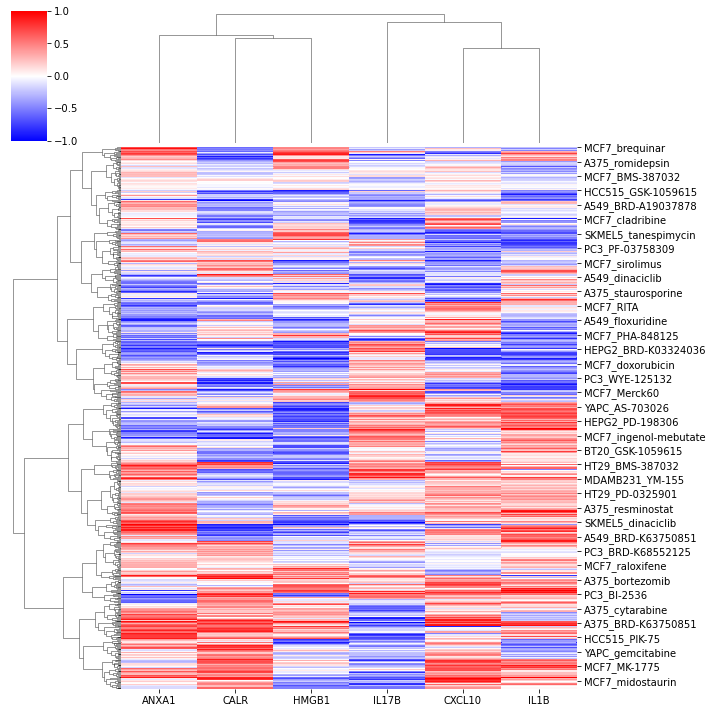

In [88]:
sns.clustermap(corr_ICD_shift_r.fillna(0),
               method='ward',
               vmin=-1, vmax=1, cmap='bwr')

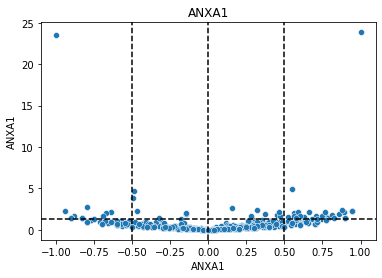

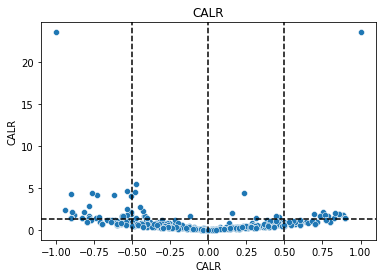

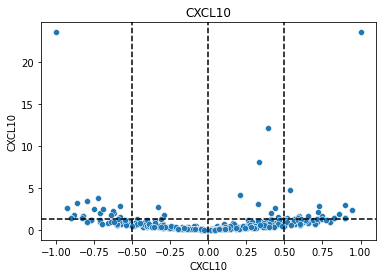

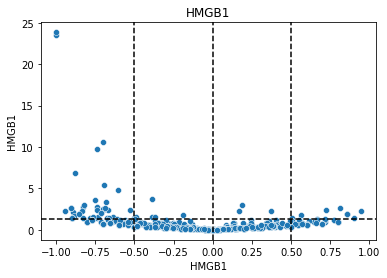

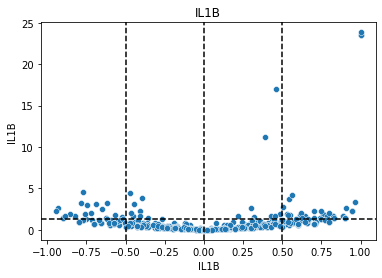

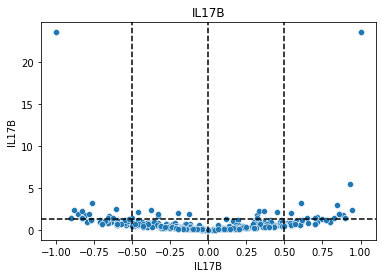

In [166]:
# volcano
for g in icd_selected:
    sns.scatterplot(x=corr_ICD_shift_r[g], y=-np.log10(corr_ICD_shift_p[g].astype(float) + corr_ICD_shift_p.min().max()))
    plt.axvline(x=0., ls='--', c='k')
    plt.axvline(x=-.5, ls='--', c='k')
    plt.axvline(x=.5, ls='--', c='k')
    plt.axhline(y=-np.log10(0.05), ls='--', c='k')
    plt.title(g)
    plt.show()

In [170]:
# primary top hits for each ICD gene: abs(corr) > .5, p < 0.05
top_hit = df(columns=icd_selected, index=corr_ICD_shift_r.index)
for g in icd_selected:
    tmp_r = df(corr_ICD_shift_r[g])
    tmp_p = df(corr_ICD_shift_p[g])
    
    tmp_r_top = tmp_r[abs(tmp_r[g]) >= .5]
    tmp_p_top = tmp_p[tmp_p <= 0.05]
    
    op_tmp_rp = list(set(tmp_r_top.index) & set(tmp_p_top.index))
    
    # save top: 1 as positive, -1 as negative
    top_hit.at[op_tmp_rp, g] = np.sign(tmp_r_top.loc[op_tmp_rp, g])

top_hit = top_hit.dropna(axis=0, how='all').fillna(0)

In [175]:
top_hit.to_csv(poseidon_home + 'ICD/ICD_shift/primary_selection_absr0.5_p0.05.csv', sep=',')

In [171]:
top_hit.shape

(467, 6)

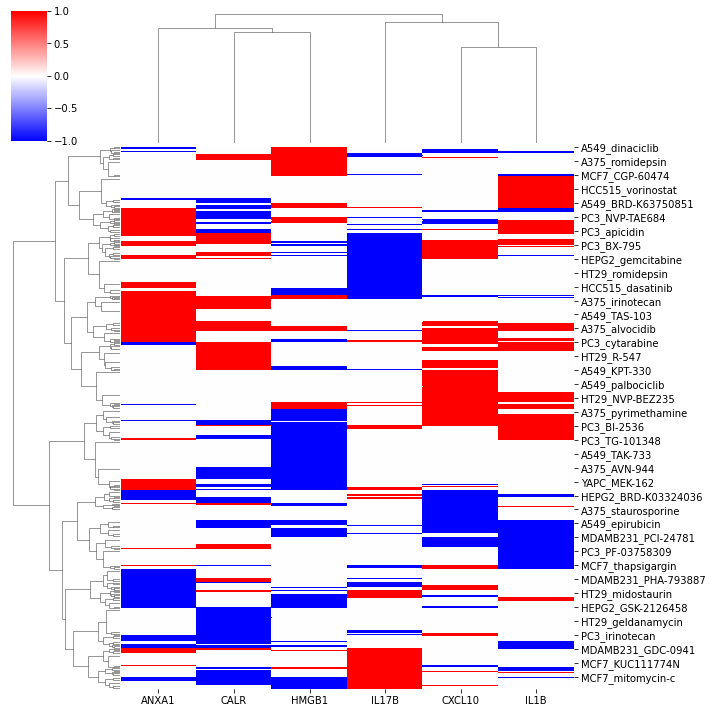

In [174]:
sns.clustermap(top_hit, vmin=-1, vmax=1, method='ward', cmap='bwr')

In [181]:
top_hit_sum = df(top_hit.sum(axis=1)).rename(columns={0: 'sig_sum'})
top_hit_sum = top_hit_sum.sort_values(by='sig_sum', ascending=False)

In [183]:
top_hit_sum['moa'] = dose_dep_icd_rs_g24['moa']

In [191]:
top_hit_sum['dose_shift'] = dose_dep_icd_rs_g24['shift_r']

In [192]:
top_hit_sum[:25]

sig_sum                                     moa  \
HEPG2_selumetinib          5                           MEK inhibitor   
A375_GSK-1070916           4                 Aurora kinase inhibitor   
A375_BRD-K63750851         4                                     NaN   
A375_carfilzomib           4                    Proteasome inhibitor   
PC3_torin-1                4                          MTOR inhibitor   
A375_alvocidib             4                           CDK inhibitor   
HT29_BMS-387032            4                           CDK inhibitor   
MCF7_foretinib             4                         VEGFR inhibitor   
A549_NVP-TAE684            3                           ALK inhibitor   
PC3_JNJ-26481585           3                          HDAC inhibitor   
A375_dinaciclib            3                           CDK inhibitor   
PC3_staurosporine          3                           PKC inhibitor   
A375_cabazitaxel           3                                     NaN   
PC3_MST-312                3                    Telomerase inhibitor   
PC3_BI-2536                3                           PLK inhibitor   
HT29_MK-1775               3                   WEE1 kinase inhibitor   
HELA_dinaciclib            3                           CDK inhibitor   
A549_brequinar             3  Dihydroorotate dehydrogenase inhibitor   
HT29_SB-939                3                          HDAC inhibitor   
A375_BRD-K54606188         3                                     NaN   
HS578T_mitoxantrone        3                 Topoisomerase inhibitor   
MCF7_BRD-K91237281         3                                     NaN   
PC3_PKI-179                2                          MTOR inhibitor   
A549_PIK-75                2                          PI3K inhibitor   
PC3_PHA-848125             2                           CDK inhibitor   

                     dose_shift  
HEPG2_selumetinib     -0.600000  
A375_GSK-1070916       0.542857  
A375_BRD-K63750851    -0.700000  
A375_carfilzomib       0.900000  
PC3_torin-1           -0.168408  
A375_alvocidib         0.012276  
HT29_BMS-387032        0.176547  
MCF7_foretinib        -0.037424  
A549_NVP-TAE684       -0.158114  
PC3_JNJ-26481585      -0.214286  
A375_dinaciclib        0.227794  
PC3_staurosporine      0.698253  
A375_cabazitaxel      -0.885714  
PC3_MST-312            0.323669  
PC3_BI-2536            0.439480  
HT29_MK-1775          -0.051299  
HELA_dinaciclib       -0.600000  
A549_brequinar         0.150000  
HT29_SB-939           -0.107143  
A375_BRD-K54606188     0.261624  
HS578T_mitoxantrone    0.312045  
MCF7_BRD-K91237281     0.600000  
PC3_PKI-179            0.095238  
A549_PIK-75            0.115954  
PC3_PHA-848125        -0.150000

In [193]:
top_hit_sum[-25:]

sig_sum                      moa  dose_shift
HT29_SB-590885                    -2            RAF inhibitor    0.300000
A375_crizotinib                   -2            ALK inhibitor    0.288675
HEPG2_wortmannin                  -2           PI3K inhibitor   -0.218312
A375_CEP-37440                    -2            ALK inhibitor    0.790569
MCF7_TG-101348                    -3            JAK inhibitor    0.051299
MCF7_danusertib                   -3  Aurora kinase inhibitor   -0.700000
HCC515_BMS-754807                 -3          IGF-1 inhibitor    0.666886
HELA_fluocinolone-acetonide       -3   Corticosteroid agonist    0.028571
PC3_sorafenib                     -3            KIT inhibitor    0.130931
SKMEL5_vorinostat                 -3           HDAC inhibitor   -0.881917
HEPG2_trametinib                  -3            MEK inhibitor   -0.028571
MCF7_AT-7519                      -3            CDK inhibitor   -0.447214
A549_apicidin                     -3           HDAC inhibitor   -0.714286
HT29_LGX-818                      -3                      NaN    0.485714
HEPG2_GSK-2126458                 -3                      NaN    0.828571
VCAP_TG-101348                    -3            JAK inhibitor   -1.000000
HCC515_staurosporine              -3            PKC inhibitor   -0.485714
A375_deforolimus                  -3           MTOR inhibitor    0.900000
A549_R-547                        -4                      NaN   -0.866025
MCF7_epirubicin                   -4  Topoisomerase inhibitor   -0.644909
A549_doxorubicin                  -4  Topoisomerase inhibitor   -0.555780
A549_idarubicin                   -4  Topoisomerase inhibitor   -0.729574
A549_epirubicin                   -4  Topoisomerase inhibitor   -0.601989
A549_daunorubicin                 -4  RNA synthesis inhibitor   -0.891534
A549_entinostat                   -4           HDAC inhibitor    0.408248

In [211]:
top_hit_sum[top_hit_sum['moa'] == 'Topoisomerase inhibitor']

sig_sum                      moa  dose_shift
HS578T_mitoxantrone          3  Topoisomerase inhibitor    0.312045
MDAMB231_mitoxantrone        2  Topoisomerase inhibitor   -0.098833
HELA_SN-38                   2  Topoisomerase inhibitor    0.257143
A549_genz-644282             2  Topoisomerase inhibitor    0.516667
A375_irinotecan              2  Topoisomerase inhibitor   -0.277129
MCF7_etoposide               1  Topoisomerase inhibitor    0.304256
A375_camptothecin            1  Topoisomerase inhibitor    0.175758
MCF7_SN-38                   1  Topoisomerase inhibitor    0.463129
A549_topotecan               1  Topoisomerase inhibitor    0.348155
A549_SN-38                   1  Topoisomerase inhibitor    0.359092
A549_etoposide               1  Topoisomerase inhibitor   -0.353553
A549_TAS-103                 1  Topoisomerase inhibitor   -0.485714
HT29_SN-38                   1  Topoisomerase inhibitor   -0.882919
SKBR3_mitoxantrone           1  Topoisomerase inhibitor    0.176547
A375_TAS-103                 1  Topoisomerase inhibitor   -0.690909
A375_topotecan               1  Topoisomerase inhibitor    0.485714
A375_etoposide               1  Topoisomerase inhibitor    0.357813
MDAMB231_camptothecin        1  Topoisomerase inhibitor    0.657143
MCF7_topotecan               1  Topoisomerase inhibitor   -0.428571
SKMEL5_mitoxantrone          0  Topoisomerase inhibitor    0.340487
A375_mitoxantrone            0  Topoisomerase inhibitor   -0.529447
MCF7_irinotecan              0  Topoisomerase inhibitor    0.101419
HELA_TAS-103                 0  Topoisomerase inhibitor    0.000000
A375_SN-38                  -1  Topoisomerase inhibitor    0.239340
BT20_mitoxantrone           -1  Topoisomerase inhibitor    0.323669
PC3_SN-38                   -1  Topoisomerase inhibitor    0.393939
PC3_genz-644282             -1  Topoisomerase inhibitor   -0.885714
MCF7_camptothecin           -1  Topoisomerase inhibitor   -0.059177
MCF7_TAS-103                -1  Topoisomerase inhibitor    0.214286
HELA_camptothecin           -1  Topoisomerase inhibitor    0.500000
HT29_genz-644282            -1  Topoisomerase inhibitor    0.063636
PC3_epirubicin              -1  Topoisomerase inhibitor   -0.559598
HEPG2_mitoxantrone          -1  Topoisomerase inhibitor   -0.654149
HEPG2_topotecan             -1  Topoisomerase inhibitor    0.800000
PC3_camptothecin            -1  Topoisomerase inhibitor    0.209137
PC3_irinotecan              -1  Topoisomerase inhibitor   -0.516100
PC3_topotecan               -1  Topoisomerase inhibitor   -0.492805
A375_doxorubicin            -2  Topoisomerase inhibitor   -0.433732
HT29_doxorubicin            -2  Topoisomerase inhibitor   -0.729474
A549_amsacrine              -2  Topoisomerase inhibitor   -0.086966
A549_teniposide             -2  Topoisomerase inhibitor   -0.102598
A375_epirubicin             -2  Topoisomerase inhibitor   -0.942857
MCF7_idarubicin             -2  Topoisomerase inhibitor   -0.147480
MCF7_mitoxantrone           -2  Topoisomerase inhibitor   -0.700726
HT29_epirubicin             -2  Topoisomerase inhibitor   -0.857143
MCF7_epirubicin             -4  Topoisomerase inhibitor   -0.644909
A549_doxorubicin            -4  Topoisomerase inhibitor   -0.555780
A549_idarubicin             -4  Topoisomerase inhibitor   -0.729574
A549_epirubicin             -4  Topoisomerase inhibitor   -0.601989

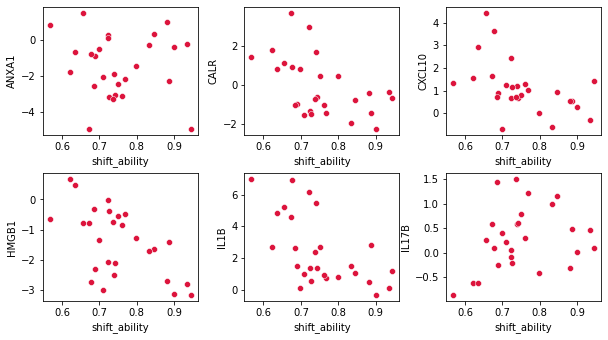

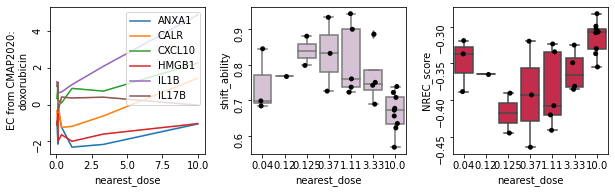

In [212]:
visual_ICD_scatterplot(case='A549_doxorubicin',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='A549_doxorubicin',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

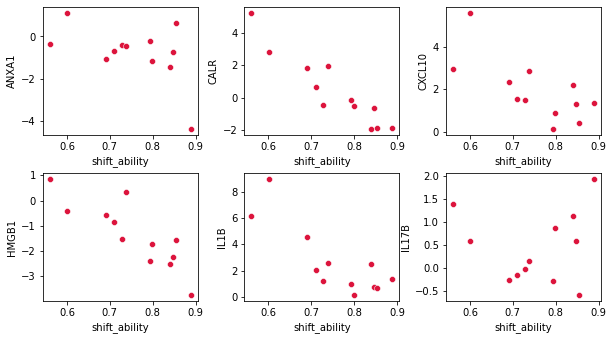

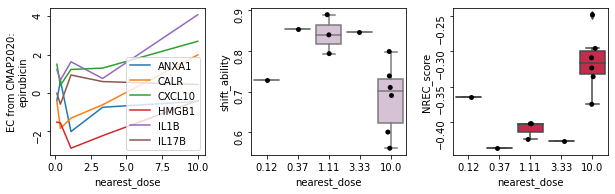

In [213]:
visual_ICD_scatterplot(case='A549_epirubicin',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='A549_epirubicin',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

<AxesSubplot:xlabel='sig_sum', ylabel='dose_shift'>

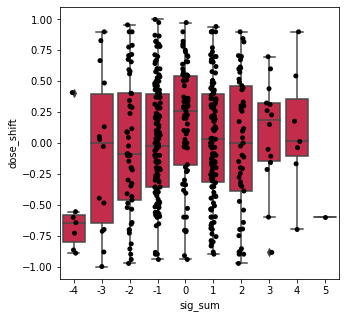

In [197]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='sig_sum',
            y='dose_shift',
            data=top_hit_sum,
            color='crimson')
sns.stripplot(x='sig_sum',
              y='dose_shift',
              data=top_hit_sum,
              color='k')

In [199]:
top_hit_merge = pd.concat([top_hit_sum, top_hit], axis=1)
top_hit_merge

sig_sum                      moa  dose_shift  ANXA1  CALR  \
HEPG2_selumetinib         5            MEK inhibitor   -0.600000      1     1   
A375_GSK-1070916          4  Aurora kinase inhibitor    0.542857      1     1   
A375_BRD-K63750851        4                      NaN   -0.700000      1     1   
A375_carfilzomib          4     Proteasome inhibitor    0.900000      1     1   
PC3_torin-1               4           MTOR inhibitor   -0.168408      0     0   
...                     ...                      ...         ...    ...   ...   
A549_doxorubicin         -4  Topoisomerase inhibitor   -0.555780      0    -1   
A549_idarubicin          -4  Topoisomerase inhibitor   -0.729574      0    -1   
A549_epirubicin          -4  Topoisomerase inhibitor   -0.601989      0    -1   
A549_daunorubicin        -4  RNA synthesis inhibitor   -0.891534      0    -1   
A549_entinostat          -4           HDAC inhibitor    0.408248     -1    -1   

                    CXCL10  HMGB1  IL1B  IL17B  
HEPG2_selumetinib        1      1     1      0  
A375_GSK-1070916         1      0     1      0  
A375_BRD-K63750851       1      1     1     -1  
A375_carfilzomib         1      0     1      0  
PC3_torin-1              1      1     1      1  
...                    ...    ...   ...    ...  
A549_doxorubicin        -1     -1    -1      0  
A549_idarubicin         -1     -1    -1      0  
A549_epirubicin         -1     -1    -1      0  
A549_daunorubicin       -1     -1    -1      0  
A549_entinostat         -1     -1     0      0  

[467 rows x 9 columns]

In [248]:
top_hit_merge['dose_REC'] = dose_dep_icd_rs_g24['rec_r']
top_hit_merge['dose_NREC'] = dose_dep_icd_rs_g24['nrec_r']

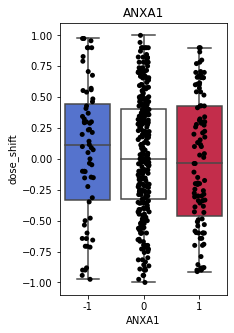

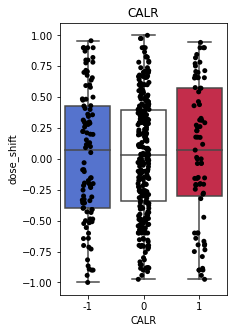

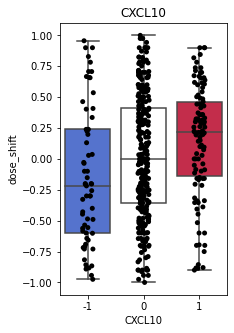

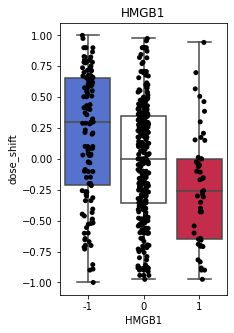

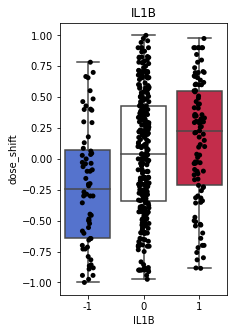

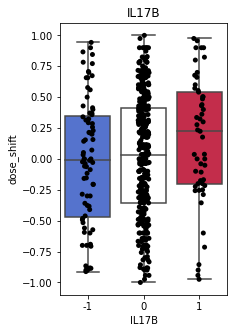

In [206]:
for g in icd_selected:
    plt.figure(figsize=(3, 5))
    sns.boxplot(x=g,
                y='dose_shift',
                data=top_hit_merge,
                palette={-1: 'royalblue', 0: 'white', 1: 'crimson'})
    sns.stripplot(x=g,
                  y='dose_shift',
                  data=top_hit_merge,
                  color='k')
    plt.title(g)
    plt.show()

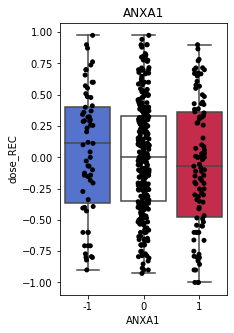

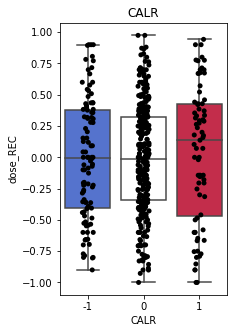

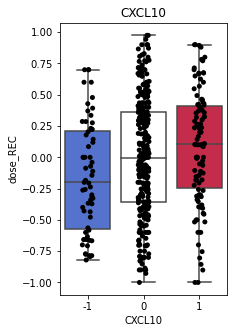

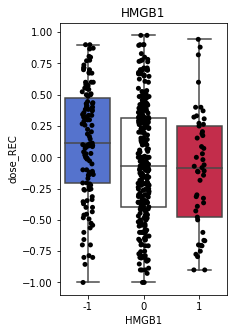

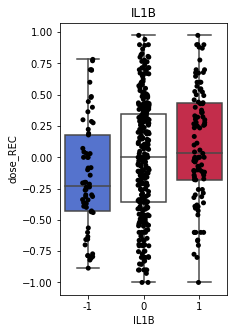

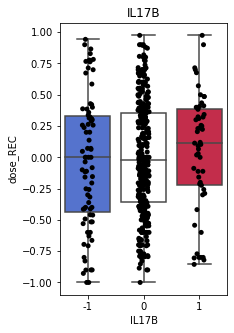

In [247]:
for g in icd_selected:
    plt.figure(figsize=(3, 5))
    sns.boxplot(x=g,
                y='dose_REC',
                data=top_hit_merge,
                palette={-1: 'royalblue', 0: 'white', 1: 'crimson'})
    sns.stripplot(x=g,
                  y='dose_REC',
                  data=top_hit_merge,
                  color='k')
    plt.title(g)
    plt.show()

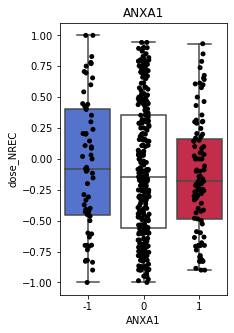

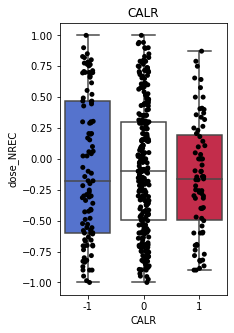

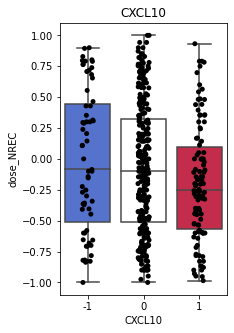

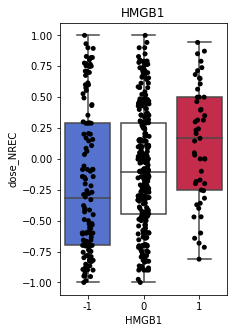

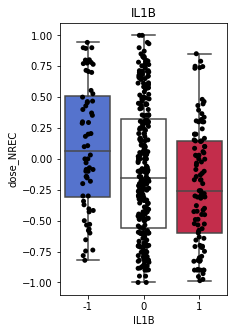

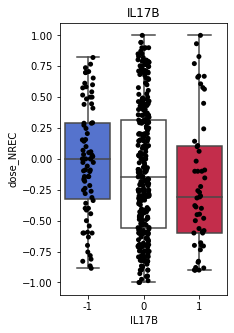

In [249]:
for g in icd_selected:
    plt.figure(figsize=(3, 5))
    sns.boxplot(x=g,
                y='dose_NREC',
                data=top_hit_merge,
                palette={-1: 'royalblue', 0: 'white', 1: 'crimson'})
    sns.stripplot(x=g,
                  y='dose_NREC',
                  data=top_hit_merge,
                  color='k')
    plt.title(g)
    plt.show()

In [208]:
top_hit_merge[top_hit_merge['moa'] == 'MEK inhibitor'].sort_values(by='dose_shift')

sig_sum            moa  dose_shift  ANXA1  CALR  CXCL10  \
HEPG2_selumetinib           5  MEK inhibitor   -0.600000      1     1       1   
A375_trametinib            -1  MEK inhibitor   -0.150034      0     0       0   
A375_PD-0325901             1  MEK inhibitor   -0.119715      0     0       0   
YAPC_AS-703026              1  MEK inhibitor   -0.085714      0     0       1   
HEPG2_trametinib           -3  MEK inhibitor   -0.028571      0     0      -1   
HCC515_PD-0325901           2  MEK inhibitor   -0.024915      0     0       0   
HT29_AS-703026             -2  MEK inhibitor    0.045455      0     0       0   
A375_PD-184352              1  MEK inhibitor    0.194047      0     0       1   
A375_AS-703026              0  MEK inhibitor    0.258304      1    -1       0   
YAPC_PD-0325901             1  MEK inhibitor    0.276725      0     0       0   
A375_refametinib            0  MEK inhibitor    0.300000      1     0       0   
A549_Ro-4987655             0  MEK inhibitor    0.314286      0     1       0   
A375_Ro-4987655             0  MEK inhibitor    0.372727      0     0       1   
MDAMB231_TAK-733            0  MEK inhibitor    0.503030      0     0       0   
HEPG2_PD-0325901            1  MEK inhibitor    0.506061      0     0       0   
HT29_selumetinib           -1  MEK inhibitor    0.527426      0     0       0   
MDAMB231_trametinib        -1  MEK inhibitor    0.535714      0     0      -1   
HT29_Ro-4987655             0  MEK inhibitor    0.551515      0     0       0   
HEPG2_PD-198306             0  MEK inhibitor    0.600000      0     0       0   
YAPC_Ro-4987655             1  MEK inhibitor    0.619048      0     0       1   
MDAMB231_selumetinib        1  MEK inhibitor    0.654654      0     1       1   
A375_TAK-733                1  MEK inhibitor    0.699301      0     0       0   
A549_TAK-733               -1  MEK inhibitor    0.714286      0     0       0   
HT29_refametinib            1  MEK inhibitor    0.738095      0     0       1   
SKMEL5_selumetinib          1  MEK inhibitor    0.900000      0     0       0   

                      HMGB1  IL1B  IL17B  
HEPG2_selumetinib         1     1      0  
A375_trametinib          -1     0      0  
A375_PD-0325901           0     1      0  
YAPC_AS-703026           -1     1      0  
HEPG2_trametinib         -1    -1      0  
HCC515_PD-0325901         1     1      0  
HT29_AS-703026           -1    -1      0  
A375_PD-184352            0     0      0  
A375_AS-703026            0     0      0  
YAPC_PD-0325901           0     0      1  
A375_refametinib         -1     0      0  
A549_Ro-4987655           0     0     -1  
A375_Ro-4987655          -1     0      0  
MDAMB231_TAK-733         -1     0      1  
HEPG2_PD-0325901          1     0      0  
HT29_selumetinib         -1     0      0  
MDAMB231_trametinib       0     0      0  
HT29_Ro-4987655          -1     1      0  
HEPG2_PD-198306          -1     1      0  
YAPC_Ro-4987655          -1     1      0  
MDAMB231_selumetinib     -1     0      0  
A375_TAK-733              0     1      0  
A549_TAK-733             -1     0      0  
HT29_refametinib         -1     1      0  
SKMEL5_selumetinib        0     1      0

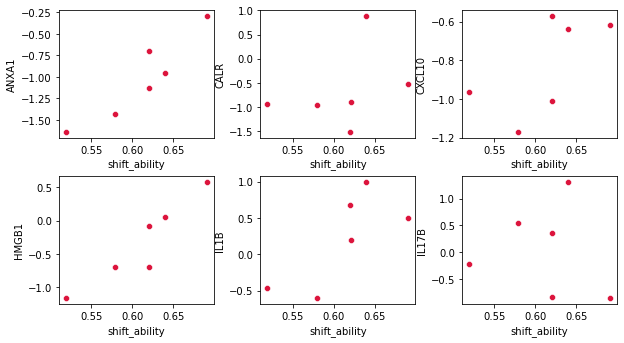

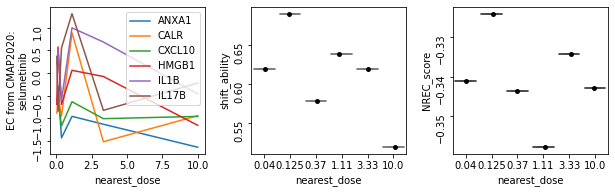

In [209]:
visual_ICD_scatterplot(case='HEPG2_selumetinib',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='HEPG2_selumetinib',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

In [116]:
# add a pseudo p to avoid infinite: the maximum of minimum p
corr_ICD_shift_sp = -np.log10(corr_ICD_shift_p.astype(float) + corr_ICD_shift_p.min().max()) * np.sign(corr_ICD_shift_r)

In [117]:
corr_ICD_shift_sp = corr_ICD_shift_sp.dropna(axis=0, how='all').fillna(0)

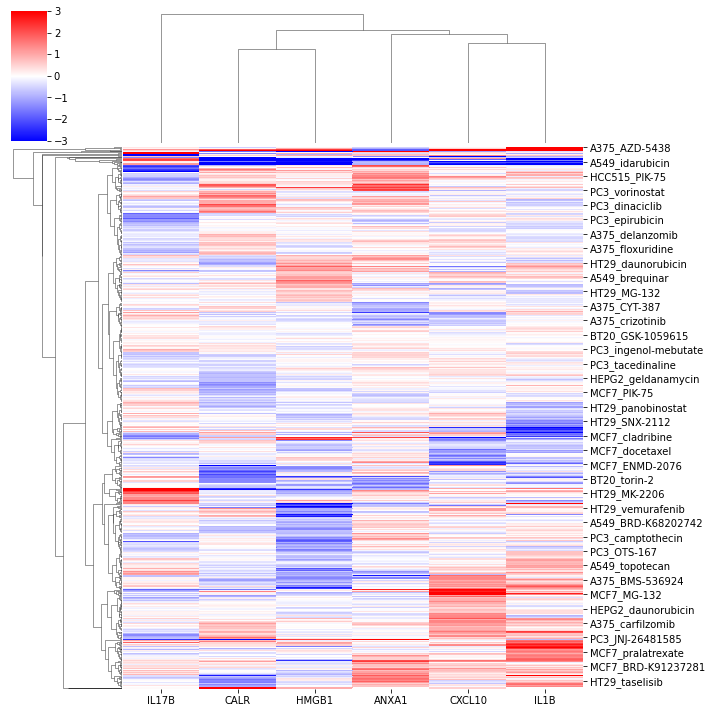

In [121]:
sns.clustermap(corr_ICD_shift_sp,
               method='ward',
               vmin=-3, vmax=3, cmap='bwr')

In [122]:
corr_ICD_shift_sp.loc['A375_PF-03758309', :]

ANXA1    -1.057383
CALR     -0.217598
CXCL10    0.577433
HMGB1    -1.113911
IL1B      1.302185
IL17B     0.856277
Name: A375_PF-03758309, dtype: float64

In [123]:
corr_ICD_shift_sp.loc['HELA_dinaciclib', :]

ANXA1     0.545526
CALR      1.427290
CXCL10    0.059041
HMGB1     0.407821
IL1B      0.126644
IL17B     0.725564
Name: HELA_dinaciclib, dtype: float64

In [127]:
# sum and sort: signed log10 p values
# hypothesis: bigger sum, more ICD-dependent shift
corr_IS_sp_sum = df(corr_ICD_shift_sp.sum(axis=1)).rename(columns={0: 'sum_signedLogP'})
corr_IS_sp_sum

sum_signedLogP
SKBR3_mitoxantrone         1.301297
SKBR3_afatinib            -0.650927
SKBR3_neratinib           -2.203507
SKBR3_CGP-60474           -0.725706
SKBR3_NVP-BEZ235          -0.645805
...                             ...
SKMEL5_cobimetinib         1.785123
SKMEL5_selumetinib         0.104253
SKMEL5_bortezomib          0.145769
SKMEL5_dinaciclib          0.882178
SKMEL5_tanespimycin       -1.812257

[639 rows x 1 columns]

In [129]:
corr_IS_sp_sum.sort_values(by='sum_signedLogP', ascending=False)[:20]

sum_signedLogP
A375_MG-132               35.175083
A375_AZD-5438             27.393164
A549_NVP-TAE684           25.138687
MCF7_torin-2              24.642192
PC3_Merck60               24.350335
HS578T_BMS-387032         23.971691
A375_bortezomib           23.055725
MDAMB231_NVP-BEZ235       23.010784
HCC515_wortmannin         22.013435
HEPG2_selumetinib          7.101031
HT29_BMS-387032            6.221212
MCF7_YM-155                5.783542
PC3_torin-1                5.751761
PC3_mitoxantrone           5.377093
A375_cabazitaxel           5.087117
A375_irinotecan            5.079461
A375_dinaciclib            4.968577
PC3_staurosporine          4.781432
MCF7_NVP-BEZ235            4.484795
PC3_bortezomib             4.397999

In [155]:
corr_IS_sp_sum['norm_samplesize'] = corr_IS_sp_sum['sum_signedLogP'] / corr_ICD_shift_info['#experiment']

In [156]:
corr_IS_sp_sum.sort_values(by='norm_samplesize', ascending=False)[:20]

sum_signedLogP norm_samplesize
A549_NVP-TAE684           25.138687         5.02774
MCF7_torin-2              24.642192         4.92844
PC3_Merck60               24.350335         4.87007
HS578T_BMS-387032         23.971691         4.79434
MDAMB231_NVP-BEZ235       23.010784         4.60216
HCC515_wortmannin         22.013435         4.40269
A375_AZD-5438             27.393164         3.91331
HEPG2_selumetinib          7.101031         1.18351
HT29_BMS-387032            6.221212         1.03687
A375_cabazitaxel           5.087117        0.847853
PC3_torin-1                5.751761         0.82168
PC3_staurosporine          4.781432        0.796905
MCF7_YM-155                5.783542        0.722943
A375_carfilzomib           3.399803        0.679961
PC3_MST-312                4.059348        0.676558
A375_GSK-1070916           4.023678        0.670613
HELA_dinaciclib            3.291886        0.658377
A375_irinotecan            5.079461        0.634933
PC3_JNJ-26481585           4.361946        0.623135
HCC515_PIK-75              2.999785        0.599957

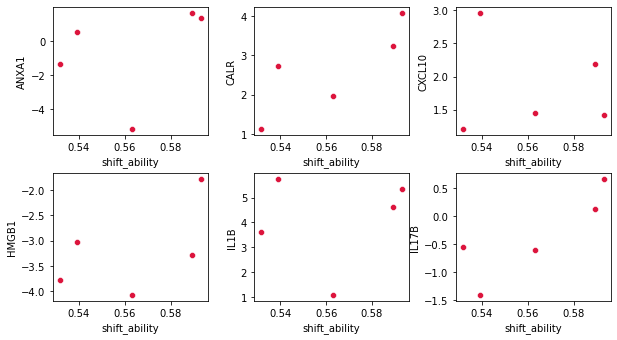

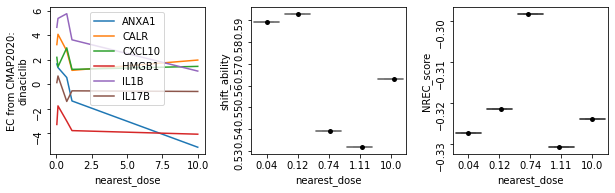

In [159]:
visual_ICD_scatterplot(case='HELA_dinaciclib',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='HELA_dinaciclib',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

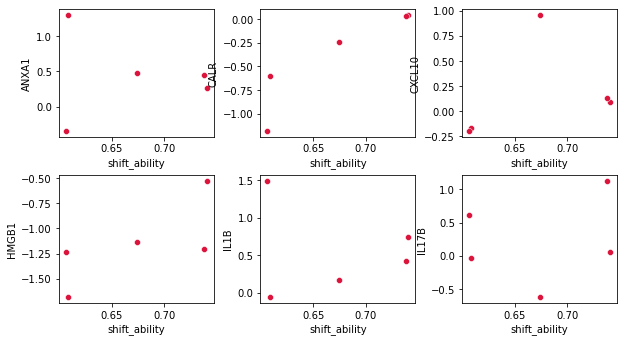

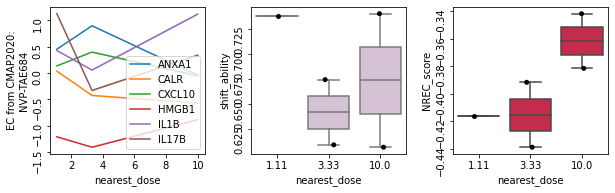

In [160]:
visual_ICD_scatterplot(case='A549_NVP-TAE684',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='A549_NVP-TAE684',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

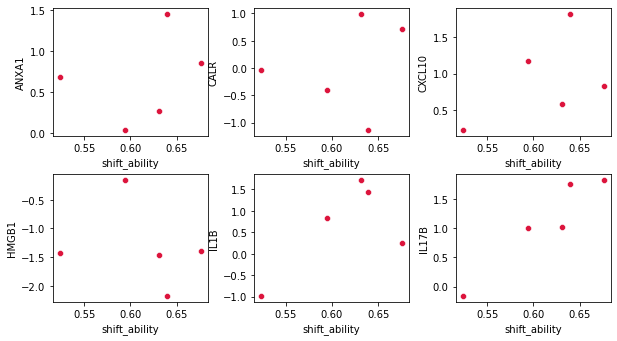

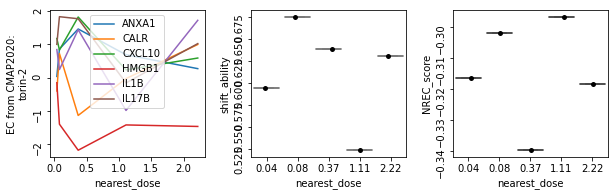

In [161]:
visual_ICD_scatterplot(case='MCF7_torin-2',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='MCF7_torin-2',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

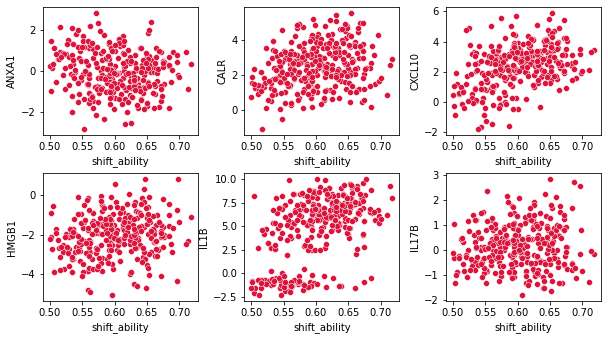

In [150]:
visual_ICD_scatterplot(case='A375_MG-132',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

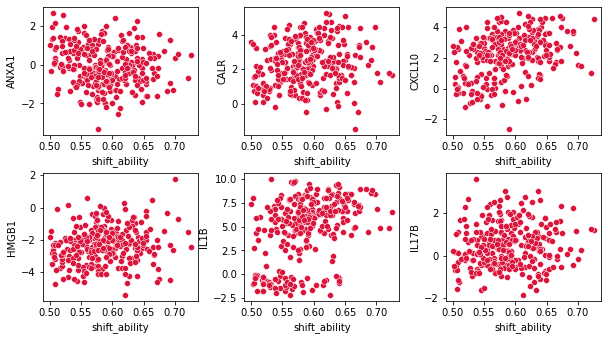

In [151]:
visual_ICD_scatterplot(case='A375_bortezomib',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

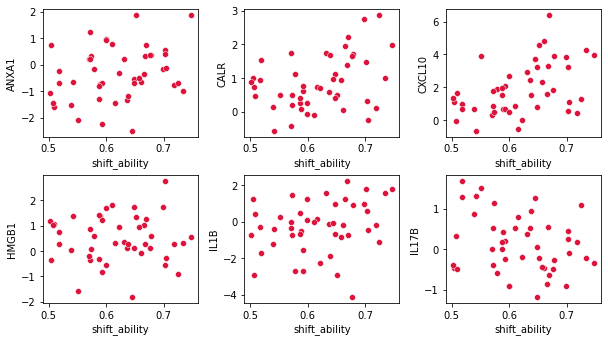

In [152]:
visual_ICD_scatterplot(case='PC3_mitoxantrone',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

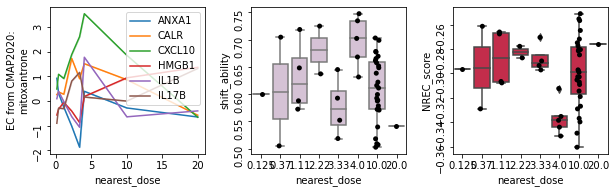

In [154]:
visual_ICD_lineplot(case='PC3_mitoxantrone',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

# Cat_I: low dosage induce ICD-dependent shift

In [14]:
# list by moas
for m in cat_I_expand_icd_moa['moa'].unique():
    print(m)
    print(cat_I_expand_icd_moa[cat_I_expand_icd_moa['moa'] == m])

CDK inhibitor
                 shift_r   shift_p  rec_r     rec_p  nrec_r    nrec_p  \
HELA_dinaciclib     -0.6  0.284757   -0.8  0.104088    -0.1  0.872889   
HT29_dinaciclib     -0.8  0.104088    0.1  0.872889     0.7  0.188120   
YAPC_PHA-848125     -0.6  0.284757   -0.6  0.284757    -0.5  0.391002   

                 icd_ave_r  icd_ave_p  ANXA1_r       ANXA1_p  ...    IL1B_p  \
HELA_dinaciclib       -0.9   0.037386     -1.0  1.404265e-24  ...  0.284757   
HT29_dinaciclib       -0.5   0.391002     -0.5  3.910022e-01  ...  0.284757   
YAPC_PHA-848125       -0.1   0.872889      0.0  1.000000e+00  ...  0.284757   

                 IL17B_r   IL17B_p  cancer_type  cell_line   cmap_name  \
HELA_dinaciclib     -0.6  0.284757         CESC       HELA  dinaciclib   
HT29_dinaciclib     -0.6  0.284757          CRC       HT29  dinaciclib   
YAPC_PHA-848125      0.8  0.104088         PAAD       YAPC  PHA-848125   

                 #experiments            moa  target  ICD_criteria_conf  
HELA_

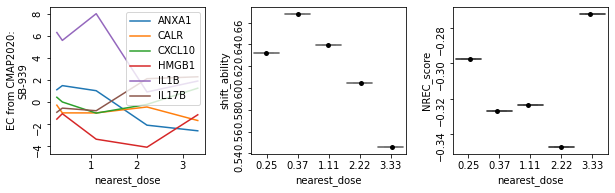

In [16]:
visual_ICD_lineplot(case='PC3_SB-939',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

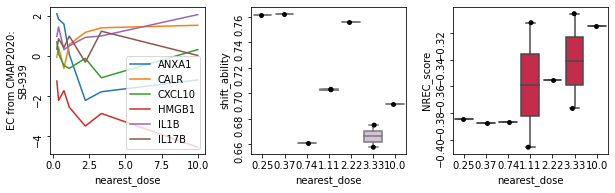

In [17]:
visual_ICD_lineplot(case='MCF7_SB-939',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

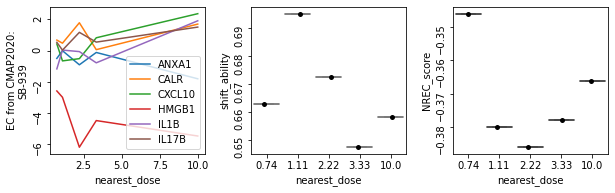

In [19]:
visual_ICD_lineplot(case='A375_SB-939',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

In [23]:
# sort by confidence
cat_I_expand_icd_moa.sort_values(by='ICD_criteria_conf', ascending=False)['moa']

HELA_dinaciclib                                CDK inhibitor
PC3_thapsigargin                            ATPase inhibitor
HT29_dinaciclib                                CDK inhibitor
PC3_SB-939                                    HDAC inhibitor
A375_cabazitaxel                                         NaN
MCF7_PCI-24781                                HDAC inhibitor
A375_TAS-103                         Topoisomerase inhibitor
A375_CEP-32496                                 RAF inhibitor
PC3_PCI-24781                                 HDAC inhibitor
MDAMB231_BRD-K68552125                                   NaN
PC3_cladribine                 Adenosine deaminase inhibitor
HCC515_afatinib                               EGFR inhibitor
HEPG2_gemcitabine         Ribonucleotide reductase inhibitor
PC3_atorvastatin                             HMGCR inhibitor
A375_epirubicin                      Topoisomerase inhibitor
MCF7_SB-939                                   HDAC inhibitor
A375_LY-2874455         

In [25]:
# multiple hits
cat_I_expand_icd_moa['cmap_name'].value_counts()[:10]

SB-939           3
epirubicin       3
PCI-24781        3
mitoxantrone     2
dinaciclib       2
JNJ-26481585     2
BRD-K68202742    2
gemcitabine      2
apicidin         2
PHA-848125       1
Name: cmap_name, dtype: int64

In [ ]:
# SB-939: Phase III discontinued, pracinostat
# PCI-24781: Phase II, abexinostat
# JNJ-26481585: Phase II, Quisinostat 

# epirubicin: approved, Topo i
# mitoxantrone: approved, Topo i
# dinaciclib: approved, CDKi
# gemcitabine: approved, Ribonucleotide reductase i

epirubicin
A375_epirubicin


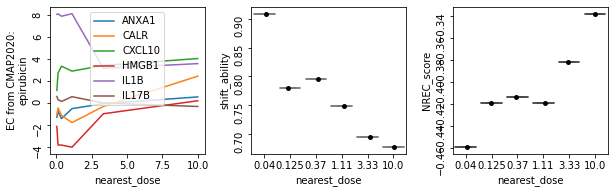

HT29_epirubicin


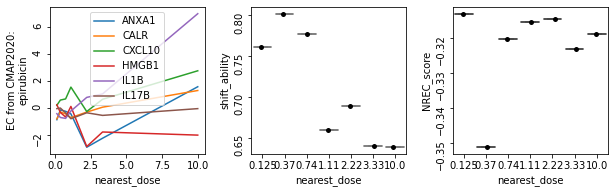

MCF7_epirubicin


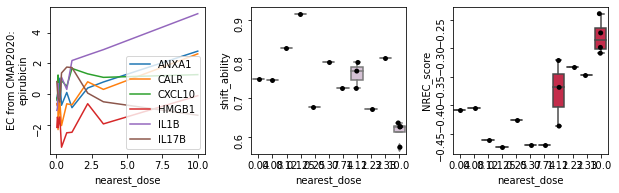

mitoxantrone
A375_mitoxantrone


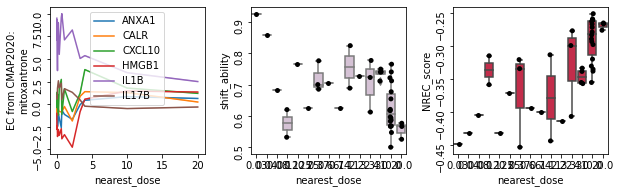

HEPG2_mitoxantrone


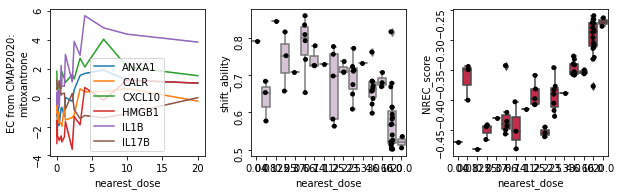

dinaciclib
HELA_dinaciclib


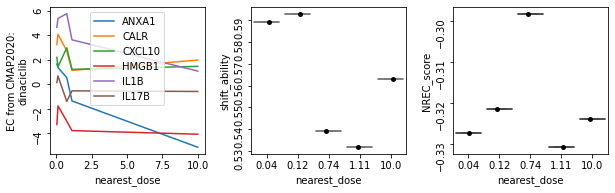

HT29_dinaciclib


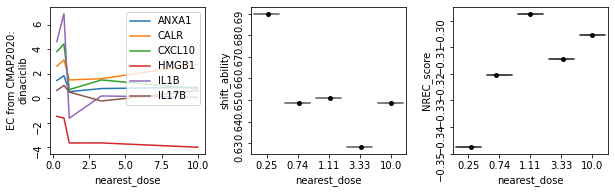

gemcitabine
HEPG2_gemcitabine


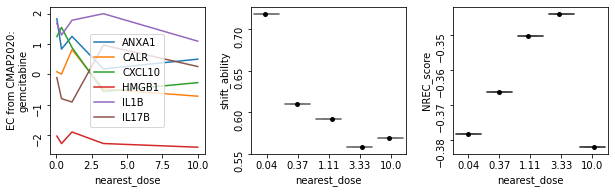

YAPC_gemcitabine


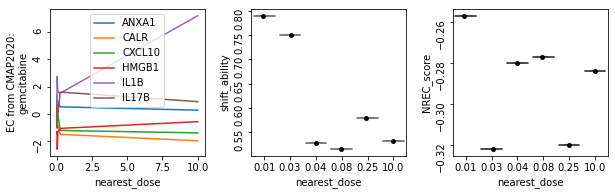

In [26]:
# visualize the above approved cases
for c in ['epirubicin', 'mitoxantrone', 'dinaciclib', 'gemcitabine']:
    print(c)
    tmp = cat_I_expand_icd_moa[cat_I_expand_icd_moa['cmap_name'] == c]
    for i in tmp.index:
        print(i)
        visual_ICD_lineplot(case=i,
                            merge_24h=icd_rs_expr_24h,
                            icd_glist=icd_selected,
                            save_path=None)

## case: Dinaciclib

In [27]:
case_dinaciclib = icd_rs_expr_24h[icd_rs_expr_24h['cmap_name'] == 'dinaciclib']

In [28]:
case_dinaciclib

IL17B     ANXA1     HMGB1      IL1B    CXCL10  \
LJP007_MDAMB231_24H:E19 -0.693500 -0.584650 -1.839950  5.236650  2.607600   
LJP007_MDAMB231_24H:E21  0.175400  0.155200 -1.114800  5.464600  2.115350   
LJP007_MDAMB231_24H:E22 -0.751250  0.034950  0.233650  4.913350  1.881150   
LJP007_MDAMB231_24H:E23 -1.888300 -0.916700  0.399550  5.021450  2.974500   
LJP007_MDAMB231_24H:E24 -2.781700 -1.064100  0.633450  5.084300  3.688800   
...                           ...       ...       ...       ...       ...   
MOAR005_A375_24H:O21    -1.403299  1.812071 -0.758006  6.669814  5.613466   
REP.A010_A375_24H:J01   -0.706387  1.118117 -3.858429  0.112543  1.728317   
REP.A010_A375_24H:J03   -1.555972  2.582001 -4.171247 -0.354999  2.616742   
REP.A010_A375_24H:J04   -1.277784  1.058483 -4.303387 -0.790301  0.652939   
REP.A010_A375_24H:J05   -1.065891  1.833663 -1.928620  1.020525 -1.063552   

                             CALR cancer_type  time       tas cell_line  \
LJP007_MDAMB231_24H:E19  3.818350        BRCA  24.0  0.733242  MDAMB231   
LJP007_MDAMB231_24H:E21  3.116900        BRCA  24.0  0.720092  MDAMB231   
LJP007_MDAMB231_24H:E22  2.915650        BRCA  24.0  0.763934  MDAMB231   
LJP007_MDAMB231_24H:E23  1.981700        BRCA  24.0  0.799665  MDAMB231   
LJP007_MDAMB231_24H:E24  2.000700        BRCA  24.0  0.769406  MDAMB231   
...                           ...         ...   ...       ...       ...   
MOAR005_A375_24H:O21     3.511112        SKCM  24.0  0.843046      A375   
REP.A010_A375_24H:J01    3.449856        SKCM  24.0  0.823917      A375   
REP.A010_A375_24H:J03    2.327994        SKCM  24.0  0.833627      A375   
REP.A010_A375_24H:J04    0.447217        SKCM  24.0  0.847957      A375   
REP.A010_A375_24H:J05   -2.187099        SKCM  24.0  0.784910      A375   

                         shift_ability  NREC_score  REC_score dose_cat  \
LJP007_MDAMB231_24H:E19       0.627075   -0.314601   0.312474   medium   
LJP007_MDAMB231_24H:E21       0.562571   -0.293635   0.268936   medium   
LJP007_MDAMB231_24H:E22       0.627808   -0.306800   0.321008      low   
LJP007_MDAMB231_24H:E23       0.656882   -0.323380   0.333501      low   
LJP007_MDAMB231_24H:E24       0.585420   -0.281711   0.303709      low   
...                                ...         ...        ...      ...   
MOAR005_A375_24H:O21          0.784361   -0.382501   0.401860   medium   
REP.A010_A375_24H:J01         0.763555   -0.357622   0.405934   medium   
REP.A010_A375_24H:J03         0.750009   -0.366782   0.383227   medium   
REP.A010_A375_24H:J04         0.622396   -0.353118   0.269277      low   
REP.A010_A375_24H:J05         0.565334   -0.321315   0.244019      low   

                          icd_ave  nearest_dose   cmap_name  
LJP007_MDAMB231_24H:E19  1.424083        10.000  dinaciclib  
LJP007_MDAMB231_24H:E21  1.652108         1.110  dinaciclib  
LJP007_MDAMB231_24H:E22  1.537917         0.370  dinaciclib  
LJP007_MDAMB231_24H:E23  1.262033         0.120  dinaciclib  
LJP007_MDAMB231_24H:E24  1.260242         0.040  dinaciclib  
...                           ...           ...         ...  
MOAR005_A375_24H:O21     2.574193         1.110  dinaciclib  
REP.A010_A375_24H:J01    0.307336        10.000  dinaciclib  
REP.A010_A375_24H:J03    0.240753         1.110  dinaciclib  
REP.A010_A375_24H:J04   -0.702139         0.370  dinaciclib  
REP.A010_A375_24H:J05   -0.565163         0.125  dinaciclib  

[76 rows x 17 columns]

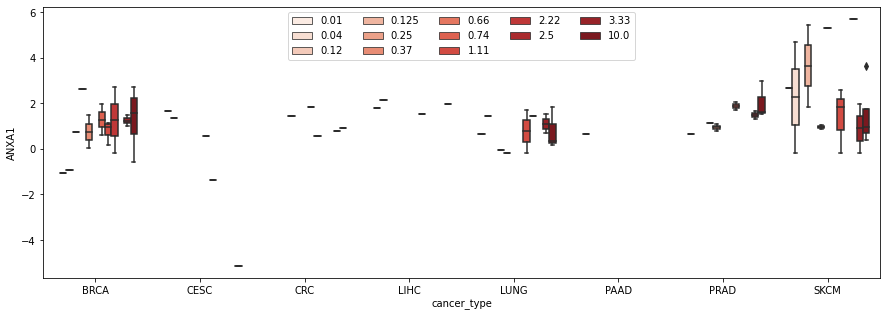

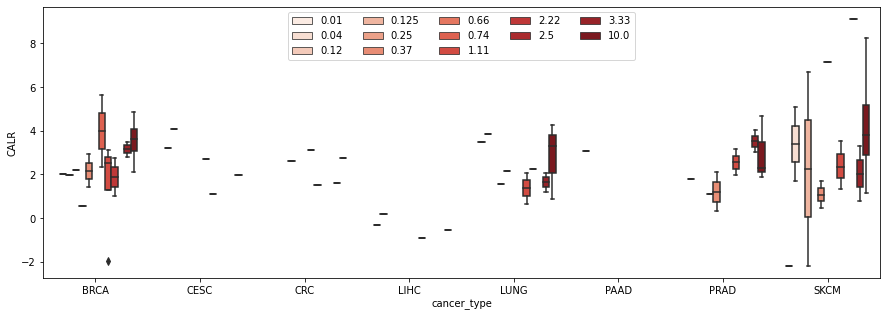

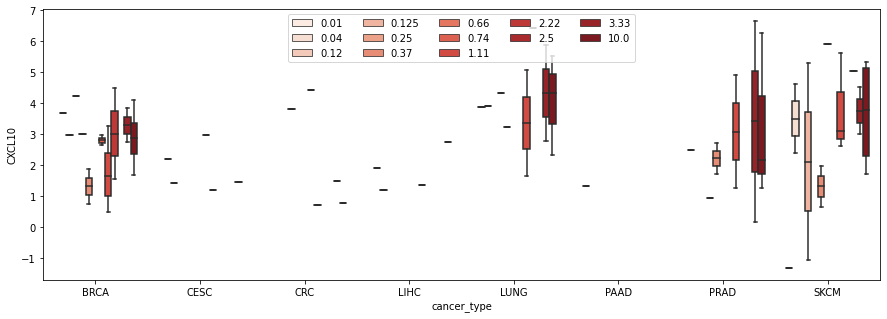

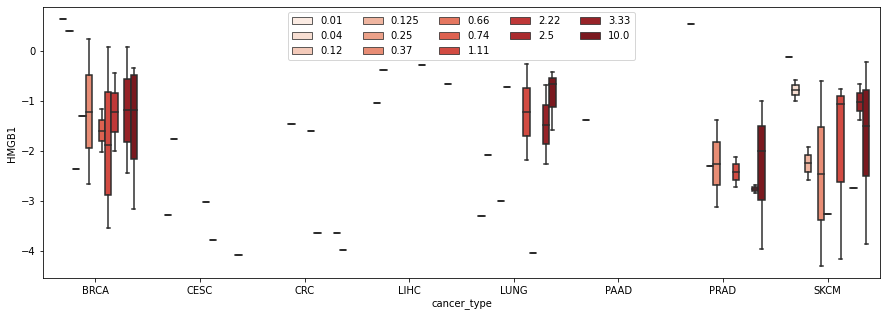

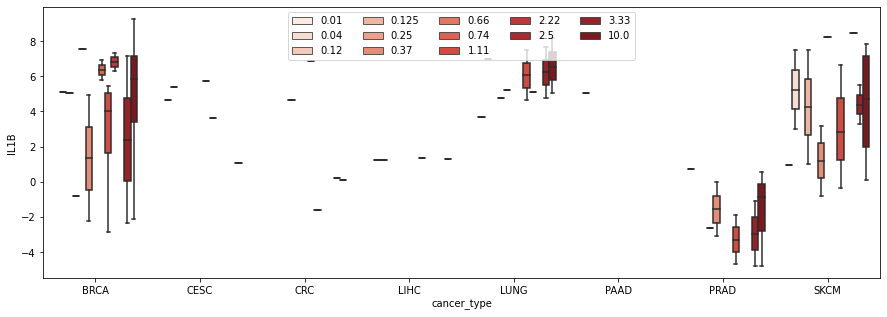

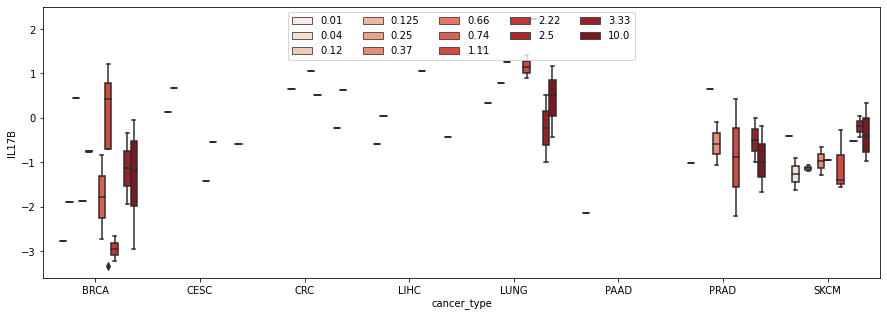

In [45]:
for g in icd_selected:
    plt.figure(figsize=(15, 5))
    sns.boxplot(x='cancer_type',
                y=g,
                hue='nearest_dose',
                palette='Reds',
                data=case_dinaciclib)
    plt.legend(loc='upper center', ncol=5)
    plt.show()

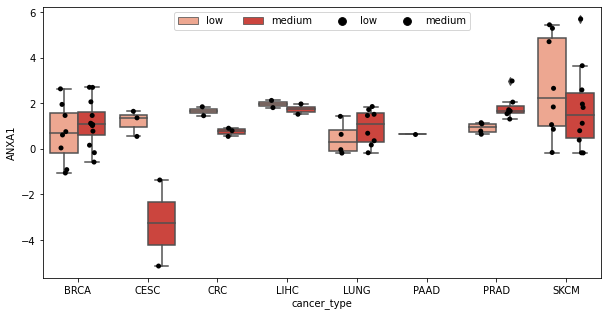

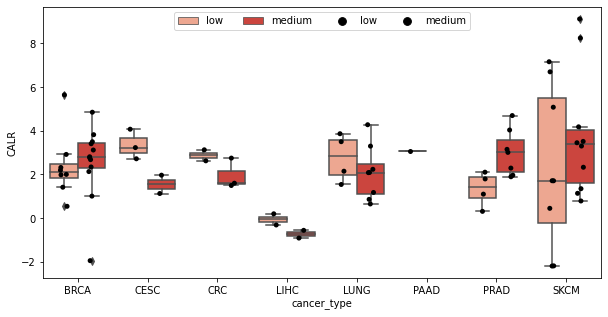

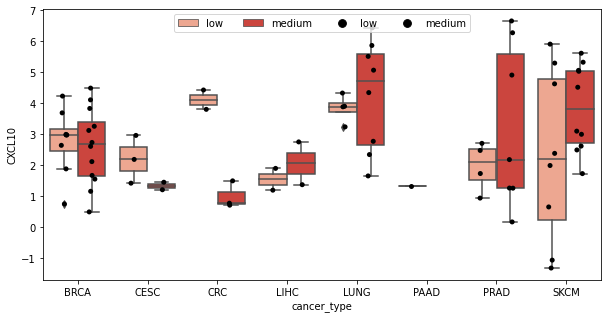

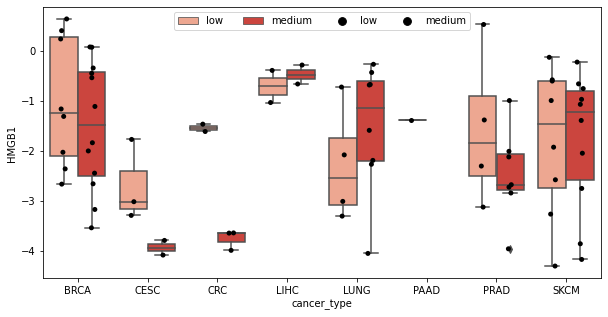

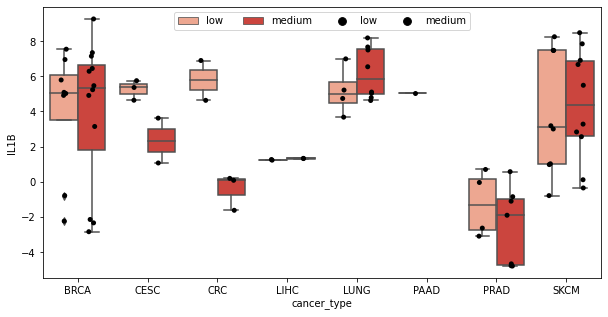

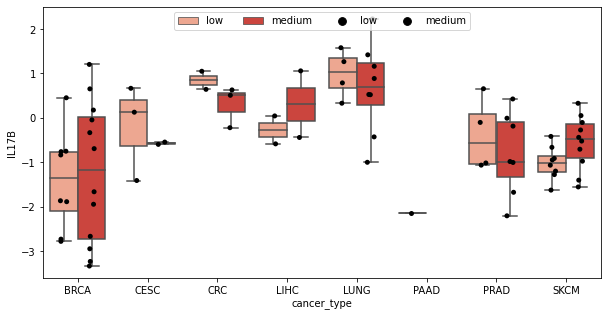

In [60]:
for g in icd_selected:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='cancer_type',
                y=g,
                hue='dose_cat',
                hue_order=['low', 'medium'],
                palette='Reds',
                data=case_dinaciclib)
    sns.stripplot(x='cancer_type',
                y=g,
                hue='dose_cat',
                dodge=True,
                hue_order=['low', 'medium'],
                palette={'low': 'k', 'medium': 'k'},
                data=case_dinaciclib)
    plt.legend(loc='upper center', ncol=5)
    plt.show()

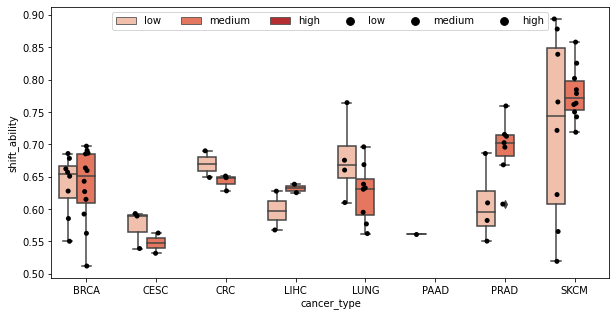

In [70]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='cancer_type',
            y='shift_ability',
            hue='dose_cat',
            hue_order=['low', 'medium', 'high'],
            palette='Reds',
            data=case_dinaciclib)
sns.stripplot(x='cancer_type',
              y='shift_ability',
              hue='dose_cat',
              dodge=True,
              hue_order=['low', 'medium', 'high'],
              palette={'low': 'k', 'medium': 'k', 'high': 'k'},
              data=case_dinaciclib)
plt.legend(loc='upper center', ncol=6)
plt.show()

## case: gemcitabine

In [46]:
case_gemcitabine = icd_rs_expr_24h[icd_rs_expr_24h['cmap_name'] == 'gemcitabine']

In [47]:
case_gemcitabine

IL17B     ANXA1     HMGB1      IL1B    CXCL10  \
CPC006_MCF7_24H:P01   -0.517868  0.483950 -1.946098  0.512847  1.122162   
CPD003_MCF7_24H:M02   -0.510831  2.552324 -1.885444 -0.797169  0.066770   
PBIOA014_MCF7_24H:B13 -0.715350  3.233700 -2.147700  0.607150 -0.456550   
PBIOA014_MCF7_24H:B14 -0.289892  2.485771 -1.768251  1.375081  1.781457   
PBIOA014_MCF7_24H:B15 -0.743097  2.148071 -1.626086  1.363150  0.976442   
...                         ...       ...       ...       ...       ...   
REP.A010_A375_24H:N14  0.643088  1.013560 -1.890998  3.500268  0.609513   
REP.A010_A375_24H:N15  1.672521  0.611301 -2.087347  2.767695 -0.189850   
REP.A010_A375_24H:N16  1.980197  0.501431 -3.189068  2.880741 -1.553819   
REP.A010_A375_24H:N17  1.891917  0.400365 -1.767425  2.979655  0.678710   
REP.A010_A375_24H:N18  2.568986  0.763653 -2.144364  3.478764  0.832020   

                           CALR cancer_type  time       tas cell_line  \
CPC006_MCF7_24H:P01    0.358490        BRCA  24.0  0.583221      MCF7   
CPD003_MCF7_24H:M02    0.581819        BRCA  24.0  0.490692      MCF7   
PBIOA014_MCF7_24H:B13 -0.605400        BRCA  24.0  0.480924      MCF7   
PBIOA014_MCF7_24H:B14  0.521899        BRCA  24.0  0.566579      MCF7   
PBIOA014_MCF7_24H:B15 -0.886414        BRCA  24.0  0.499693      MCF7   
...                         ...         ...   ...       ...       ...   
REP.A010_A375_24H:N14 -1.695324        SKCM  24.0  0.707951      A375   
REP.A010_A375_24H:N15 -1.538626        SKCM  24.0  0.721921      A375   
REP.A010_A375_24H:N16 -1.955410        SKCM  24.0  0.704955      A375   
REP.A010_A375_24H:N17 -1.670330        SKCM  24.0  0.735517      A375   
REP.A010_A375_24H:N18 -2.301621        SKCM  24.0  0.713653      A375   

                       shift_ability  NREC_score  REC_score dose_cat  \
CPC006_MCF7_24H:P01         0.829455   -0.404397   0.425057      low   
CPD003_MCF7_24H:M02         0.869401   -0.437991   0.431410   medium   
PBIOA014_MCF7_24H:B13       0.657272   -0.374490   0.282783   medium   
PBIOA014_MCF7_24H:B14       0.709803   -0.380131   0.329671   medium   
PBIOA014_MCF7_24H:B15       0.815454   -0.398957   0.416497   medium   
...                              ...         ...        ...      ...   
REP.A010_A375_24H:N14       0.627243   -0.313016   0.314227   medium   
REP.A010_A375_24H:N15       0.564713   -0.281390   0.283322   medium   
REP.A010_A375_24H:N16       0.509731   -0.306607   0.203124      low   
REP.A010_A375_24H:N17       0.620318   -0.300163   0.320155      low   
REP.A010_A375_24H:N18       0.597623   -0.279032   0.318591      low   

                        icd_ave  nearest_dose    cmap_name  
CPC006_MCF7_24H:P01    0.002247         0.080  gemcitabine  
CPD003_MCF7_24H:M02    0.001245        10.000  gemcitabine  
PBIOA014_MCF7_24H:B13 -0.014025        10.000  gemcitabine  
PBIOA014_MCF7_24H:B14  0.684344         3.330  gemcitabine  
PBIOA014_MCF7_24H:B15  0.205344         1.110  gemcitabine  
...                         ...           ...          ...  
REP.A010_A375_24H:N14  0.363351         3.330  gemcitabine  
REP.A010_A375_24H:N15  0.205949         1.110  gemcitabine  
REP.A010_A375_24H:N16 -0.222655         0.370  gemcitabine  
REP.A010_A375_24H:N17  0.418815         0.125  gemcitabine  
REP.A010_A375_24H:N18  0.532906         0.040  gemcitabine  

[113 rows x 17 columns]

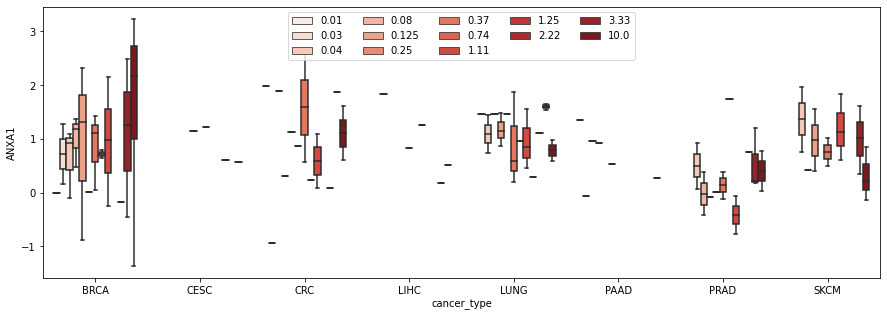

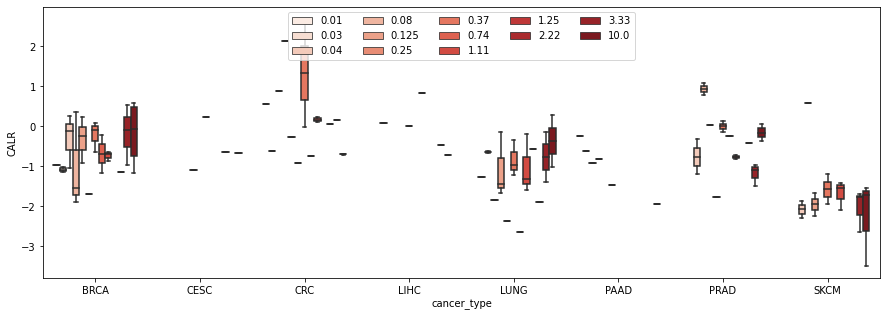

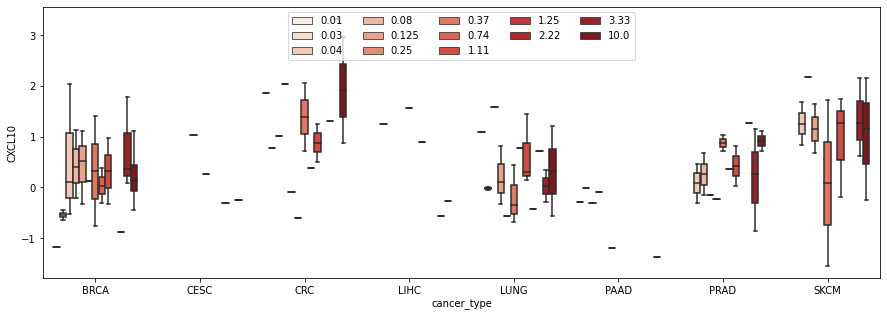

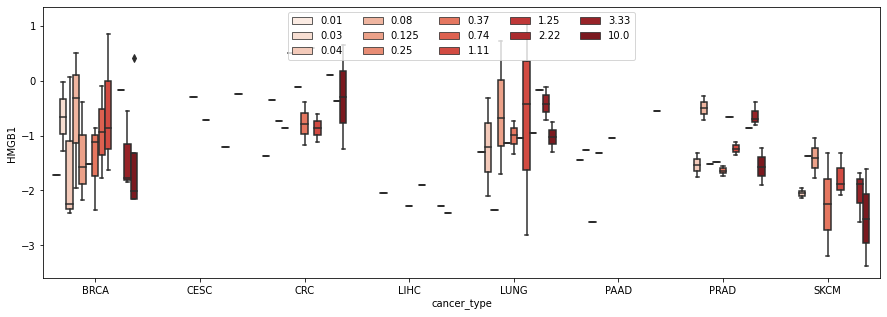

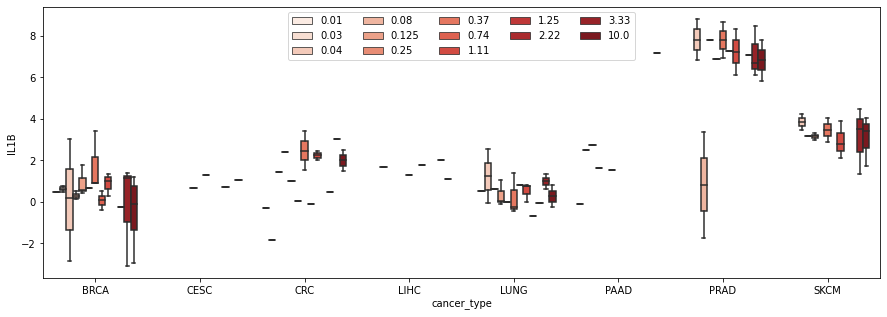

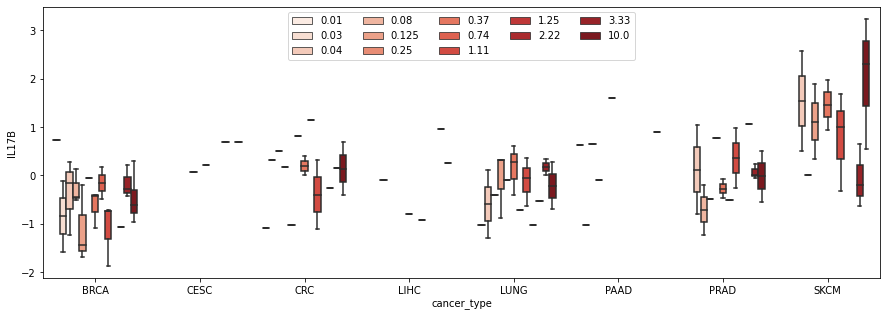

In [48]:
for g in icd_selected:
    plt.figure(figsize=(15, 5))
    sns.boxplot(x='cancer_type',
                y=g,
                hue='nearest_dose',
                palette='Reds',
                data=case_gemcitabine)
    plt.legend(loc='upper center', ncol=5)
    plt.show()

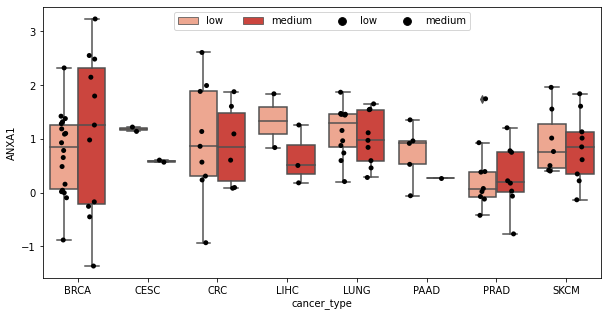

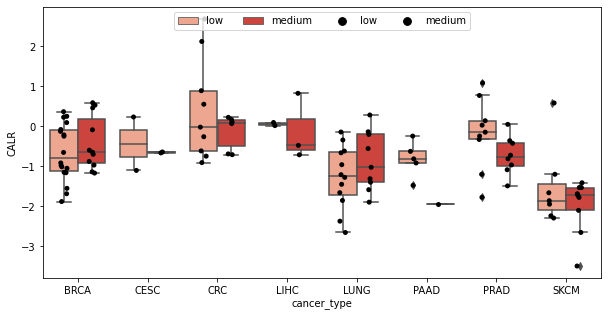

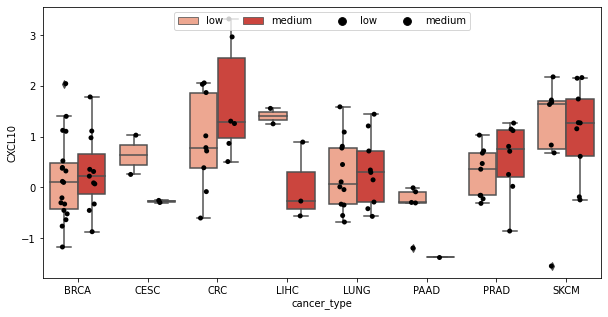

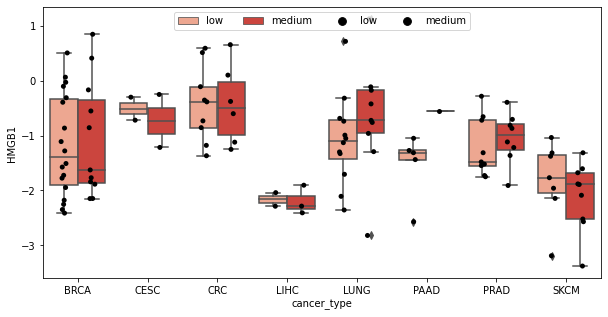

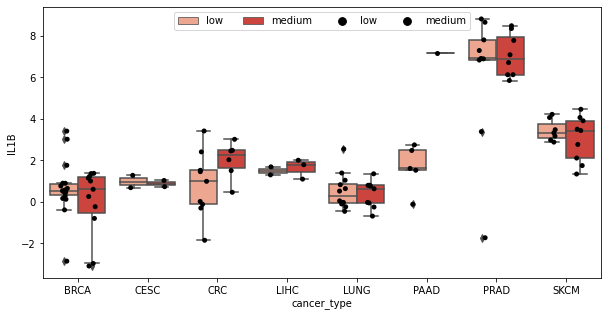

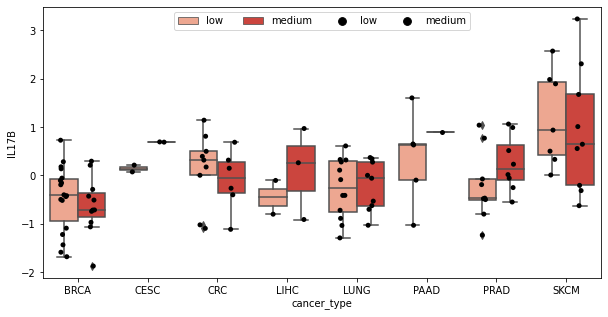

In [59]:
for g in icd_selected:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='cancer_type',
                y=g,
                hue='dose_cat',
                hue_order=['low', 'medium'],
                palette='Reds',
                data=case_gemcitabine)
    sns.stripplot(x='cancer_type',
                y=g,
                hue='dose_cat',
                dodge=True,
                hue_order=['low', 'medium'],
                palette={'low': 'k', 'medium': 'k'},
                data=case_gemcitabine)
    plt.legend(loc='upper center', ncol=5)
    plt.show()

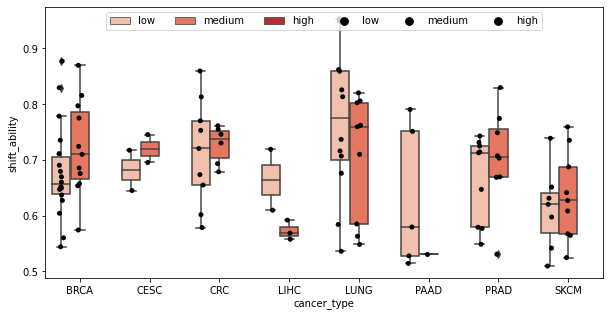

In [69]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='cancer_type',
            y='shift_ability',
            hue='dose_cat',
            hue_order=['low', 'medium', 'high'],
            palette='Reds',
            data=case_gemcitabine)
sns.stripplot(x='cancer_type',
              y='shift_ability',
              hue='dose_cat',
              dodge=True,
              hue_order=['low', 'medium', 'high'],
              palette={'low': 'k', 'medium': 'k', 'high': 'k'},
              data=case_gemcitabine)
plt.legend(loc='upper center', ncol=6)
plt.show()

## case: Mitoxantrome

In [63]:
case_mitoxantrone = icd_rs_expr_24h[icd_rs_expr_24h['cmap_name'] == 'mitoxantrone']

In [64]:
case_mitoxantrone

IL17B     ANXA1     HMGB1       IL1B  \
ABY001_SKBR3_XH:BRD-K21680192:2.5:24 -0.708493 -1.509188 -0.739603   2.333850   
ASG002_MCF7_24H:P07                   1.038529  0.401888  0.110752   2.316096   
ASG002_MCF7_24H:P08                   1.405661 -0.364544 -2.952728   2.187169   
ASG002_MCF7_24H:P09                   1.703136  0.168131 -1.652224  -0.124277   
ASG003_MCF7_24H:J10                   1.688480  1.534188  0.743493   4.948117   
...                                        ...       ...       ...        ...   
REP.B006_A375_24H:I13                 1.307850 -1.686800 -4.758050   8.198750   
REP.B006_A375_24H:I14                 0.514550 -0.655350 -3.828950  10.000000   
REP.B006_A375_24H:I15                 2.587100 -1.028750 -2.803400   8.958600   
REP.B006_A375_24H:I16                 0.687700 -1.704400 -2.426850   9.299900   
REP.B006_A375_24H:I17                 0.578900 -1.111600 -1.024700   9.499849   

                                        CXCL10      CALR cancer_type  time  \
ABY001_SKBR3_XH:BRD-K21680192:2.5:24  2.008200  1.216831        BRCA  24.0   
ASG002_MCF7_24H:P07                  -0.491109  1.229584        BRCA  24.0   
ASG002_MCF7_24H:P08                   2.233201 -2.244262        BRCA  24.0   
ASG002_MCF7_24H:P09                   1.467310 -0.319995        BRCA  24.0   
ASG003_MCF7_24H:J10                   0.124358  1.396607        BRCA  24.0   
...                                        ...       ...         ...   ...   
REP.B006_A375_24H:I13                -0.817250 -1.860300        SKCM  24.0   
REP.B006_A375_24H:I14                -1.132400 -0.854700        SKCM  24.0   
REP.B006_A375_24H:I15                -1.203650 -0.599100        SKCM  24.0   
REP.B006_A375_24H:I16                -0.266800  0.050750        SKCM  24.0   
REP.B006_A375_24H:I17                 1.288500 -0.877650        SKCM  24.0   

                                           tas cell_line  shift_ability  \
ABY001_SKBR3_XH:BRD-K21680192:2.5:24  0.636131     SKBR3       0.530530   
ASG002_MCF7_24H:P07                   0.696103      MCF7       0.544230   
ASG002_MCF7_24H:P08                   0.772229      MCF7       0.893477   
ASG002_MCF7_24H:P09                   0.539452      MCF7       0.786967   
ASG003_MCF7_24H:J10                   0.669644      MCF7       0.532448   
...                                        ...       ...            ...   
REP.B006_A375_24H:I13                 0.735001      A375       0.728191   
REP.B006_A375_24H:I14                 0.635406      A375       0.626348   
REP.B006_A375_24H:I15                 0.600518      A375       0.625864   
REP.B006_A375_24H:I16                 0.547882      A375       0.684363   
REP.B006_A375_24H:I17                 0.500266      A375       0.926008   

                                      NREC_score  REC_score dose_cat  \
ABY001_SKBR3_XH:BRD-K21680192:2.5:24   -0.263938   0.266592   medium   
ASG002_MCF7_24H:P07                    -0.232403   0.311827   medium   
ASG002_MCF7_24H:P08                    -0.446054   0.447423   medium   
ASG002_MCF7_24H:P09                    -0.436948   0.350019      low   
ASG003_MCF7_24H:J10                    -0.185038   0.347409   medium   
...                                          ...        ...      ...   
REP.B006_A375_24H:I13                  -0.413160   0.315031   medium   
REP.B006_A375_24H:I14                  -0.400308   0.226041      low   
REP.B006_A375_24H:I15                  -0.371240   0.254624      low   
REP.B006_A375_24H:I16                  -0.403957   0.280406      low   
REP.B006_A375_24H:I17                  -0.448564   0.477444      low   

                                       icd_ave  nearest_dose     cmap_name  
ABY001_SKBR3_XH:BRD-K21680192:2.5:24  0.433600          2.50  mitoxantrone  
ASG002_MCF7_24H:P07                   0.767623         10.00  mitoxantrone  
ASG002_MCF7_24H:P08                   0.044083          1.11  mitoxantrone  
ASG002_MCF7_24H:P09                   0.207014          0

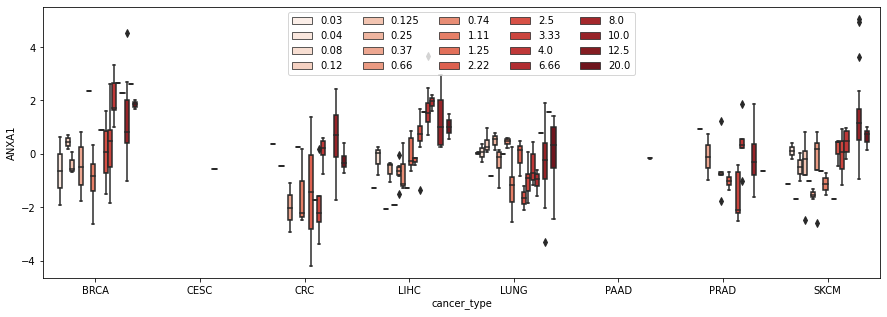

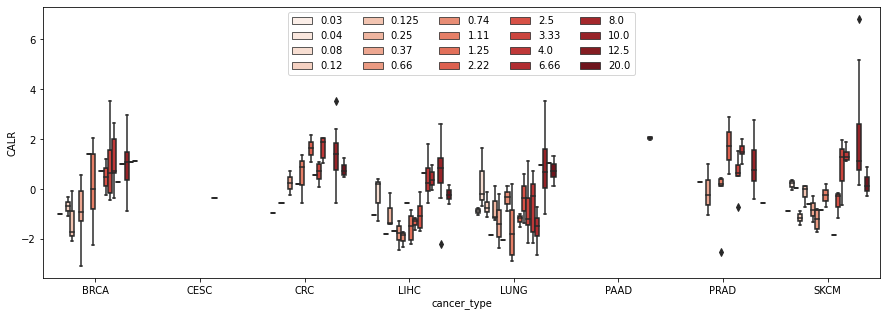

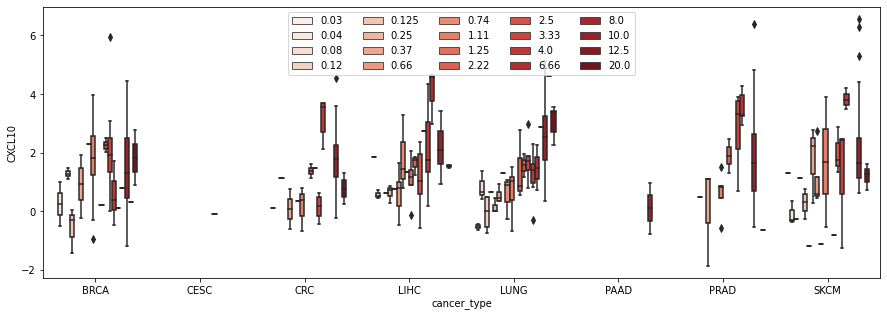

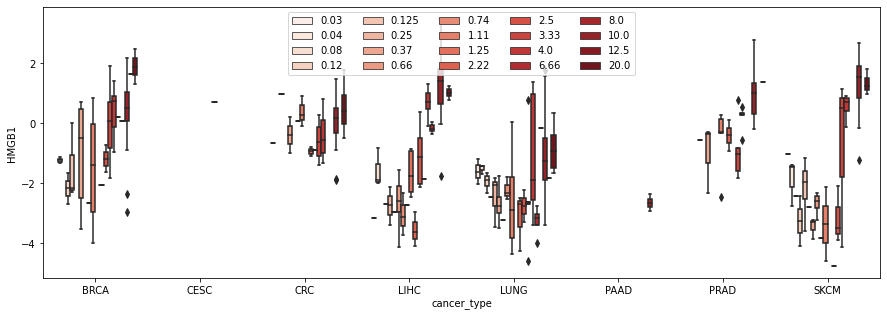

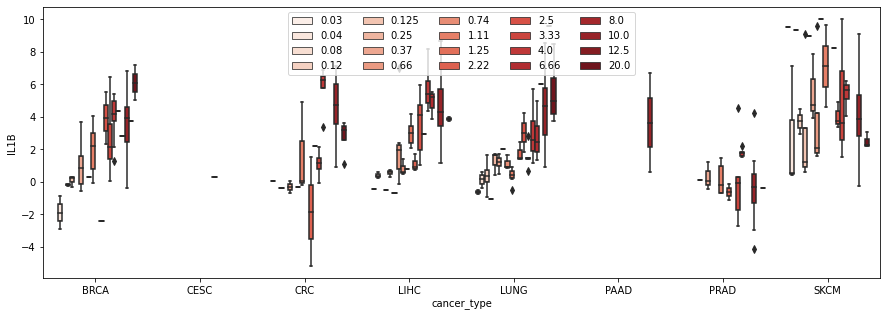

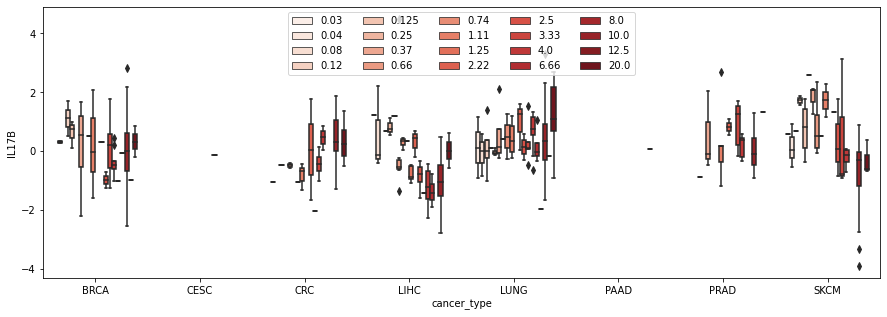

In [65]:
for g in icd_selected:
    plt.figure(figsize=(15, 5))
    sns.boxplot(x='cancer_type',
                y=g,
                hue='nearest_dose',
                palette='Reds',
                data=case_mitoxantrone)
    plt.legend(loc='upper center', ncol=5)
    plt.show()

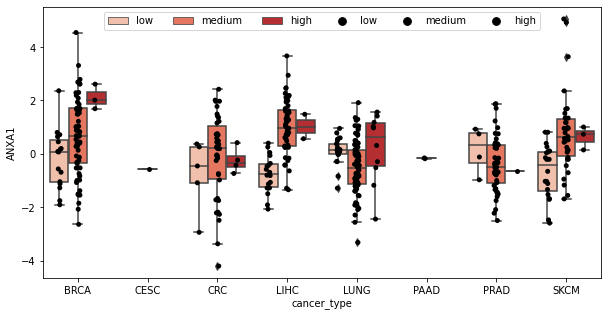

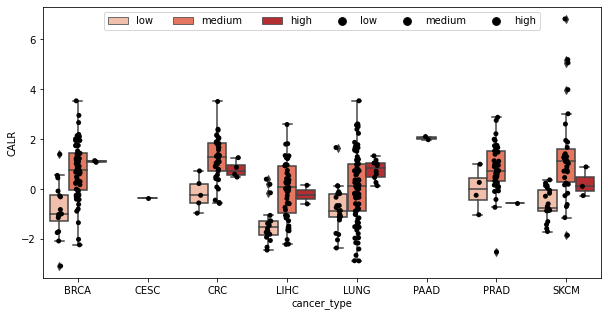

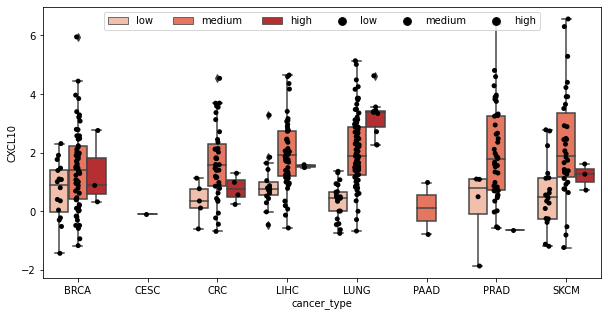

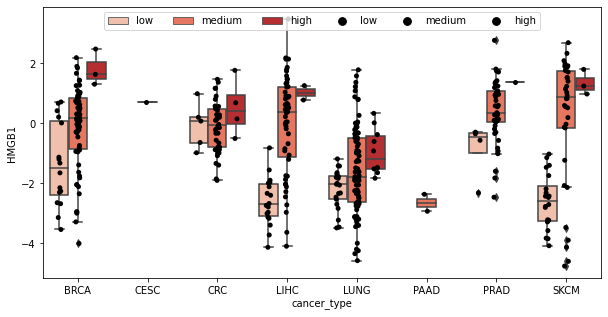

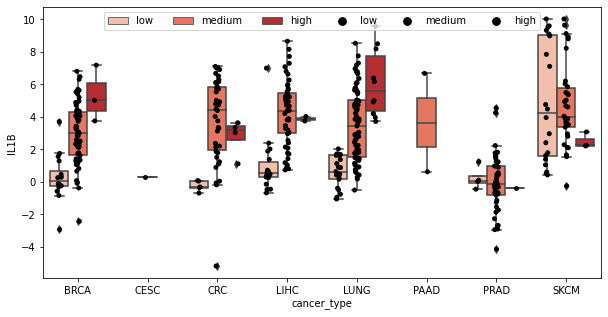

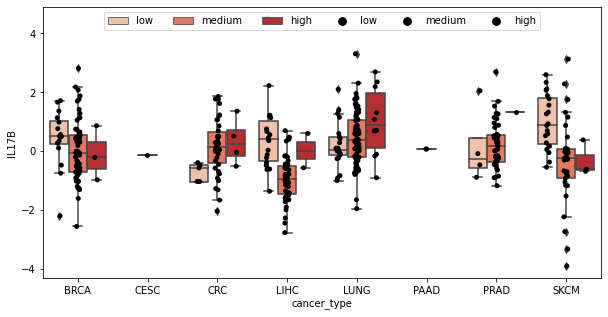

In [67]:
for g in icd_selected:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='cancer_type',
                y=g,
                hue='dose_cat',
                hue_order=['low', 'medium', 'high'],
                palette='Reds',
                data=case_mitoxantrone)
    sns.stripplot(x='cancer_type',
                y=g,
                hue='dose_cat',
                dodge=True,
                hue_order=['low', 'medium', 'high'],
                palette={'low': 'k', 'medium': 'k', 'high': 'k'},
                data=case_mitoxantrone)
    plt.legend(loc='upper center', ncol=6)
    plt.show()

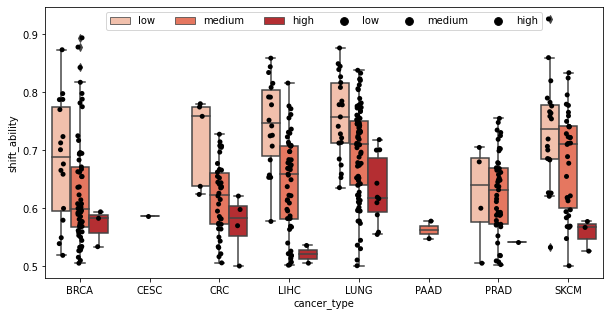

In [68]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='cancer_type',
            y='shift_ability',
            hue='dose_cat',
            hue_order=['low', 'medium', 'high'],
            palette='Reds',
            data=case_mitoxantrone)
sns.stripplot(x='cancer_type',
              y='shift_ability',
              hue='dose_cat',
              dodge=True,
              hue_order=['low', 'medium', 'high'],
              palette={'low': 'k', 'medium': 'k', 'high': 'k'},
              data=case_mitoxantrone)
plt.legend(loc='upper center', ncol=6)
plt.show()

# ICD expression in anti-PD1 treated patients (GSE96061)

In [215]:
# GSE91061 original expression
expr_91061 = pd.read_csv(data_home + 'GSE91061/GSE91061_BMS038109Sample.hg19KnownGene.fpkm.csv',
                          index_col=0, header=0, sep=',')
expr_91061 = expr_91061[expr_91061.index.isin(bing_landmark.index)]
expr_91061 = expr_91061.rename(index=bing_landmark['Official NCBI gene symbol'])

In [216]:
# read clinical information
info_91061 = pd.read_csv(data_home + 'GSE91061/GSE91061_patient_info.csv',
                          index_col=0, header=0, sep=',').T
print(expr_91061.shape, info_91061.shape)

# get the paired sample list
timepoint_91061 = df(columns=['Pre', 'On', 'response'])
for p in info_91061.index:
    tmp_cat = p.split('_')[1]
    tmp_p = p.split('_')[0]
    timepoint_91061.at[tmp_p, tmp_cat] = p
    timepoint_91061.at[tmp_p, 'response'] = info_91061.loc[p, 'response'].split(': ')[1]

# get the patients with paired samples
paired_91061 = timepoint_91061.dropna(axis=0, how='any')

print(timepoint_91061.shape, paired_91061.shape)

response_lut = {'PD': 'crimson', 'SD': 'royalblue', 'PRCR': 'cornflowerblue', 'UNK': 'grey'}
patient_color = df(index=info_91061.index, columns=['response', 'response_color', 'time', 'time_color'])
for p in paired_91061.index:
    patient_color.at[paired_91061.loc[p, 'Pre'], 'time'] = 'Pre'
    patient_color.at[paired_91061.loc[p, 'On'], 'time'] = 'On'
    patient_color.at[paired_91061.loc[p, 'Pre'], 'time_color'] = 'violet'
    patient_color.at[paired_91061.loc[p, 'On'], 'time_color'] = 'gold'
    patient_color.at[paired_91061.loc[p, 'Pre'], 'response'] = paired_91061.loc[p, 'response']
    patient_color.at[paired_91061.loc[p, 'On'], 'response'] = paired_91061.loc[p, 'response']
    patient_color.at[paired_91061.loc[p, 'Pre'], 'response_color'] = response_lut[paired_91061.loc[p, 'response']]
    patient_color.at[paired_91061.loc[p, 'On'], 'response_color'] = response_lut[paired_91061.loc[p, 'response']]
patient_color = patient_color.dropna(axis=0, how='any')

# add color for paired_91061
for p in paired_91061.index:
    paired_91061.at[p, 'response_color'] = response_lut[paired_91061.loc[p, 'response']]
    
log2exp2_91061 = np.log2(expr_91061 + 1) # log2FPKM

# collapse duplicates
log2exp2_91061 = log2exp2_91061.groupby(level=0).mean()

log2exp2_91061 = log2exp2_91061[log2exp2_91061 > 0.].dropna(axis=0, how='all').fillna(0.)
print(log2exp2_91061.shape)

(10158, 109) (109, 2)
(65, 3) (43, 3)
(10157, 109)


/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [218]:
expr_91061_ICD = log2exp2_91061[log2exp2_91061.index.isin(icd_selected)]

In [219]:
expr_91061_ICD 

Pt1_Pre_AD101148-6  Pt1_On_AD174047-6  Pt10_Pre_E9047565-6  \
ANXA1             5.821064           5.416090             4.678403   
CALR              8.905176           8.571550             8.202516   
CXCL10            6.767232           5.090576             4.233509   
HMGB1             5.651442           5.566538             6.283447   
IL17B             0.160097           0.052514             0.032147   
IL1B              3.069891           2.287121             0.788620   

        Pt10_On_E9047632-6  Pt101_Pre_AD486328-5  Pt101_On_AD681975-5  \
ANXA1             6.755931              5.636653             5.272251   
CALR              8.463237              8.112870             8.370153   
CXCL10            6.048156              6.977623             6.613041   
HMGB1             6.062115              6.487276             6.212228   
IL17B             0.333229              1.000666             0.326653   
IL1B              4.153247              3.614655             4.214383   

        Pt103_Pre_AE134058-2  Pt103_On_AE134059-6  Pt105_On_AE373241-6  \
ANXA1               6.898598             7.935824             4.978608   
CALR                8.044043             7.970261             8.506294   
CXCL10              6.337242             3.088375             9.511628   
HMGB1               5.293429             6.655968             5.729446   
IL17B               0.602504             0.118796             0.087525   
IL1B                1.672768             0.654384             2.051064   

        Pt106_Pre_AD502250-5  ...  Pt9_Pre_E9021024-6  Pt9_On_E9047644-7  \
ANXA1               7.657391  ...            5.896693           5.401070   
CALR                8.452910  ...            8.793863           8.753156   
CXCL10              6.096143  ...            2.978377           2.765100   
HMGB1               5.947779  ...            6.790410           6.819202   
IL17B               0.180972  ...            1.275619           1.468482   
IL1B                0.932913  ...            4.719196           3.335702   

        Pt90_Pre_AD467873-6  Pt92_Pre_AE134060-5  Pt92_On_AE148750-5  \
ANXA1              9.095132             7.204126            7.996560   
CALR               8.355321             9.053683            9.097948   
CXCL10             5.823426             8.478979           10.467771   
HMGB1              5.990292             6.168209            6.276127   
IL17B              0.000000             0.062106            0.300888   
IL1B               7.326380             1.529401            1.952260   

        Pt93_On_AE070988-5  Pt94_Pre_AD732850-6  Pt94_On_AE373242-6  \
ANXA1             3.566411             5.032374            4.316494   
CALR              8.616845             8.808217            8.436506   
CXCL10            3.992181             2.479184            5.758586   
HMGB1             6.287471             5.640898            5.120207   
IL17B             0.000000             0.575473            0.523678   
IL1B              0.449477             1.389601            1.191758   

        Pt98_Pre_AD733586-8  Pt98_On_AE086717-6  
ANXA1              3.745809            4.388794  
CALR               7.964997            8.131519  
CXCL10             3.087527            6.243125  
HMGB1              6.026724            5.992528  
IL17B              0.000000            0.107137  
IL1B               0.305990            1.338414  

[6 rows x 109 columns]

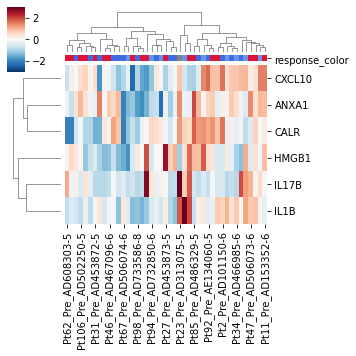

In [234]:
sns.clustermap(expr_91061_ICD[paired_91061['Pre']],
               figsize=(5, 5),
               cmap='RdBu_r',
               z_score=0,
               vmin=-3,
               vmax=3,
               method='ward',
               col_colors=patient_color['response_color'])
plt.show()

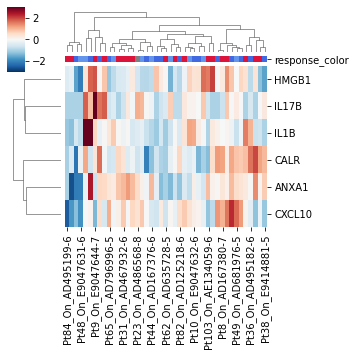

In [233]:
sns.clustermap(expr_91061_ICD[paired_91061['On']],
               figsize=(5, 5),
               cmap='RdBu_r',
               z_score=0,
               vmin=-3,
               vmax=3,
               method='ward',
               col_colors=patient_color['response_color'])
plt.show()

In [235]:
# differential between N and NR in On-treatment - Pre-treatment
expr_91061_ICD_fc = df(index=expr_91061_ICD.index, columns=paired_91061.index)
for p in expr_91061_ICD_fc.columns:
    expr_91061_ICD_fc[p] = expr_91061_ICD[paired_91061.loc[p, 'On']] - expr_91061_ICD[paired_91061.loc[p, 'Pre']]


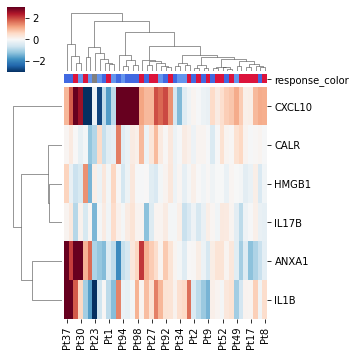

In [237]:
sns.clustermap(expr_91061_ICD_fc,
               figsize=(5, 5),
               cmap='RdBu_r',
               z_score=None,
               vmin=-3,
               vmax=3,
               method='ward',
               col_colors=paired_91061['response_color'])
plt.show()

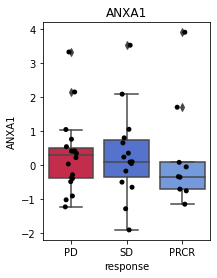

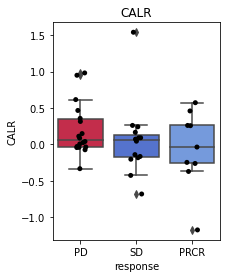

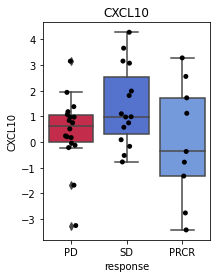

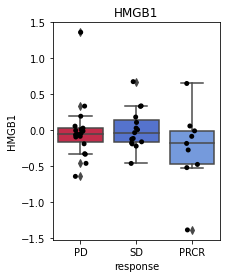

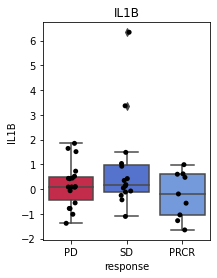

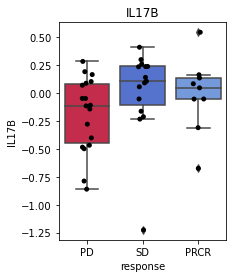

In [245]:
for g in icd_selected:
    plt.figure(figsize=(3, 4))
    tmp = df(expr_91061_ICD_fc.loc[g, :])
    tmp['response'] = paired_91061['response']
    tmp = tmp[tmp['response'] != 'UNK']
    sns.boxplot(x='response', y=g, data=tmp, palette=response_lut)
    sns.stripplot(x='response', y=g, data=tmp, color='k')
    plt.title(g)
    plt.show()

# CXCL10 centric analysis

In [250]:
# high doses killing the cells
# low doses induce CXCL10 expression (not necessary dose-dependent)

## 0. Drug response from CTRP

In [251]:
cmap2020_auc_merged_available = pd.read_csv(data_home + 'CTRP/merged_v21_v22_available_CMAP2020_CTRP_AUC.csv',
                                            index_col=0, header=0, sep=',')

In [252]:
# drug response
cmap2020_auc_merged_available

cell_line   drug_name  auc_CTRP_21  auc_CTRP_22
5637_3-Cl-AHPC           5637   3-Cl-AHPC       9.3751       9.3751
5637_ABT-737             5637     ABT-737      12.7460      12.7460
5637_AGK-2               5637       AGK-2      15.0000      15.0000
5637_AM-580              5637      AM-580      12.9170      12.9170
5637_AZ-3146             5637     AZ-3146      13.3030      13.3030
...                       ...         ...          ...          ...
NCIH2172_AZD-6482    NCIH2172    AZD-6482      14.3890      14.3890
NCIH2172_ixazomib    NCIH2172    ixazomib      14.0290      14.0290
NCIH2172_RAF-265     NCIH2172     RAF-265      13.2920      13.2920
NCIH2172_KU-0060648  NCIH2172  KU-0060648      12.6510      12.6510
NCIH2172_sonidegib   NCIH2172   sonidegib      15.4110      15.4110

[34551 rows x 4 columns]

In [254]:
cmap2020_auc_merged_available['auc_merged'] = (cmap2020_auc_merged_available['auc_CTRP_21'] + cmap2020_auc_merged_available['auc_CTRP_22']) / 2

In [255]:
cmap2020_auc_merged_available

cell_line   drug_name  auc_CTRP_21  auc_CTRP_22  \
5637_3-Cl-AHPC           5637   3-Cl-AHPC       9.3751       9.3751   
5637_ABT-737             5637     ABT-737      12.7460      12.7460   
5637_AGK-2               5637       AGK-2      15.0000      15.0000   
5637_AM-580              5637      AM-580      12.9170      12.9170   
5637_AZ-3146             5637     AZ-3146      13.3030      13.3030   
...                       ...         ...          ...          ...   
NCIH2172_AZD-6482    NCIH2172    AZD-6482      14.3890      14.3890   
NCIH2172_ixazomib    NCIH2172    ixazomib      14.0290      14.0290   
NCIH2172_RAF-265     NCIH2172     RAF-265      13.2920      13.2920   
NCIH2172_KU-0060648  NCIH2172  KU-0060648      12.6510      12.6510   
NCIH2172_sonidegib   NCIH2172   sonidegib      15.4110      15.4110   

                     auc_merged  
5637_3-Cl-AHPC           9.3751  
5637_ABT-737            12.7460  
5637_AGK-2              15.0000  
5637_AM-580             12.9170  
5637_AZ-3146            13.3030  
...                         ...  
NCIH2172_AZD-6482       14.3890  
NCIH2172_ixazomib       14.0290  
NCIH2172_RAF-265        13.2920  
NCIH2172_KU-0060648     12.6510  
NCIH2172_sonidegib      15.4110  

[34551 rows x 5 columns]

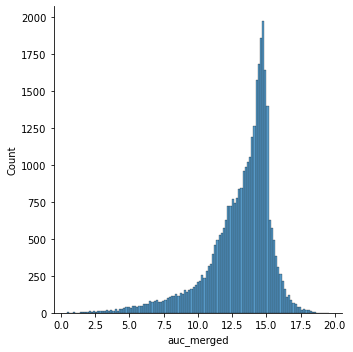

In [256]:
# distribution of auc
sns.displot(cmap2020_auc_merged_available['auc_merged'])

In [301]:
# sensitivity: scaled AUC to sensitivity score ranged in 0 - 1
cmap2020_sensitivity = df(cmap2020_auc_merged_available['cell_line'])
cmap2020_sensitivity['drug_name'] = cmap2020_auc_merged_available['drug_name']
cmap2020_sensitivity['AUC'] = cmap2020_auc_merged_available['auc_merged']
cmap2020_sensitivity['sensitivity'] = 1 - cmap2020_auc_merged_available['auc_merged'] / 20

In [302]:
cmap2020_sensitivity['sensitivity'].describe()

count    34551.000000
mean         0.345860
std          0.119399
min          0.020600
25%          0.265900
50%          0.313400
75%          0.395625
max          0.978804
Name: sensitivity, dtype: float64

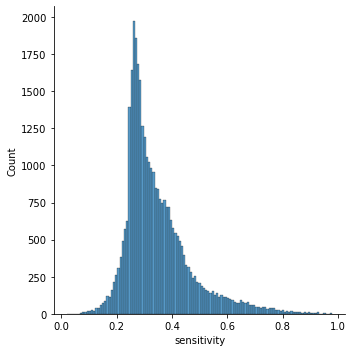

In [303]:
sns.displot(cmap2020_sensitivity['sensitivity'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]),
 [Text(0, 0, '5637'),
  Text(1, 0, '22RV1'),
  Text(2, 0, 'A204'),
  Text(3, 0, 'A375'),
  Text(4, 0, 'A549'),
  Text(5, 0, 'A673'),
  Text(6, 0, 'AGS'),
  Text(7, 0, 'AN3CA'),
  Text(8, 0, 'BC3C'),
  Text(9, 0, 'BEN'),
  Text(10, 0, 'BICR6'),
  Text(11, 0, 'BT20'),
  Text(12, 0, 'BT474'),
  Text(13, 0, 'CAL29'),
  Text(14, 0, 'CJM'),
  Text(15, 0, 'CL34'),
  Text(16, 0, 'COV434'),
  Text(17, 0, 'COV644'),
  Text(18, 0, 'CW2'),
  Text(19, 0, 'DLD1'),
  Text(20, 0, 'DU145'),
  Text(21, 0, 'DV90'),
  Text(22, 0, 'EFO27'),
  Text(23, 0, 'ES2'),
  Text(24, 0, 'G40

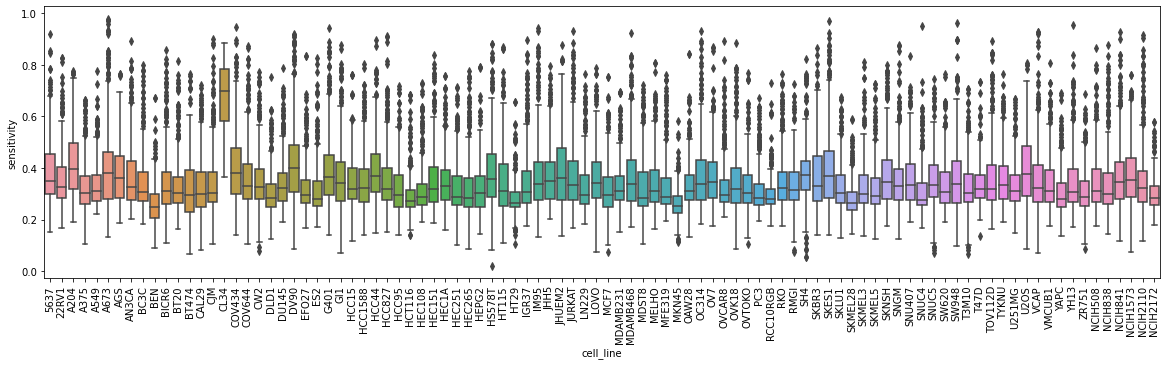

In [298]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='cell_line', y='sensitivity', data=cmap2020_sensitivity)
plt.xticks(rotation=90)

In [306]:
# add moa to sensitivity matrix
cmap2020_sensitivity['moa'] = 'Not available'
for i in cmap2020_sensitivity.index:
    cmap2020_sensitivity.at[i, 'moa'] = compound_info.loc[cmap2020_sensitivity.loc[i, 'drug_name'], 'moa']

In [307]:
cmap2020_sensitivity['moa'] = cmap2020_sensitivity['moa'].fillna('Not available')

In [309]:
for c in cmap2020_sensitivity['cell_line'].unique():
    tmp = cmap2020_sensitivity[cmap2020_sensitivity['cell_line'] == c]
    
    # show top sensitive moa
    tmp = tmp.sort_values(by='sensitivity', ascending=False)
    print(c)
    print(tmp[:20]['moa'].unique())

5637
['Tubulin inhibitor' 'Kinesin-like spindle protein inhibitor'
 'KIT inhibitor' 'HDAC inhibitor' 'Not available' 'PLK inhibitor'
 'ATPase inhibitor' 'Topoisomerase inhibitor' 'EGFR inhibitor'
 'LIM kinase activator' 'Aurora kinase inhibitor'
 'Dihydrofolate reductase inhibitor']
22RV1
['HDAC inhibitor' 'Not available' 'Kinesin-like spindle protein inhibitor'
 'Tubulin inhibitor' 'ATPase inhibitor' 'Topoisomerase inhibitor'
 'PLK inhibitor' 'Ribonucleotide reductase inhibitor'
 'Dihydrofolate reductase inhibitor' 'LIM kinase activator'
 'MTOR inhibitor']
A204
['ATPase inhibitor' 'Not available' 'HDAC inhibitor' 'FGFR inhibitor'
 'CDK inhibitor' 'Dihydrofolate reductase inhibitor'
 'P21 activated kinase inhibitor' 'VEGFR inhibitor'
 'Topoisomerase inhibitor' 'PLK inhibitor'
 'Ribonucleotide reductase inhibitor' 'Tubulin inhibitor' 'KIT inhibitor'
 'PDGFR inhibitor' 'LIM kinase activator']
A375
['Not available' 'HDAC inhibitor' 'Kinesin-like spindle protein inhibitor'
 'Exportin antag

In [314]:
cmap2020_sensitivity[cmap2020_sensitivity['drug_name'] == 'tamoxifen'].sort_values(by='sensitivity', ascending=False)

cell_line  drug_name     AUC  sensitivity  \
HCC1588_tamoxifen   HCC1588  tamoxifen  10.166      0.49170   
COV434_tamoxifen     COV434  tamoxifen  11.594      0.42030   
CAL29_tamoxifen       CAL29  tamoxifen  12.088      0.39560   
A204_tamoxifen         A204  tamoxifen  12.168      0.39160   
BEN_tamoxifen           BEN  tamoxifen  12.242      0.38790   
...                     ...        ...     ...          ...   
MDST8_tamoxifen       MDST8  tamoxifen  15.522      0.22390   
CW2_tamoxifen           CW2  tamoxifen  15.567      0.22165   
HEPG2_tamoxifen       HEPG2  tamoxifen  15.744      0.21280   
JURKAT_tamoxifen     JURKAT  tamoxifen  16.044      0.19780   
GI1_tamoxifen           GI1  tamoxifen  16.760      0.16200   

                                            moa  
HCC1588_tamoxifen  Estrogen receptor antagonist  
COV434_tamoxifen   Estrogen receptor antagonist  
CAL29_tamoxifen    Estrogen receptor antagonist  
A204_tamoxifen     Estrogen receptor antagonist  
BEN_tamoxifen      Estrogen receptor antagonist  
...                                         ...  
MDST8_tamoxifen    Estrogen receptor antagonist  
CW2_tamoxifen      Estrogen receptor antagonist  
HEPG2_tamoxifen    Estrogen receptor antagonist  
JURKAT_tamoxifen   Estrogen receptor antagonist  
GI1_tamoxifen      Estrogen receptor antagonist  

[90 rows x 5 columns]

In [315]:
cmap2020_sensitivity.loc['MCF7_tamoxifen', :]

cell_line                              MCF7
drug_name                         tamoxifen
AUC                                  12.736
sensitivity                          0.3632
moa            Estrogen receptor antagonist
Name: MCF7_tamoxifen, dtype: object

In [316]:
cmap2020_sensitivity.loc['T47D_tamoxifen', :]

cell_line                              T47D
drug_name                         tamoxifen
AUC                                  12.249
sensitivity                         0.38755
moa            Estrogen receptor antagonist
Name: T47D_tamoxifen, dtype: object

In [317]:
cmap2020_sensitivity.loc['BT20_tamoxifen', :]

cell_line                              BT20
drug_name                         tamoxifen
AUC                                  14.312
sensitivity                          0.2844
moa            Estrogen receptor antagonist
Name: BT20_tamoxifen, dtype: object

In [318]:
cmap2020_sensitivity.loc['MDAMB231_tamoxifen', :]

cell_line                          MDAMB231
drug_name                         tamoxifen
AUC                                  14.441
sensitivity                         0.27795
moa            Estrogen receptor antagonist
Name: MDAMB231_tamoxifen, dtype: object

In [578]:
cmap2020_sensitivity[cmap2020_sensitivity['drug_name'] == 'PF-03758309'].sort_values(by='sensitivity', ascending=False)

cell_line    drug_name       AUC  sensitivity  \
A673_PF-03758309          A673  PF-03758309   3.61890     0.819055   
DV90_PF-03758309          DV90  PF-03758309   3.64630     0.817685   
COV434_PF-03758309      COV434  PF-03758309   4.13350     0.793325   
G401_PF-03758309          G401  PF-03758309   4.14760     0.792620   
A204_PF-03758309          A204  PF-03758309   5.25620     0.737190   
SH4_PF-03758309            SH4  PF-03758309   5.43550     0.728225   
SKES1_PF-03758309        SKES1  PF-03758309   5.57810     0.721095   
COV644_PF-03758309      COV644  PF-03758309   5.63700     0.718150   
OC314_PF-03758309        OC314  PF-03758309   5.89480     0.705260   
IM95_PF-03758309          IM95  PF-03758309   6.21050     0.689475   
BICR6_PF-03758309        BICR6  PF-03758309   6.67910     0.666045   
MDAMB468_PF-03758309  MDAMB468  PF-03758309   6.67980     0.666010   
VCAP_PF-03758309          VCAP  PF-03758309   7.40130     0.629935   
AN3CA_PF-03758309        AN3CA  PF-03758309   7.62590     0.618705   
HS578T_PF-03758309      HS578T  PF-03758309   7.81570     0.609215   
GI1_PF-03758309            GI1  PF-03758309   7.94550     0.602725   
SW948_PF-03758309        SW948  PF-03758309   8.16890     0.591555   
SKNSH_PF-03758309        SKNSH  PF-03758309   8.36800     0.581600   
NCIH841_PF-03758309    NCIH841  PF-03758309   8.38220     0.580890   
HEC1A_PF-03758309        HEC1A  PF-03758309   8.80550     0.559725   
YH13_PF-03758309          YH13  PF-03758309   8.92260     0.553870   
JHH5_PF-03758309          JHH5  PF-03758309   8.96050     0.551975   
NCIH2110_PF-03758309  NCIH2110  PF-03758309   9.42970     0.528515   
SKBR3_PF-03758309        SKBR3  PF-03758309   9.47050     0.526475   
OV7_PF-03758309            OV7  PF-03758309   9.52020     0.523990   
SKMEL3_PF-03758309      SKMEL3  PF-03758309   9.56220     0.521890   
TOV112D_PF-03758309    TOV112D  PF-03758309   9.58180     0.520910   
NCIH838_PF-03758309    NCIH838  PF-03758309   9.72520     0.513740   
U251MG_PF-03758309      U251MG  PF-03758309   9.82490     0.508755   
PC3_PF-03758309            PC3  PF-03758309   9.89630     0.505185   
OAW28_PF-03758309        OAW28  PF-03758309  10.61900     0.469050   
EFO27_PF-03758309        EFO27  PF-03758309  10.90300     0.454850   
MFE319_PF-03758309      MFE319  PF-03758309  11.19500     0.440250   
BT474_PF-03758309        BT474  PF-03758309  11.23000     0.438500   
IGR37_PF-03758309        IGR37  PF-03758309  11.35400     0.432300   
DU145_PF-03758309        DU145  PF-03758309  11.44025     0.427988   
BT20_PF-03758309          BT20  PF-03758309  11.79900     0.410050   
BC3C_PF-03758309          BC3C  PF-03758309  11.80800     0.409600   
T47D_PF-03758309          T47D  PF-03758309  11.98900     0.400550   
CJM_PF-03758309            CJM  PF-03758309  12.08600     0.395700   
T3M10_PF-03758309        T3M10  PF-03758309  12.58100     0.370950   
RCC10RGB_PF-03758309  RCC10RGB  PF-03758309  13.12500     0.343750   
SNUC4_PF-03758309        SNUC4  PF-03758309  13.22100     0.338950   

                                                 moa cat_sensitivity  
A673_PF-03758309      P21 activated kinase inhibitor       sensitive  
DV90_PF-03758309      P21 activated kinase inhibitor       sensitive  
COV434_PF-03758309    P21 activated kinase inhibitor       sensitive  
G401_PF-03758309      P21 activated kinase inhibitor       sensitive  
A204_PF-03758309      P21 activated kinase inhibitor       sensitive  
SH4_PF-03758309       P21 activated kinase inhibitor       sensitive  
SKES1_PF-03758309     P21 activated kinase inhibitor       sensitive  
COV644_PF-03758309    P21 activated kinase inhibitor       sensitive  
OC314_PF-03758309     P21 activated kinase inhibitor       sensitive  
IM95_PF-03758309      P21 activated kinase inhibitor       sensitive  
BICR6_PF-03758309     P21 activated kinase inhibitor       sensitive  
MDAMB468_PF-03758309  P21 activated kinase inhibitor     insensitive  
VCAP_PF-03758309 

In [579]:
cmap2020_sensitivity[cmap2020_sensitivity['drug_name'] == 'tamoxifen'].sort_values(by='sensitivity', ascending=False)

cell_line  drug_name     AUC  sensitivity  \
HCC1588_tamoxifen   HCC1588  tamoxifen  10.166      0.49170   
COV434_tamoxifen     COV434  tamoxifen  11.594      0.42030   
CAL29_tamoxifen       CAL29  tamoxifen  12.088      0.39560   
A204_tamoxifen         A204  tamoxifen  12.168      0.39160   
BEN_tamoxifen           BEN  tamoxifen  12.242      0.38790   
...                     ...        ...     ...          ...   
MDST8_tamoxifen       MDST8  tamoxifen  15.522      0.22390   
CW2_tamoxifen           CW2  tamoxifen  15.567      0.22165   
HEPG2_tamoxifen       HEPG2  tamoxifen  15.744      0.21280   
JURKAT_tamoxifen     JURKAT  tamoxifen  16.044      0.19780   
GI1_tamoxifen           GI1  tamoxifen  16.760      0.16200   

                                            moa cat_sensitivity  
HCC1588_tamoxifen  Estrogen receptor antagonist       sensitive  
COV434_tamoxifen   Estrogen receptor antagonist       sensitive  
CAL29_tamoxifen    Estrogen receptor antagonist       sensitive  
A204_tamoxifen     Estrogen receptor antagonist       sensitive  
BEN_tamoxifen      Estrogen receptor antagonist       sensitive  
...                                         ...             ...  
MDST8_tamoxifen    Estrogen receptor antagonist       resistant  
CW2_tamoxifen      Estrogen receptor antagonist       resistant  
HEPG2_tamoxifen    Estrogen receptor antagonist       resistant  
JURKAT_tamoxifen   Estrogen receptor antagonist       resistant  
GI1_tamoxifen      Estrogen receptor antagonist       resistant  

[90 rows x 6 columns]

In [580]:
cmap2020_sensitivity[cmap2020_sensitivity['drug_name'] == 'vorinostat'].sort_values(by='sensitivity', ascending=False)

cell_line   drug_name     AUC  sensitivity  \
U2OS_vorinostat          U2OS  vorinostat  10.139      0.49305   
HCC44_vorinostat        HCC44  vorinostat  10.192      0.49040   
JURKAT_vorinostat      JURKAT  vorinostat  10.276      0.48620   
DV90_vorinostat          DV90  vorinostat  10.355      0.48225   
22RV1_vorinostat        22RV1  vorinostat  10.418      0.47910   
...                       ...         ...     ...          ...   
NCIH1573_vorinostat  NCIH1573  vorinostat  13.444      0.32780   
SKMEL28_vorinostat    SKMEL28  vorinostat  14.042      0.29790   
PC3_vorinostat            PC3  vorinostat  14.237      0.28815   
MKN45_vorinostat        MKN45  vorinostat  14.487      0.27565   
CJM_vorinostat            CJM  vorinostat  14.556      0.27220   

                                moa cat_sensitivity  
U2OS_vorinostat      HDAC inhibitor       sensitive  
HCC44_vorinostat     HDAC inhibitor       sensitive  
JURKAT_vorinostat    HDAC inhibitor       sensitive  
DV90_vorinostat      HDAC inhibitor       sensitive  
22RV1_vorinostat     HDAC inhibitor       sensitive  
...                             ...             ...  
NCIH1573_vorinostat  HDAC inhibitor       resistant  
SKMEL28_vorinostat   HDAC inhibitor       resistant  
PC3_vorinostat       HDAC inhibitor       resistant  
MKN45_vorinostat     HDAC inhibitor       resistant  
CJM_vorinostat       HDAC inhibitor       resistant  

[94 rows x 6 columns]

In [581]:
cmap2020_sensitivity[cmap2020_sensitivity['drug_name'] == 'bortezomib'].sort_values(by='sensitivity', ascending=False)

cell_line   drug_name      AUC  sensitivity  \
SKNSH_bortezomib        SKNSH  bortezomib   9.6885     0.515575   
JHUEM2_bortezomib      JHUEM2  bortezomib   9.9919     0.500405   
MDAMB468_bortezomib  MDAMB468  bortezomib  10.4570     0.477150   
COV644_bortezomib      COV644  bortezomib  10.5550     0.472250   
OV7_bortezomib            OV7  bortezomib  10.6210     0.468950   
...                       ...         ...      ...          ...   
RCC10RGB_bortezomib  RCC10RGB  bortezomib  14.2370     0.288150   
MCF7_bortezomib          MCF7  bortezomib  14.2420     0.287900   
NCIH2172_bortezomib  NCIH2172  bortezomib  14.2430     0.287850   
BEN_bortezomib            BEN  bortezomib  14.6810     0.265950   
ZR751_bortezomib        ZR751  bortezomib  16.2150     0.189250   

                                      moa cat_sensitivity  
SKNSH_bortezomib     Proteasome inhibitor       sensitive  
JHUEM2_bortezomib    Proteasome inhibitor       sensitive  
MDAMB468_bortezomib  Proteasome inhibitor       sensitive  
COV644_bortezomib    Proteasome inhibitor       sensitive  
OV7_bortezomib       Proteasome inhibitor       sensitive  
...                                   ...             ...  
RCC10RGB_bortezomib  Proteasome inhibitor       resistant  
MCF7_bortezomib      Proteasome inhibitor       resistant  
NCIH2172_bortezomib  Proteasome inhibitor       resistant  
BEN_bortezomib       Proteasome inhibitor       resistant  
ZR751_bortezomib     Proteasome inhibitor       resistant  

[95 rows x 6 columns]

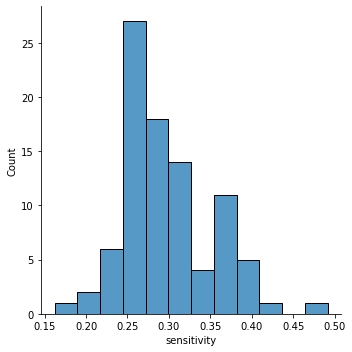

In [320]:
sns.displot(cmap2020_sensitivity[cmap2020_sensitivity['drug_name'] == 'tamoxifen']['sensitivity'])

In [321]:
cmap2020_sensitivity[cmap2020_sensitivity['drug_name'] == 'tamoxifen']['sensitivity'].describe()

count    90.000000
mean      0.297092
std       0.054453
min       0.162000
25%       0.261763
50%       0.281750
75%       0.325500
max       0.491700
Name: sensitivity, dtype: float64

In [331]:
# for each drug, cells with top 25% sensitivity (75%) will be taken as 'drug sensitive cell lines'
# 25%-75%: not sensitive
# 75%: resistant (bottom 25%)

cmap2020_sensitivity['cat_sensitivity'] = 'insensitive'
for d in cmap2020_sensitivity['drug_name'].unique():
    tmp = cmap2020_sensitivity[cmap2020_sensitivity['drug_name'] == d]
    cmap2020_sensitivity.at[tmp[tmp['sensitivity'] > tmp['sensitivity'].quantile(.75)].index, 'cat_sensitivity'] = 'sensitive'
    cmap2020_sensitivity.at[tmp[tmp['sensitivity'] <= tmp['sensitivity'].quantile(.25)].index, 'cat_sensitivity'] = 'resistant'

In [332]:
cmap2020_sensitivity

cell_line   drug_name      AUC  sensitivity  \
5637_3-Cl-AHPC           5637   3-Cl-AHPC   9.3751     0.531245   
5637_ABT-737             5637     ABT-737  12.7460     0.362700   
5637_AGK-2               5637       AGK-2  15.0000     0.250000   
5637_AM-580              5637      AM-580  12.9170     0.354150   
5637_AZ-3146             5637     AZ-3146  13.3030     0.334850   
...                       ...         ...      ...          ...   
NCIH2172_AZD-6482    NCIH2172    AZD-6482  14.3890     0.280550   
NCIH2172_ixazomib    NCIH2172    ixazomib  14.0290     0.298550   
NCIH2172_RAF-265     NCIH2172     RAF-265  13.2920     0.335400   
NCIH2172_KU-0060648  NCIH2172  KU-0060648  12.6510     0.367450   
NCIH2172_sonidegib   NCIH2172   sonidegib  15.4110     0.229450   

                                                moa cat_sensitivity  
5637_3-Cl-AHPC                        Not available       sensitive  
5637_ABT-737                          BCL inhibitor       sensitive  
5637_AGK-2                           SIRT inhibitor     insensitive  
5637_AM-580               Retinoid receptor agonist     insensitive  
5637_AZ-3146                          Not available     insensitive  
...                                             ...             ...  
NCIH2172_AZD-6482                    PI3K inhibitor       resistant  
NCIH2172_ixazomib              Proteasome inhibitor       resistant  
NCIH2172_RAF-265                      Not available       resistant  
NCIH2172_KU-0060648                  PI3K inhibitor     insensitive  
NCIH2172_sonidegib   Smoothened receptor antagonist       resistant  

[34551 rows x 6 columns]

<AxesSubplot:xlabel='cat_sensitivity', ylabel='sensitivity'>

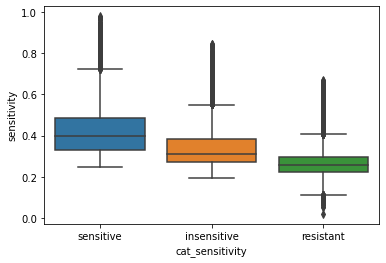

In [333]:
sns.boxplot(x='cat_sensitivity', y='sensitivity', data=cmap2020_sensitivity)

In [404]:
cmap2020_sensitivity['cat_sensitivity'].value_counts()

insensitive    16983
resistant       8861
sensitive       8707
Name: cat_sensitivity, dtype: int64

### 0.1 relationship between dosage and tas, along with sensitivity

<AxesSubplot:xlabel='nearest_dose', ylabel='tas'>

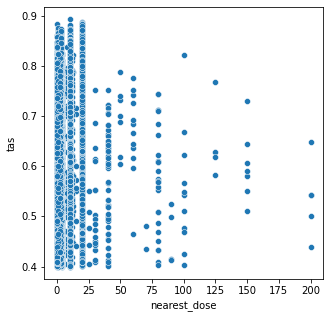

In [282]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='nearest_dose', y='tas', data=icd_rs_expr_24h)

In [337]:
# add drug response cat to matrix
icd_rs_expr_24h['cat_response'] = 'Not available'
for i in icd_rs_expr_24h.index:
    tmp_name = str(icd_rs_expr_24h.loc[i, 'cell_line']) + '_' + str(icd_rs_expr_24h.loc[i, 'cmap_name'])
    if tmp_name in cmap2020_sensitivity.index:
        icd_rs_expr_24h.at[i, 'cat_response'] = cmap2020_sensitivity.loc[tmp_name, 'cat_sensitivity']

In [341]:
# with ctrp response available
icd_rs_ctrp = icd_rs_expr_24h[icd_rs_expr_24h['cat_response'] != 'Not available']

In [405]:
icd_rs_ctrp.shape

(4270, 18)

In [414]:
icd_rs_ctrp['cat_response'].value_counts()

insensitive    1943
resistant      1620
sensitive       707
Name: cat_response, dtype: int64

<AxesSubplot:xlabel='cat_response', ylabel='tas'>

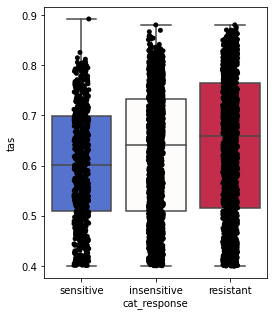

In [345]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='tas',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=icd_rs_ctrp)
sns.stripplot(x='cat_response', y='tas', color='k', data=icd_rs_ctrp)

<AxesSubplot:xlabel='cat_response', ylabel='tas'>

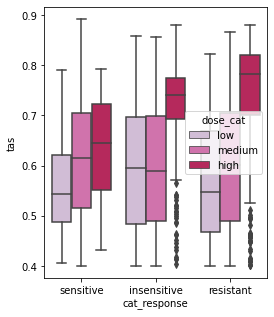

In [407]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='tas',
            hue='dose_cat',
            palette='PuRd',
            data=icd_rs_ctrp)

<AxesSubplot:xlabel='cat_response', ylabel='shift_ability'>

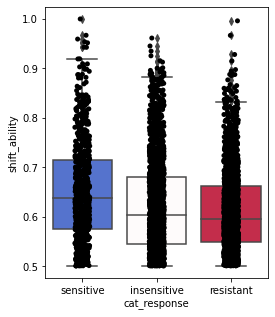

In [421]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='shift_ability',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=icd_rs_ctrp)
sns.stripplot(x='cat_response', y='shift_ability', color='k', data=icd_rs_ctrp)

<AxesSubplot:xlabel='cat_response', ylabel='shift_ability'>

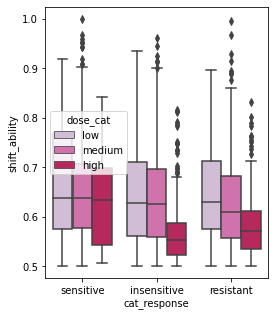

In [422]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='shift_ability',
            hue='dose_cat',
            palette='PuRd',
            data=icd_rs_ctrp)

### 0.2 Dosage dependence of sensitive pairs and resistant pairs

In [443]:
dose_dep_res = dose_dep_icd_rs_g24[dose_dep_icd_rs_g24.index.isin(cmap2020_sensitivity.index)]

In [446]:
dose_dep_res['cat_response'] = cmap2020_sensitivity['cat_sensitivity']
dose_dep_res['CTRP_auc'] = cmap2020_sensitivity['AUC']

<ipython-input-446-337318e80a86>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dose_dep_res['cat_response'] = cmap2020_sensitivity['cat_sensitivity']
<ipython-input-446-337318e80a86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dose_dep_res['CTRP_auc'] = cmap2020_sensitivity['AUC']


In [447]:
dose_dep_res

shift_r   shift_p     rec_r     rec_p    nrec_r  \
SKBR3_afatinib       0.085714  0.871743 -0.257143  0.622787 -0.085714   
SKBR3_neratinib     -0.175734  0.651084  0.435150  0.241757  0.661094   
SKBR3_NVP-BEZ235    -0.600000  0.284757 -0.600000  0.284757  0.700000   
SKBR3_alvocidib     -0.600000  0.284757 -0.700000  0.188120 -0.600000   
MCF7_RITA           -0.223607  0.717686  0.111803  0.857945  0.447214   
...                       ...       ...       ...       ...       ...   
SKMEL5_sirolimus     0.782624  0.117614 -0.111803  0.857945 -0.894427   
SKMEL5_vorinostat   -0.881917  0.003760 -0.793725  0.018688  0.352767   
SKMEL5_selumetinib   0.900000  0.037386  0.600000  0.284757 -0.900000   
SKMEL5_bortezomib    0.126592  0.745527  0.126592  0.745527  0.253185   
SKMEL5_tanespimycin -0.300000  0.623838 -0.300000  0.623838  0.000000   

                       nrec_p  icd_ave_r  icd_ave_p   ANXA1_r   ANXA1_p  ...  \
SKBR3_afatinib       0.871743   0.371429   0.468478 -0.485714  0.328723  ...   
SKBR3_neratinib      0.052523   0.217575   0.573875 -0.460255  0.212522  ...   
SKBR3_NVP-BEZ235     0.188120  -0.600000   0.284757  0.100000  0.872889  ...   
SKBR3_alvocidib      0.284757   0.100000   0.872889  0.800000  0.104088  ...   
MCF7_RITA            0.450185  -0.223607   0.717686  0.335410  0.581091  ...   
...                       ...        ...        ...       ...       ...  ...   
SKMEL5_sirolimus     0.040519  -0.335410   0.581091 -0.223607  0.717686  ...   
SKMEL5_vorinostat    0.391388   0.881917   0.003760  0.655138  0.077844  ...   
SKMEL5_selumetinib   0.037386   0.200000   0.747060  0.200000  0.747060  ...   
SKMEL5_bortezomib    0.510980   0.970542   0.000014  0.903026  0.000849  ...   
SKMEL5_tanespimycin  1.000000   0.300000   0.623838 -0.100000  0.872889  ...   

                      IL17B_r   IL17B_p  cancer_type  cell_line     cmap_name  \
SKBR3_afatinib      -0.142857  0.787172         BRCA      SKBR3      afatinib   
SKBR3_neratinib      0.000000  1.000000         BRCA      SKBR3     neratinib   
SKBR3_NVP-BEZ235     0.100000  0.872889         BRCA      SKBR3    NVP-BEZ235   
SKBR3_alvocidib     -0.100000  0.872889         BRCA      SKBR3     alvocidib   
MCF7_RITA           -0.447214  0.450185         BRCA       MCF7          RITA   
...                       ...       ...          ...        ...           ...   
SKMEL5_sirolimus    -0.111803  0.857945         SKCM     SKMEL5     sirolimus   
SKMEL5_vorinostat    0.390563  0.338756         SKCM     SKMEL5    vorinostat   
SKMEL5_selumetinib  -0.100000  0.872889         SKCM     SKMEL5   selumetinib   
SKMEL5_bortezomib   -0.438854  0.237315         SKCM     SKMEL5    bortezomib   
SKMEL5_tanespimycin  0.400000  0.504632         SKCM     SKMEL5  tanespimycin   

                     #experiments                   moa    target  \
SKBR3_afatinib                6.0        EGFR inhibitor      EGFR   
SKBR3_neratinib               9.0        EGFR inhibitor      EGFR   
SKBR3_NVP-BEZ235              5.0        MTOR inhibitor      MTOR   
SKBR3_alvocidib               5.0         CDK inhibitor      CDK2   
MCF7_RITA                     5.0         MDM inhibitor      MDM2   
...                           ...                   ...       ...   
SKMEL5_sirolimus              5.0        MTOR inhibitor    FKBP1A   
SKMEL5_vorinostat             8.0        HDAC inhibitor     HDAC6   
SKMEL5_selumetinib            5.0         MEK inhibitor    MAP2K1   
SKMEL5_bortezomib             9.0  Proteasome inhibitor     PSMB1   
SKMEL5_tanespimycin           5.0         HSP inhibitor  HSP90AA1   

                     cat_response  CTRP_auc  
SKBR3_afatinib          sensitive    4.8166  
SKBR3_neratinib         sensitive    5.6581  
SKBR3_NVP-BEZ235        sensitive    7.8046  
SKBR3_alvocidib       insensitive    7.1397  
MCF7_RITA             insensitive   13.8840  
...                           ...       ...  
SKMEL5_sirolimus        resistant   14.2840  
SKMEL5_vorinos

<AxesSubplot:xlabel='nrec_r', ylabel='CTRP_auc'>

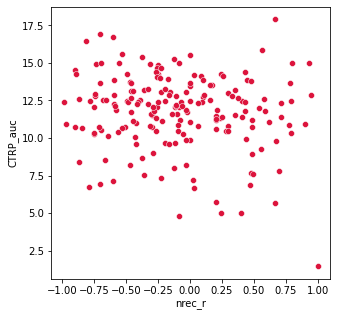

In [448]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='nrec_r',
                y='CTRP_auc',
                color='crimson',
                data=dose_dep_res)

<AxesSubplot:xlabel='rec_r', ylabel='CTRP_auc'>

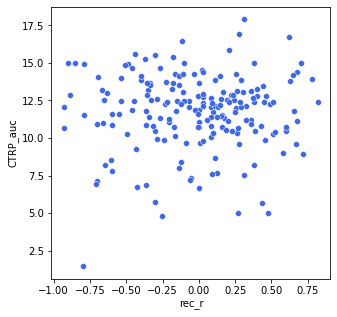

In [449]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='rec_r',
                y='CTRP_auc',
                color='royalblue',
                data=dose_dep_res)

<AxesSubplot:xlabel='cat_response', ylabel='nrec_r'>

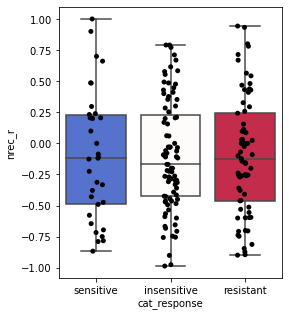

In [454]:
plt.figure(figsize=(4, 5))
sns.boxplot(y='nrec_r',
            x='cat_response',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=dose_dep_res)
sns.stripplot(x='cat_response', y='nrec_r', color='k', data=dose_dep_res)

<AxesSubplot:xlabel='cat_response', ylabel='rec_r'>

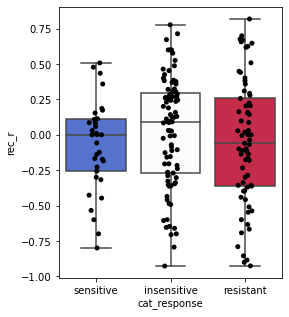

In [455]:
plt.figure(figsize=(4, 5))
sns.boxplot(y='rec_r',
            x='cat_response',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=dose_dep_res)
sns.stripplot(x='cat_response', y='rec_r', color='k', data=dose_dep_res)

<AxesSubplot:xlabel='cat_response', ylabel='shift_r'>

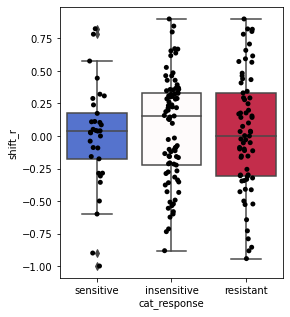

In [456]:
plt.figure(figsize=(4, 5))
sns.boxplot(y='shift_r',
            x='cat_response',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=dose_dep_res)
sns.stripplot(x='cat_response', y='shift_r', color='k', data=dose_dep_res)

<AxesSubplot:xlabel='cat_response', ylabel='CXCL10_r'>

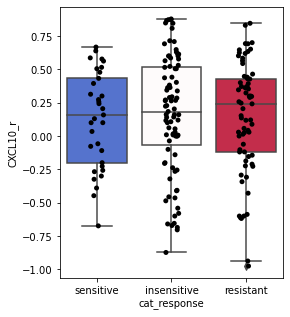

In [460]:
plt.figure(figsize=(4, 5))
sns.boxplot(y='CXCL10_r',
            x='cat_response',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=dose_dep_res)
sns.stripplot(x='cat_response', y='CXCL10_r', color='k', data=dose_dep_res)

In [465]:
dose_dep_res.sort_values(by='CXCL10_r', ascending=True)[['CXCL10_r', 'cat_response']][:20]

CXCL10_r cat_response
HT29_TG-101348     -0.974679    resistant
HT29_SN-38         -0.936975    resistant
HEPG2_sirolimus    -0.872872  insensitive
PC3_NVP-BEZ235     -0.703465  insensitive
YAPC_dasatinib     -0.685303  insensitive
MCF7_sirolimus     -0.673575    sensitive
MCF7_Merck60       -0.670820  insensitive
A549_selumetinib   -0.659191  insensitive
PC3_sorafenib      -0.654654  insensitive
PC3_I-BET-151      -0.617914    resistant
A549_entinostat    -0.612372    resistant
HEPG2_clofarabine  -0.600000    resistant
HT29_SNX-2112      -0.600000    resistant
SKMEL5_selumetinib -0.600000  insensitive
PC3_cytarabine     -0.587431    resistant
A549_NVP-TAE684    -0.579751  insensitive
MCF7_etoposide     -0.540899  insensitive
BT20_NVP-BEZ235    -0.485714  insensitive
HT29_crizotinib    -0.463817  insensitive
A375_YM-155        -0.455929  insensitive

In [466]:
dose_dep_res.sort_values(by='CXCL10_r', ascending=False)[['CXCL10_r', 'cat_response']][:20]

CXCL10_r cat_response
SKMEL5_bortezomib    0.877707  insensitive
MDAMB231_PHA-793887  0.872082  insensitive
A549_teniposide      0.872082  insensitive
A375_BMS-387032      0.866025  insensitive
PC3_apicidin         0.847579  insensitive
A375_manumycin-a     0.845154  insensitive
PC3_BI-2536          0.845154    resistant
PC3_doxorubicin      0.830198    resistant
A375_etoposide       0.807373  insensitive
A375_temsirolimus    0.714286  insensitive
A549_doxorubicin     0.708181  insensitive
HT29_NVP-TAE684      0.700000    resistant
PC3_BMS-387032       0.692935    resistant
A549_triptolide      0.691579    resistant
HEPG2_doxorubicin    0.691385  insensitive
MCF7_TG-101348       0.666886    sensitive
HT29_panobinostat    0.651404    resistant
A375_sunitinib       0.648074  insensitive
MCF7_SN-38           0.646021    resistant
HEPG2_tanespimycin   0.638194    sensitive

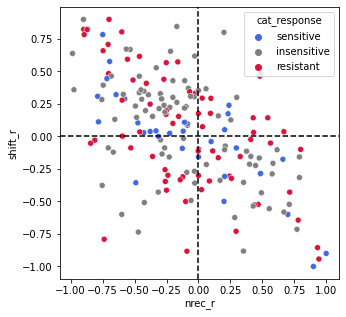

In [459]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='nrec_r',
                y='shift_r',
                hue='cat_response',
                palette={'sensitive': 'royalblue',
                         'insensitive': 'grey',
                         'resistant': 'crimson'},
                data=dose_dep_res)
plt.axvline(x=0., ls='--', c='k')
plt.axhline(y=0., ls='--', c='k')

## 1. CXCL10 expression

In [358]:
icd_rs_ctrp

IL17B     ANXA1     HMGB1  \
ABY001_SKBR3_XH:BRD-K66175015:0.625:24  2.041274  0.258538 -1.501830   
ABY001_SKBR3_XH:BRD-K66175015:2.5:24    1.663588  0.412947 -1.796820   
ABY001_SKBR3_XH:BRD-K70401845:10:24     0.884764 -0.584040 -1.080708   
ABY001_SKBR3_XH:BRD-K85606544:0.625:24  0.014190  1.264050 -1.625036   
ABY001_SKBR3_XH:BRD-K85606544:10:24     0.671776  0.058566 -0.852490   
...                                          ...       ...       ...   
REP.B024_A375_24H:N13                  -0.490050 -0.338350 -4.079350   
REP.B024_A375_24H:N14                  -0.320250 -1.455150 -4.250450   
REP.B024_A375_24H:N15                   0.103450  0.205100 -3.455700   
REP.B024_A375_24H:N16                  -0.671550  0.159300 -2.228900   
REP.B024_A375_24H:P21                  -0.258850 -0.403950  0.638300   

                                            IL1B    CXCL10      CALR  \
ABY001_SKBR3_XH:BRD-K66175015:0.625:24  0.577796  1.269013  0.184602   
ABY001_SKBR3_XH:BRD-K66175015:2.5:24    0.342638 -0.169909  0.413150   
ABY001_SKBR3_XH:BRD-K70401845:10:24    -0.582087  0.043422  0.391874   
ABY001_SKBR3_XH:BRD-K85606544:0.625:24  0.069305  0.810778 -0.646362   
ABY001_SKBR3_XH:BRD-K85606544:10:24     1.787614  1.589933  0.469251   
...                                          ...       ...       ...   
REP.B024_A375_24H:N13                   6.337150  3.162950  1.498050   
REP.B024_A375_24H:N14                   0.831700  2.403900  0.414200   
REP.B024_A375_24H:N15                   0.990050  1.943150 -0.317300   
REP.B024_A375_24H:N16                  -1.166850  0.186950 -0.353400   
REP.B024_A375_24H:P21                   3.398400  0.765200  0.174450   

                                       cancer_type  time       tas cell_line  \
ABY001_SKBR3_XH:BRD-K66175015:0.625:24        BRCA  24.0  0.502163     SKBR3   
ABY001_SKBR3_XH:BRD-K66175015:2.5:24          BRCA  24.0  0.581743     SKBR3   
ABY001_SKBR3_XH:BRD-K70401845:10:24           BRCA  24.0  0.488204     SKBR3   
ABY001_SKBR3_XH:BRD-K85606544:0.625:24        BRCA  24.0  0.584881     SKBR3   
ABY001_SKBR3_XH:BRD-K85606544:10:24           BRCA  24.0  0.676028     SKBR3   
...                                            ...   ...       ...       ...   
REP.B024_A375_24H:N13                         SKCM  24.0  0.789133      A375   
REP.B024_A375_24H:N14                         SKCM  24.0  0.720418      A375   
REP.B024_A375_24H:N15                         SKCM  24.0  0.688517      A375   
REP.B024_A375_24H:N16                         SKCM  24.0  0.490053      A375   
REP.B024_A375_24H:P21                         SKCM  24.0  0.408178      A375   

                                        shift_ability  NREC_score  REC_score  \
ABY001_SKBR3_XH:BRD-K66175015:0.625:24       0.690177   -0.341525   0.348652   
ABY001_SKBR3_XH:BRD-K66175015:2.5:24         0.673772   -0.335250   0.338522   
ABY001_SKBR3_XH:BRD-K70401845:10:24          0.564828   -0.332763   0.232066   
ABY001_SKBR3_XH:BRD-K85606544:0.625:24       0.516327   -0.318576   0.197751   
ABY001_SKBR3_XH:BRD-K85606544:10:24          0.509666   -0.281138   0.228528   
...                                               ...         ...        ...   
REP.B024_A375_24H:N13                        0.625826   -0.336165   0.289661   
REP.B024_A375_24H:N14                        0.621532   -0.332232   0.289300   
REP.B024_A375_24H:N15                        0.683517   -0.366633   0.316884   
REP.B024_A375_24H:N16                        0.713580   -0.358874   0.354705   
REP.B024_A375_24H:P21                        0.620617   -0.309853   0.310764   

                                       dose_cat   icd_ave  nearest_dose  \
ABY001_SKBR3_XH:BRD-K66175015:0.625:24      low  0.471566          0.66   
ABY001_SKBR3_XH:BRD-K66175015:2.5:24     medium  0.144266          2.50   
ABY001_SKBR3_XH:BRD-K70401845:10:24      medium -0.154463         10.00   
ABY001_SKBR3_XH:BRD-K85606544:0.625:24      low -0.018846          0.66   
ABY001_SKBR3_XH:

In [359]:
# EC of CXCL10 greater than 0.: the treatment can induce CXCL10 expression
cxcl10_induce = icd_rs_ctrp[icd_rs_ctrp['CXCL10'] > 0]
cxcl10_induce.shape

(2909, 18)

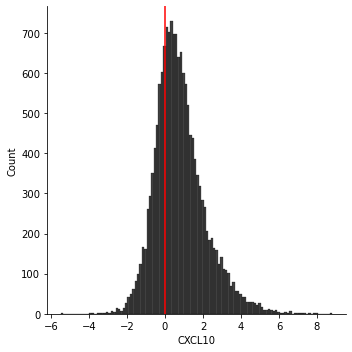

In [360]:
sns.displot(icd_rs_expr_24h['CXCL10'], color='k')
plt.axvline(x=0., c='r')

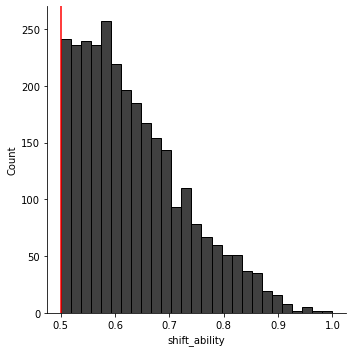

In [361]:
# shift ability of CXCL10-inducing compounds
sns.displot(cxcl10_induce['shift_ability'], color='k', label='CXCL10 inducing')
plt.axvline(x=0.5, c='r')

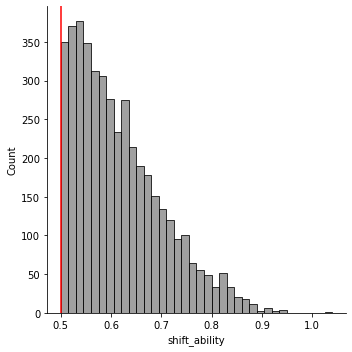

In [362]:
# shift ability of CXCL10-inhibiting compounds
sns.displot(icd_rs_expr_24h[icd_rs_expr_24h['CXCL10'] < 0]['shift_ability'], color='grey', label='CXCL10 inducing')
plt.axvline(x=0.5, c='r')

<AxesSubplot:xlabel='cat_response', ylabel='CXCL10'>

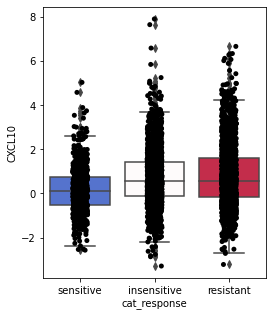

In [363]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='CXCL10',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=icd_rs_ctrp)
sns.stripplot(x='cat_response', y='CXCL10', color='k', data=icd_rs_ctrp)

<AxesSubplot:xlabel='cat_response', ylabel='CXCL10'>

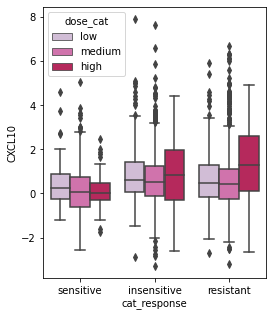

In [408]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='CXCL10',
            hue='dose_cat',
            palette='PuRd',
            data=icd_rs_ctrp)

<AxesSubplot:xlabel='cat_response', ylabel='CXCL10'>

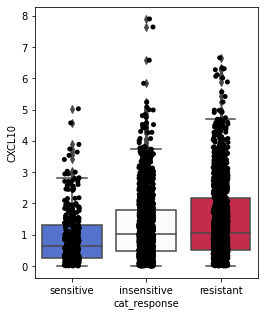

In [365]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='CXCL10',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=cxcl10_induce)
sns.stripplot(x='cat_response', y='CXCL10', color='k', data=cxcl10_induce)

<AxesSubplot:xlabel='cat_response', ylabel='CXCL10'>

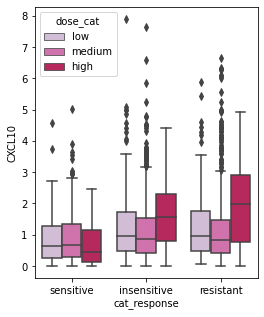

In [409]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='CXCL10',
            hue='dose_cat',
            palette='PuRd',
            data=cxcl10_induce)

<AxesSubplot:xlabel='cat_response', ylabel='tas'>

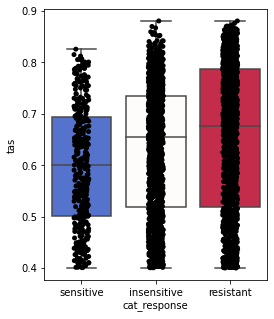

In [367]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='tas',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=cxcl10_induce)
sns.stripplot(x='cat_response', y='tas', color='k', data=cxcl10_induce)

<AxesSubplot:xlabel='cat_response', ylabel='tas'>

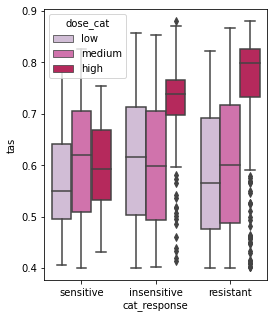

In [410]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='tas',
            hue='dose_cat',
            palette='PuRd',
            data=cxcl10_induce)

<AxesSubplot:xlabel='cat_response', ylabel='shift_ability'>

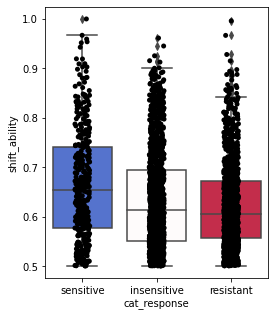

In [398]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='shift_ability',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=cxcl10_induce)
sns.stripplot(x='cat_response', y='shift_ability', color='k', data=cxcl10_induce)

<AxesSubplot:xlabel='cat_response', ylabel='shift_ability'>

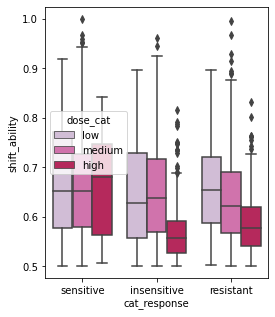

In [411]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='shift_ability',
            hue='dose_cat',
            palette='PuRd',
            data=cxcl10_induce)

<AxesSubplot:xlabel='cat_response', ylabel='NREC_score'>

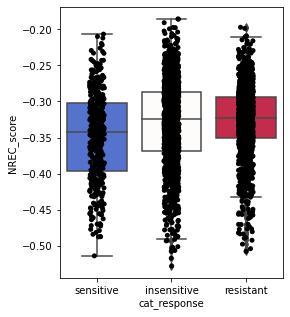

In [400]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='NREC_score',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=cxcl10_induce)
sns.stripplot(x='cat_response', y='NREC_score', color='k', data=cxcl10_induce)

<AxesSubplot:xlabel='cat_response', ylabel='NREC_score'>

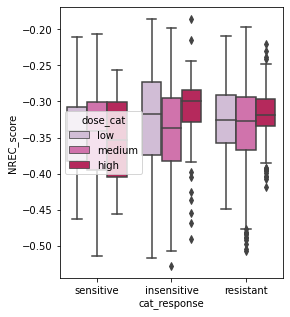

In [412]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='NREC_score',
            hue='dose_cat',
            palette='PuRd',
            data=cxcl10_induce)

<AxesSubplot:xlabel='cat_response', ylabel='REC_score'>

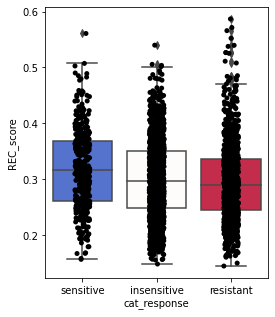

In [401]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='REC_score',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=cxcl10_induce)
sns.stripplot(x='cat_response', y='REC_score', color='k', data=cxcl10_induce)

<AxesSubplot:xlabel='cat_response', ylabel='REC_score'>

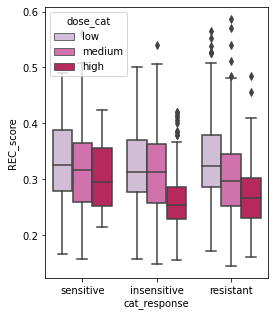

In [413]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='REC_score',
            hue='dose_cat',
            palette='PuRd',
            data=cxcl10_induce)

In [370]:
cxcl10_induce['cat_response'].value_counts()

insensitive    1383
resistant      1140
sensitive       386
Name: cat_response, dtype: int64

In [371]:
icd_rs_ctrp['cat_response'].value_counts()

insensitive    1943
resistant      1620
sensitive       707
Name: cat_response, dtype: int64

In [372]:
cmap2020_sensitivity['cat_sensitivity'].value_counts()

insensitive    16983
resistant       8861
sensitive       8707
Name: cat_sensitivity, dtype: int64

In [373]:
# CXCL10 inducer are enriched in resistant pairs (1140/1620)
# in contrast, only 386/707 sensitive pairs are capable to induce CXCL10 expression

In [375]:
cxcl10_induce['cmap_name'].value_counts()[:20]

bortezomib      602
vorinostat      185
doxorubicin     120
sirolimus        86
triptolide       72
tanespimycin     71
panobinostat     65
dasatinib        58
selumetinib      49
BMS-387032       47
gemcitabine      43
entinostat       40
clofarabine      39
cytarabine       39
PHA-793887       38
alisertib        35
SN-38            35
topotecan        34
alvocidib        32
etoposide        30
Name: cmap_name, dtype: int64

In [379]:
cxcl10_induce[cxcl10_induce['cat_response'] == 'resistant']['cmap_name'].value_counts()[:20]

bortezomib      325
vorinostat       68
sirolimus        58
panobinostat     42
doxorubicin      36
tanespimycin     34
alisertib        33
triptolide       33
gemcitabine      24
MG-132           22
SN-38            17
alvocidib        16
linsitinib       16
clofarabine      15
PHA-793887       15
BMS-387032       14
cytarabine       14
ixazomib         11
dinaciclib       11
vemurafenib      10
Name: cmap_name, dtype: int64

In [415]:
cxcl10_induce[cxcl10_induce['cat_response'] == 'insensitive']['cmap_name'].value_counts()[:20]

bortezomib      277
doxorubicin      84
vorinostat       57
selumetinib      47
triptolide       39
BMS-387032       29
dasatinib        29
tanespimycin     26
topotecan        25
etoposide        24
PHA-793887       23
apicidin         22
entinostat       21
NVP-BEZ235       20
gemcitabine      19
SN-38            18
crizotinib       17
PF-03758309      16
panobinostat     16
NVP-TAE684       15
Name: cmap_name, dtype: int64

In [419]:
cxcl10_induce[cxcl10_induce['cat_response'] == 'sensitive']['cmap_name'].value_counts()[:20]

vorinostat      60
dasatinib       27
sirolimus       21
entinostat      18
nutlin-3        17
clofarabine     16
fulvestrant     15
tanespimycin    11
cytarabine      11
PLX-4720        11
TG-101348       10
GDC-0879         9
BMS-754807       8
tamoxifen        7
neratinib        7
panobinostat     7
TW-37            6
simvastatin      6
alvocidib        5
PI-103           5
Name: cmap_name, dtype: int64

In [397]:
cxcl10_induce[cxcl10_induce['cmap_name'] == 'selumetinib']

IL17B     ANXA1     HMGB1  \
LJP001_MDAMB231_24H:BRD-K57080016-001-08-4:10  2.350993 -0.742537 -1.979178   
LJP001_MDAMB231_24H:BRD-K57080016-001-08-4:2   2.244149 -1.075773 -1.326088   
REP.A015_MDAMB231_24H:E19                      1.817400  0.536050 -2.902150   
REP.A015_MDAMB231_24H:E20                      1.006950  1.584600 -2.950950   
REP.A015_MDAMB231_24H:E21                      0.967000  1.538400 -1.749800   
REP.B015_MDAMB231_24H:E19                      0.717500 -1.343750 -0.963550   
CPC006_HT29_24H:BRD-K57080016-001-04-3:80      2.824040 -1.126331 -1.782190   
LJP006_HT29_24H:M07                            0.434450 -1.950900 -2.236350   
PBIOA019_HT29_24H:D07                          2.125181 -0.531896 -1.958710   
PBIOA019_HT29_24H:D08                          2.108705  0.172817 -1.981224   
PBIOA019_HT29_24H:D09                          1.277453 -0.483810 -0.830708   
PBIOA019_HT29_24H:D10                          2.047690 -0.400078 -0.391429   
PBIOA019_HT29_24H:D11                          0.941909 -0.301669 -0.652690   
PBIOA019_HT29_24H:D12                          1.098380 -1.429099 -0.709723   
REP.A015_HT29_24H:E19                          0.611850 -0.799700 -2.496400   
REP.A015_HT29_24H:E20                          0.510900 -1.304000 -4.239200   
REP.A015_HT29_24H:E21                          0.156965 -0.049411 -1.736952   
REP.A015_HT29_24H:E22                          1.194199 -0.480120 -1.300632   
REP.A015_HT29_24H:E23                         -0.017337  0.735386 -0.924968   
REP.A015_HT29_24H:E24                          0.564621  0.043150  0.200908   
REP.B015_HT29_24H:E19                          0.912450 -2.225750 -0.728450   
REP.B015_HT29_24H:E20                          0.759500 -0.368850 -1.305750   
REP.B015_HT29_24H:E22                         -0.010100 -0.376800 -0.864950   
ASG002_A549_24H:J04                            0.464346 -0.479840 -0.161092   
ASG003_A549_24H:E04                            1.481089 -2.577404 -0.578178   
LKCP002_A549_24H:N14                           0.520831 -1.014928 -0.504420   
LUNG001_A549_24H:BRD-K57080016:10              1.355350 -0.279900 -0.092100   
PBIOA019_A549_24H:D08                          1.459353  0.170022 -0.614457   
PBIOA019_A549_24H:D09                          0.133603  0.557758 -1.282232   
PBIOA019_A549_24H:D10                          0.919084  0.065276 -0.037117   
REP.A015_A549_24H:E19                          1.559142 -0.123848 -1.565017   
REP.A015_A549_24H:E20                          1.636153 -0.484437  0.336659   
REP.A015_YAPC_24H:E19                          0.614129  0.893898 -2.869811   
REP.A015_YAPC_24H:E20                          0.401542  0.940965 -0.645303   
AICHI002_SKMEL5_24H:B22                       -0.184850  0.562250 -0.805750   
CPC006_A375_24H:BRD-K57080016-001-04-3:80      4.383981 -1.280944 -1.701813   
LJP006_A375_24H:M08                            1.354950 -1.788200 -1.621450   
PBIOA019_A375_24H:D07                          3.062615  0.574555 -2.167112   
PBIOA019_A375_24H:D08                          4.160050  0.274066 -1.306584   
PBIOA019_A375_24H:D09                          1.264649  0.055885 -2.348747   
PBIOA019_A375_24H:D10                          2.367932  0.687999 -1.351828   
PBIOA019_A375_24H:D11                          1.777308  0.294755 -1.047641   
PBIOA019_A375_24H:D12                          0.583328  0.369002 -0.161398   
REP.A015_A375_24H:E19                          1.199055 -0.793177 -2.622355   
REP.A015_A375_24H:E20                          1.461454  0.597758 -1.044447   
REP.A015_A375_24H:E21                          1.092636  0.463104 -1.721280   
REP.A015_A375_24H:E22                          1.165638 -0.360806 -1.800584   
REP.A015_A375_24H:E23                          1.275479  0.178869 -1.641489   
REP.A015_A375_24H:E24                          0.547650  0.360256 -0.910897   

                                                   IL1B    CXCL10      CALR  \
LJP001_MDAMB231_24H:

In [387]:
cxcl10_induce_resist_moa = df(compound_info.loc[cxcl10_induce[cxcl10_induce['cat_response'] == 'resistant']['cmap_name'].unique(), 'moa'])

In [389]:
cxcl10_induce_resist_moa['moa'].value_counts()

HDAC inhibitor                                7
Topoisomerase inhibitor                       5
KIT inhibitor                                 4
EGFR inhibitor                                4
MTOR inhibitor                                4
Retinoid receptor agonist                     4
CDK inhibitor                                 4
IGF-1 inhibitor                               3
MDM inhibitor                                 3
BCL inhibitor                                 3
Proteasome inhibitor                          3
PI3K inhibitor                                3
IKK inhibitor                                 2
PLK inhibitor                                 2
ALK inhibitor                                 2
VEGFR inhibitor                               2
DNA methyltransferase inhibitor               2
JAK inhibitor                                 2
RAF inhibitor                                 2
Tubulin inhibitor                             2
Src inhibitor                           

In [416]:
cxcl10_induce_insensi_moa = df(compound_info.loc[cxcl10_induce[cxcl10_induce['cat_response'] == 'insensitive']['cmap_name'].unique(), 'moa'])

In [418]:
cxcl10_induce_insensi_moa['moa'].value_counts()[:10]

HDAC inhibitor             9
PI3K inhibitor             8
MTOR inhibitor             7
EGFR inhibitor             6
KIT inhibitor              5
Topoisomerase inhibitor    5
CDK inhibitor              4
HMGCR inhibitor            3
MDM inhibitor              3
Proteasome inhibitor       3
Name: moa, dtype: int64

In [390]:
cxcl10_induce_resist_moa[cxcl10_induce_resist_moa['moa'] == 'MEK inhibitor']

moa
cmap_name                 
selumetinib  MEK inhibitor

In [391]:
cxcl10_induce_resist_moa[cxcl10_induce_resist_moa['moa'] == 'CDK inhibitor']

moa
cmap_name                
BMS-387032  CDK inhibitor
PHA-793887  CDK inhibitor
alvocidib   CDK inhibitor
dinaciclib  CDK inhibitor

In [392]:
cxcl10_induce_resist_moa[cxcl10_induce_resist_moa['moa'] == 'HDAC inhibitor']

moa
cmap_name                      
panobinostat     HDAC inhibitor
Merck60          HDAC inhibitor
apicidin         HDAC inhibitor
vorinostat       HDAC inhibitor
HDAC3-selective  HDAC inhibitor
entinostat       HDAC inhibitor
belinostat       HDAC inhibitor

In [394]:
cxcl10_induce_resist_moa[cxcl10_induce_resist_moa['moa'] == 'Topoisomerase inhibitor']

moa
cmap_name                           
SN-38        Topoisomerase inhibitor
teniposide   Topoisomerase inhibitor
topotecan    Topoisomerase inhibitor
doxorubicin  Topoisomerase inhibitor
etoposide    Topoisomerase inhibitor

In [396]:
cxcl10_induce_resist_moa[cxcl10_induce_resist_moa['moa'] == 'Proteasome inhibitor']

moa
cmap_name                       
bortezomib  Proteasome inhibitor
ixazomib    Proteasome inhibitor
MG-132      Proteasome inhibitor

In [420]:
cxcl10_induce[cxcl10_induce['cmap_name'] == 'PF-03758309']

IL17B     ANXA1     HMGB1      IL1B    CXCL10  \
LJP009_PC3_24H:D01    1.085115  0.661089 -3.666821 -1.578847  3.370172   
LJP009_PC3_24H:D02   -0.126091 -0.194698 -2.921162 -3.295531  1.046688   
LJP009_PC3_24H:D03    0.372399 -0.349711 -3.802146 -3.538214  0.656621   
LJP009_PC3_24H:D04    0.483607  1.039797 -3.435033 -3.225137  0.278332   
LJP009_PC3_24H:D05    1.380319 -0.499075 -3.234181 -1.634996  0.888062   
LJP009_PC3_24H:D06    0.436814  1.123328 -2.712084 -3.102897  0.415689   
MOAR004_PC3_24H:A16   1.938772  0.341806 -3.878018 -2.913291  5.244284   
MOAR004_PC3_24H:A17   1.849473  1.252897 -4.926425 -5.222874  0.426025   
MOAR004_PC3_24H:A18   1.413407 -0.233154 -2.860924 -3.154502  0.202278   
REP.A014_PC3_24H:K13  1.497067  0.419600 -4.905963 -1.614991  3.158845   
REP.A014_PC3_24H:K14  0.201530  0.439934 -3.833545 -4.413922  0.429442   
REP.A014_PC3_24H:K15  0.726766  0.862407 -2.535086 -2.341845  0.934681   
REP.A014_PC3_24H:K17  0.691382  0.296163 -1.739714 -3.734053  0.371830   
REP.B014_PC3_24H:K13  1.291800 -0.808650 -3.909000 -5.096200  0.525350   
REP.B014_PC3_24H:K14  1.041150  1.709600 -3.334050 -4.102200  0.214100   
REP.B014_PC3_24H:K15  1.665200  1.633800 -2.259650 -5.122950  0.871700   

                          CALR cancer_type  time       tas cell_line  \
LJP009_PC3_24H:D01    0.217265        PRAD  24.0  0.728862       PC3   
LJP009_PC3_24H:D02   -0.347393        PRAD  24.0  0.525938       PC3   
LJP009_PC3_24H:D03   -0.711078        PRAD  24.0  0.482478       PC3   
LJP009_PC3_24H:D04   -0.299299        PRAD  24.0  0.490819       PC3   
LJP009_PC3_24H:D05    0.919950        PRAD  24.0  0.432302       PC3   
LJP009_PC3_24H:D06    0.204017        PRAD  24.0  0.428643       PC3   
MOAR004_PC3_24H:A16  -3.211530        PRAD  24.0  0.842014       PC3   
MOAR004_PC3_24H:A17  -1.255811        PRAD  24.0  0.736536       PC3   
MOAR004_PC3_24H:A18  -0.115765        PRAD  24.0  0.677690       PC3   
REP.A014_PC3_24H:K13 -2.312205        PRAD  24.0  0.808203       PC3   
REP.A014_PC3_24H:K14 -1.433678        PRAD  24.0  0.685355       PC3   
REP.A014_PC3_24H:K15 -0.048294        PRAD  24.0  0.632508       PC3   
REP.A014_PC3_24H:K17 -0.043703        PRAD  24.0  0.542504       PC3   
REP.B014_PC3_24H:K13 -1.384800        PRAD  24.0  0.642900       PC3   
REP.B014_PC3_24H:K14 -0.611150        PRAD  24.0  0.574747       PC3   
REP.B014_PC3_24H:K15  0.026750        PRAD  24.0  0.534748       PC3   

                      shift_ability  NREC_score  REC_score dose_cat   icd_ave  \
LJP009_PC3_24H:D01         0.524249   -0.295718   0.228531   medium  0.014662   
LJP009_PC3_24H:D02         0.640044   -0.421273   0.218771   medium -0.973031   
LJP009_PC3_24H:D03         0.629636   -0.380927   0.248709   medium -1.228688   
LJP009_PC3_24H:D04         0.714558   -0.395044   0.319514      low -0.859622   
LJP009_PC3_24H:D05         0.641321   -0.393374   0.247948      low -0.363320   
LJP009_PC3_24H:D06         0.579317   -0.382378   0.196939      low -0.605855   
MOAR004_PC3_24H:A16        0.507257   -0.299140   0.208117   medium -0.412996   
MOAR004_PC3_24H:A17        0.782614   -0.434371   0.348243   medium -1.312786   
MOAR004_PC3_24H:A18        0.633255   -0.413250   0.220005   medium -0.791443   
REP.A014_PC3_24H:K13       0.607173   -0.336802   0.270371   medium -0.626275   
REP.A014_PC3_24H:K14       0.720464   -0.425009   0.295455   medium -1.435040   
REP.A014_PC3_24H:K15       0.797051   -0.431607   0.365444   medium -0.400229   
REP.A014_PC3_24H:K17       0.778947   -0.357591   0.421356      low -0.693016   
REP.B014_PC3_24H:K13       0.796856   -0.460567   0.336289   medium -1.563583   
REP.B014_PC3_24H:K14       0.650289   -0.364589   0.285700      low -0.847092   
REP.B014_PC3_24H:K15       0.842980   -0.420736   0.422244      low -0.530858   

                      nearest_dose    cmap_name cat_response  
LJP009_PC3_24H:D01          10.000  PF-03758309  insensitive  
LJP009_PC3_24H:D02           3.330  P

## 2. CXCL10 inducer (resistant/insensitive pairs)

In [424]:
cxcl10_induce_resist = cxcl10_induce[cxcl10_induce['cat_response'] == 'resistant']

In [426]:
cxcl10_induce_insensi = cxcl10_induce[cxcl10_induce['cat_response'] == 'insensitive']

In [427]:
cxcl10_induce_resist.shape

(1140, 18)

In [428]:
cxcl10_induce_insensi.shape

(1383, 18)

In [435]:
# extract drug pairs
cxcl10_induce_resist_pair = []
for i in cxcl10_induce_resist.index:
    tmp_c = cxcl10_induce_resist.loc[i, 'cell_line']
    tmp_d = cxcl10_induce_resist.loc[i, 'cmap_name']
    tmp_n = str(tmp_c) + '_' + str(tmp_d)
    if tmp_n in cxcl10_induce_resist_pair:
        continue
    else:
        cxcl10_induce_resist_pair.append(tmp_n)

cxcl10_induce_insensi_pair = []
for i in cxcl10_induce_insensi.index:
    tmp_c = cxcl10_induce_insensi.loc[i, 'cell_line']
    tmp_d = cxcl10_induce_insensi.loc[i, 'cmap_name']
    tmp_n = str(tmp_c) + '_' + str(tmp_d)
    if tmp_n in cxcl10_induce_insensi_pair:
        continue
    else:
        cxcl10_induce_insensi_pair.append(tmp_n)    

In [434]:
len(cxcl10_induce_resist_pair)

231

In [436]:
len(cxcl10_induce_insensi_pair)

379

In [437]:
cxcl10_resist_dosedep = dose_dep_icd_rs_g24[dose_dep_icd_rs_g24.index.isin(cxcl10_induce_resist_pair)]

In [438]:
cxcl10_resist_dosedep

shift_r   shift_p     rec_r     rec_p    nrec_r  \
MCF7_YM-155          0.331444  0.422556  0.098206  0.817045 -0.024551   
MCF7_bortezomib      0.169480  0.062010 -0.036581  0.689137 -0.254223   
MCF7_teniposide      0.615587  0.268998  0.359092  0.552815 -0.461690   
MCF7_SN-38           0.463129  0.070824  0.625371  0.009577  0.480828   
MCF7_paclitaxel      0.433461  0.331270  0.157622  0.735724 -0.512272   
...                       ...       ...       ...       ...       ...   
A375_bortezomib     -0.163836  0.005563 -0.136838  0.020843  0.155088   
A375_panobinostat    0.074077  0.819028  0.000000  1.000000  0.031747   
A375_ixazomib       -0.333333  0.419753 -0.547619  0.160026 -0.142857   
SKMEL5_sirolimus     0.782624  0.117614 -0.111803  0.857945 -0.894427   
SKMEL5_tanespimycin -0.300000  0.623838 -0.300000  0.623838  0.000000   

                       nrec_p  icd_ave_r  icd_ave_p   ANXA1_r   ANXA1_p  ...  \
MCF7_YM-155          0.953985   0.527856   0.178749  0.220963  0.598983  ...   
MCF7_bortezomib      0.004718  -0.027889   0.760422 -0.181428  0.045507  ...   
MCF7_teniposide      0.433766   0.666886   0.218894 -0.718185  0.171795  ...   
MCF7_SN-38           0.059377  -0.265488   0.320323 -0.200591  0.456333  ...   
MCF7_paclitaxel      0.239805  -0.472866   0.283891  0.453163  0.307181  ...   
...                       ...        ...        ...       ...       ...  ...   
A375_bortezomib      0.008727  -0.040188   0.499202 -0.024947  0.674953  ...   
A375_panobinostat    0.921977   0.232813   0.466499 -0.299835  0.343717  ...   
A375_ixazomib        0.735765   0.666667   0.070988 -0.285714  0.492726  ...   
SKMEL5_sirolimus     0.040519  -0.335410   0.581091 -0.223607  0.717686  ...   
SKMEL5_tanespimycin  1.000000   0.300000   0.623838 -0.100000  0.872889  ...   

                       IL1B_r    IL1B_p   IL17B_r   IL17B_p  cancer_type  \
MCF7_YM-155          0.601510  0.114684 -0.036827  0.931012         BRCA   
MCF7_bortezomib     -0.036096  0.693051  0.103533  0.256443         BRCA   
MCF7_teniposide      0.564288  0.321723  0.718185  0.171795         BRCA   
MCF7_SN-38           0.123894  0.647566 -0.737466  0.001113         BRCA   
MCF7_paclitaxel     -0.472866  0.283891 -0.453163  0.307181         BRCA   
...                       ...       ...       ...       ...          ...   
A375_bortezomib     -0.022919  0.700036  0.023867  0.688271         SKCM   
A375_panobinostat    0.292780  0.355738  0.486791  0.108505         SKCM   
A375_ixazomib        0.714286  0.046528  0.333333  0.419753         SKCM   
SKMEL5_sirolimus     0.782624  0.117614 -0.111803  0.857945         SKCM   
SKMEL5_tanespimycin  0.000000  1.000000  0.400000  0.504632         SKCM   

                     cell_line     cmap_name  #experiments  \
MCF7_YM-155               MCF7        YM-155           8.0   
MCF7_bortezomib           MCF7    bortezomib         122.0   
MCF7_teniposide           MCF7    teniposide           5.0   
MCF7_SN-38                MCF7         SN-38          16.0   
MCF7_paclitaxel           MCF7    paclitaxel           7.0   
...                        ...           ...           ...   
A375_bortezomib           A375    bortezomib         285.0   
A375_panobinostat         A375  panobinostat          12.0   
A375_ixazomib             A375      ixazomib           8.0   
SKMEL5_sirolimus        SKMEL5     sirolimus           5.0   
SKMEL5_tanespimycin     SKMEL5  tanespimycin           5.0   

                                         moa    target  
MCF7_YM-155               Survivin inhibitor     BIRC5  
MCF7_bortezomib         Proteasome inhibitor     PSMB1  
MCF7_teniposide      Topoisomerase inhibitor     TOP2A  
MCF7_SN-38           Topoisomerase inhibitor      TOP1  
MCF7_paclitaxel            Tubulin inhibitor      TUBB  
...                                      ...       ...  
A375_bortezomib         Proteasome inhibitor     PSMB1  
A375_panobinostat             HDAC inhibitor     HDAC1  
A375_ixazomib

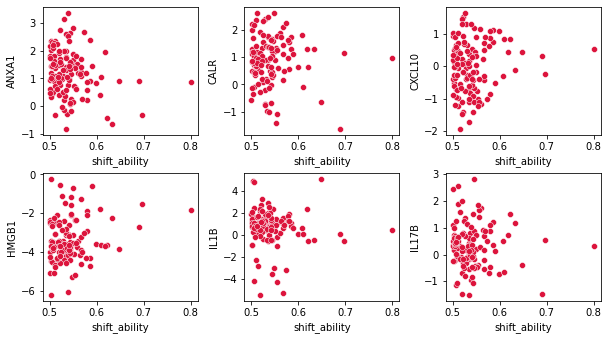

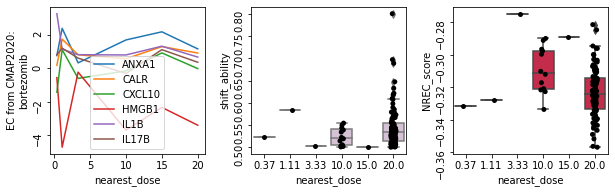

In [468]:
visual_ICD_scatterplot(case='MCF7_bortezomib',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='MCF7_bortezomib',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

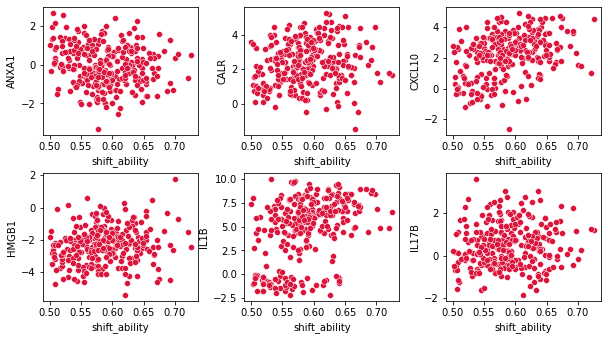

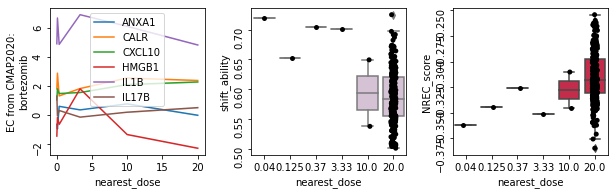

In [469]:
visual_ICD_scatterplot(case='A375_bortezomib',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='A375_bortezomib',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

In [439]:
cxcl10_insensi_dosedep = dose_dep_icd_rs_g24[dose_dep_icd_rs_g24.index.isin(cxcl10_induce_insensi_pair)]

In [440]:
cxcl10_insensi_dosedep

shift_r   shift_p     rec_r     rec_p    nrec_r  \
SKBR3_alvocidib    -0.600000  0.284757 -0.700000  0.188120 -0.600000   
MCF7_RITA          -0.223607  0.717686  0.111803  0.857945  0.447214   
MCF7_panobinostat  -0.213770  0.304867  0.269739  0.192242  0.399944   
MCF7_PHA-793887     0.366355  0.332183  0.425763  0.253214  0.059409   
MCF7_etoposide      0.304256  0.557699  0.304256  0.557699 -0.033806   
...                      ...       ...       ...       ...       ...   
A375_apicidin       0.300000  0.623838  0.600000  0.284757  0.300000   
A375_temsirolimus  -0.535714  0.215217  0.285714  0.534509  0.428571   
SKMEL5_vorinostat  -0.881917  0.003760 -0.793725  0.018688  0.352767   
SKMEL5_selumetinib  0.900000  0.037386  0.600000  0.284757 -0.900000   
SKMEL5_bortezomib   0.126592  0.745527  0.126592  0.745527  0.253185   

                      nrec_p  icd_ave_r  icd_ave_p   ANXA1_r   ANXA1_p  ...  \
SKBR3_alvocidib     0.284757   0.100000   0.872889  0.800000  0.104088  ...   
MCF7_RITA           0.450185  -0.223607   0.717686  0.335410  0.581091  ...   
MCF7_panobinostat   0.047602  -0.373126   0.066194 -0.420933  0.036136  ...   
MCF7_PHA-793887     0.879329   0.495074   0.175400  0.752512  0.019301  ...   
MCF7_etoposide      0.949310  -0.101419   0.848394 -0.033806  0.949310  ...   
...                      ...        ...        ...       ...       ...  ...   
A375_apicidin       0.623838  -0.500000   0.391002 -0.600000  0.284757  ...   
A375_temsirolimus   0.337368   0.321429   0.482072  0.714286  0.071344  ...   
SKMEL5_vorinostat   0.391388   0.881917   0.003760  0.655138  0.077844  ...   
SKMEL5_selumetinib  0.037386   0.200000   0.747060  0.200000  0.747060  ...   
SKMEL5_bortezomib   0.510980   0.970542   0.000014  0.903026  0.000849  ...   

                      IL1B_r    IL1B_p   IL17B_r   IL17B_p  cancer_type  \
SKBR3_alvocidib    -0.100000  0.872889 -0.100000  0.872889         BRCA   
MCF7_RITA           0.223607  0.717686 -0.447214  0.450185         BRCA   
MCF7_panobinostat  -0.156246  0.455767 -0.205219  0.325071         BRCA   
MCF7_PHA-793887     0.336650  0.375695 -0.613891  0.078650         BRCA   
MCF7_etoposide      0.304256  0.557699 -0.169031  0.748868         BRCA   
...                      ...       ...       ...       ...          ...   
A375_apicidin       0.300000  0.623838 -0.300000  0.623838         SKCM   
A375_temsirolimus   0.035714  0.939408 -0.214286  0.644512         SKCM   
SKMEL5_vorinostat   0.793725  0.018688  0.390563  0.338756         SKCM   
SKMEL5_selumetinib  0.500000  0.391002 -0.100000  0.872889         SKCM   
SKMEL5_bortezomib   0.936784  0.000197 -0.438854  0.237315         SKCM   

                    cell_line     cmap_name  #experiments  \
SKBR3_alvocidib         SKBR3     alvocidib           5.0   
MCF7_RITA                MCF7          RITA           5.0   
MCF7_panobinostat        MCF7  panobinostat          25.0   
MCF7_PHA-793887          MCF7    PHA-793887           9.0   
MCF7_etoposide           MCF7     etoposide           6.0   
...                       ...           ...           ...   
A375_apicidin            A375      apicidin           5.0   
A375_temsirolimus        A375  temsirolimus           7.0   
SKMEL5_vorinostat      SKMEL5    vorinostat           8.0   
SKMEL5_selumetinib     SKMEL5   selumetinib           5.0   
SKMEL5_bortezomib      SKMEL5    bortezomib           9.0   

                                        moa  target  
SKBR3_alvocidib               CDK inhibitor    CDK2  
MCF7_RITA                     MDM inhibitor    MDM2  
MCF7_panobinostat            HDAC inhibitor   HDAC1  
MCF7_PHA-793887               CDK inhibitor    CDK2  
MCF7_etoposide      Topoisomerase inhibitor   TOP2A  
...                                     ...     ...  
A375_apicidin                HDAC inhibitor   HDAC6  
A375_temsirolimus            MTOR inhibitor    MTOR  
SKMEL5_vorinostat            HDAC inhibitor   HDAC6  
SKMEL5_selumetinib            MEK

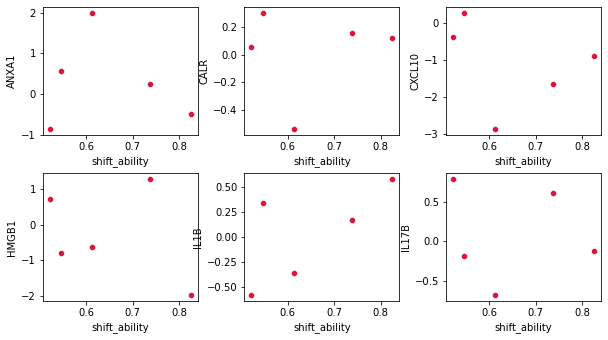

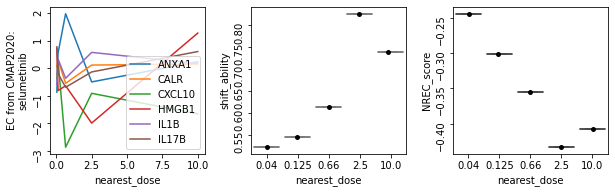

In [442]:
visual_ICD_scatterplot(case='SKMEL5_selumetinib',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='SKMEL5_selumetinib',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

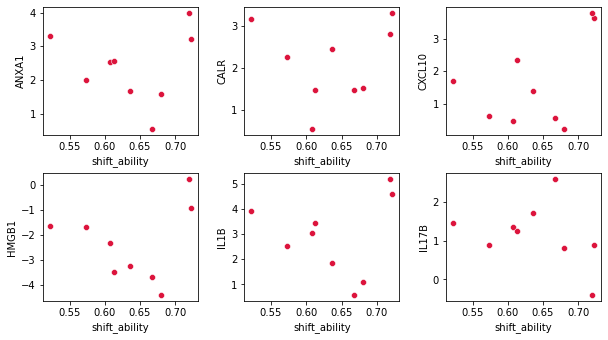

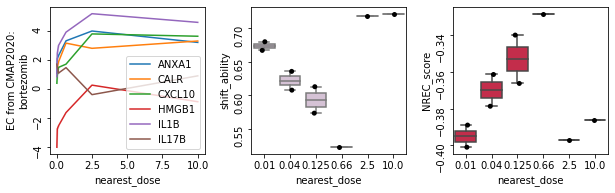

In [467]:
visual_ICD_scatterplot(case='SKMEL5_bortezomib',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='SKMEL5_bortezomib',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

# Apoptosis

In [470]:
compound_cancer = ['BLCA', 'BRCA', 'CESC', 'CRC', 'LIHC', 'LUNG',
                   'OV', 'PAAD', 'PRAD', 'SKCM', 'STAD', 'UCEC']

In [471]:
apop_nes_list = []
apop_fdr_list = []

for ct in compound_cancer:
    tmp_nes = pd.read_csv(gsea_home + ct + '/enr_result_trt_cp/nes_hallmark_apoptosis.csv',
                          header=0, index_col=0, sep=',')
    
    tmp_fdr = pd.read_csv(gsea_home + ct + '/enr_result_trt_cp/fdr_hallmark_apoptosis.csv',
                          header=0, index_col=0, sep=',')
    
    tmp_nes['cancer'] = ct
    tmp_fdr['cancer'] = ct
    
    apop_nes_list.append(tmp_nes)
    apop_fdr_list.append(tmp_fdr)

In [472]:
apop_nes_merge = pd.concat(apop_nes_list, axis=0)
apop_nes_merge

HALLMARK_APOPTOSIS      cmap_name  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10                1.533008       AZD-9291   
ERBB2001_VMCUB1_24H:BRD-K66175015:10                0.808206       afatinib   
ERBB2002_5637_24H:BRD-K66175015:10                  1.142678       afatinib   
ERBB2002_J82_24H:BRD-K42805893:10                   1.539047       AZD-9291   
ERBB2002_J82_24H:BRD-K66175015:10                   1.165102       afatinib   
...                                                      ...            ...   
CPC006_SNGM_6H:BRD-K92317137-001-04-0:10            1.354293  BRD-K92317137   
ERBB2001_MFE319_24H:BRD-K42805893:10               -1.038859       AZD-9291   
ERBB2002_AN3CA_24H:BRD-K42805893:10                 1.515240       AZD-9291   
ERBB2002_AN3CA_24H:BRD-K66175015:10                 1.519580       afatinib   
ERBB2002_XC_24H:BRD-K66175015:10                    0.654225       afatinib   

                                          nearest_dose pert_idose cancer  
ERBB2001_VMCUB1_24H:BRD-K42805893:10              10.0      10 uM   BLCA  
ERBB2001_VMCUB1_24H:BRD-K66175015:10              10.0      10 uM   BLCA  
ERBB2002_5637_24H:BRD-K66175015:10                10.0      10 uM   BLCA  
ERBB2002_J82_24H:BRD-K42805893:10                 10.0      10 uM   BLCA  
ERBB2002_J82_24H:BRD-K66175015:10                 10.0      10 uM   BLCA  
...                                                ...        ...    ...  
CPC006_SNGM_6H:BRD-K92317137-001-04-0:10          10.0      10 uM   UCEC  
ERBB2001_MFE319_24H:BRD-K42805893:10              10.0      10 uM   UCEC  
ERBB2002_AN3CA_24H:BRD-K42805893:10               10.0      10 uM   UCEC  
ERBB2002_AN3CA_24H:BRD-K66175015:10               10.0      10 uM   UCEC  
ERBB2002_XC_24H:BRD-K66175015:10                  10.0      10 uM   UCEC  

[41321 rows x 5 columns]

In [473]:
apop_fdr_merge = pd.concat(apop_fdr_list, axis=0)
apop_fdr_merge

HALLMARK_APOPTOSIS      cmap_name  \
ERBB2001_VMCUB1_24H:BRD-K42805893:10                0.000000       AZD-9291   
ERBB2001_VMCUB1_24H:BRD-K66175015:10                0.882353       afatinib   
ERBB2002_5637_24H:BRD-K66175015:10                  0.177778       afatinib   
ERBB2002_J82_24H:BRD-K42805893:10                   0.000000       AZD-9291   
ERBB2002_J82_24H:BRD-K66175015:10                   0.220588       afatinib   
...                                                      ...            ...   
CPC006_SNGM_6H:BRD-K92317137-001-04-0:10            0.027397  BRD-K92317137   
ERBB2001_MFE319_24H:BRD-K42805893:10                0.388889       AZD-9291   
ERBB2002_AN3CA_24H:BRD-K42805893:10                 0.000000       AZD-9291   
ERBB2002_AN3CA_24H:BRD-K66175015:10                 0.000000       afatinib   
ERBB2002_XC_24H:BRD-K66175015:10                    0.969697       afatinib   

                                          nearest_dose pert_idose cancer  
ERBB2001_VMCUB1_24H:BRD-K42805893:10              10.0      10 uM   BLCA  
ERBB2001_VMCUB1_24H:BRD-K66175015:10              10.0      10 uM   BLCA  
ERBB2002_5637_24H:BRD-K66175015:10                10.0      10 uM   BLCA  
ERBB2002_J82_24H:BRD-K42805893:10                 10.0      10 uM   BLCA  
ERBB2002_J82_24H:BRD-K66175015:10                 10.0      10 uM   BLCA  
...                                                ...        ...    ...  
CPC006_SNGM_6H:BRD-K92317137-001-04-0:10          10.0      10 uM   UCEC  
ERBB2001_MFE319_24H:BRD-K42805893:10              10.0      10 uM   UCEC  
ERBB2002_AN3CA_24H:BRD-K42805893:10               10.0      10 uM   UCEC  
ERBB2002_AN3CA_24H:BRD-K66175015:10               10.0      10 uM   UCEC  
ERBB2002_XC_24H:BRD-K66175015:10                  10.0      10 uM   UCEC  

[41321 rows x 5 columns]

In [496]:
apop_nes_merge['cell_line'] = sig_info['cell_mfc_name']
apop_fdr_merge['cell_line'] = sig_info['cell_mfc_name']

In [497]:
apop_nes_merge.to_csv(poseidon_home + 'apoptosis/nes_apoptosis_hallmark.csv', sep=',')
apop_fdr_merge.to_csv(poseidon_home + 'apoptosis/fdr_apoptosis_hallmark.csv', sep=',')

In [478]:
# merge with icd
icd_rs_ctrp['nes_apoptosis'] = apop_nes_merge['HALLMARK_APOPTOSIS']

<ipython-input-478-234e9543a087>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icd_rs_ctrp['nes_apoptosis'] = apop_nes_merge['HALLMARK_APOPTOSIS']


In [490]:
icd_rs_ctrp['nes_apoptosis'].replace(np.inf, np.nan, inplace=True)

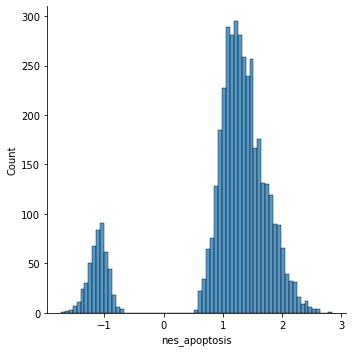

In [491]:
# distribution of apoptosis enrichment
sns.displot(icd_rs_ctrp['nes_apoptosis'])

## 0. Apoptosis versus drug response

<AxesSubplot:xlabel='cat_response', ylabel='nes_apoptosis'>

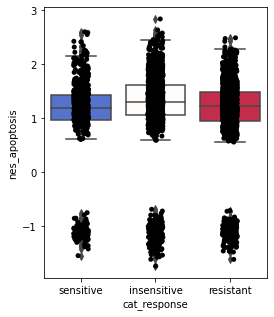

In [479]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='nes_apoptosis',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=icd_rs_ctrp)
sns.stripplot(x='cat_response', y='nes_apoptosis', color='k', data=icd_rs_ctrp)

(0.0, 3.0)

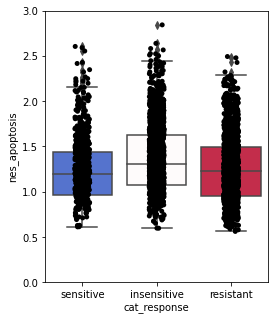

In [493]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='nes_apoptosis',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=icd_rs_ctrp)
sns.stripplot(x='cat_response', y='nes_apoptosis', color='k', data=icd_rs_ctrp)
plt.ylim(0, 3)

<AxesSubplot:xlabel='cat_response', ylabel='nes_apoptosis'>

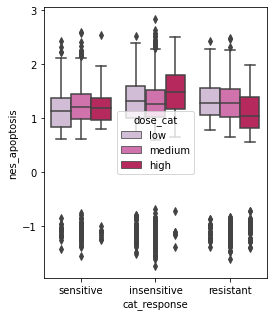

In [480]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='nes_apoptosis',
            hue='dose_cat',
            palette='PuRd',
            data=icd_rs_ctrp)

(0.0, 3.0)

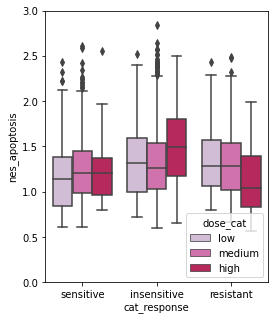

In [494]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='cat_response', y='nes_apoptosis',
            hue='dose_cat',
            palette='PuRd',
            data=icd_rs_ctrp)
plt.ylim(0, 3)

<AxesSubplot:xlabel='dose_cat', ylabel='nes_apoptosis'>

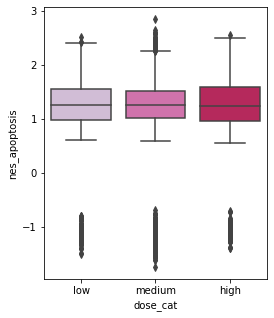

In [492]:
plt.figure(figsize=(4, 5))
sns.boxplot(x='dose_cat', y='nes_apoptosis',
            palette='PuRd',
            data=icd_rs_ctrp)

## 1. Apoptosis versus shift, EC scores and ICD

<AxesSubplot:xlabel='nes_apoptosis', ylabel='CXCL10'>

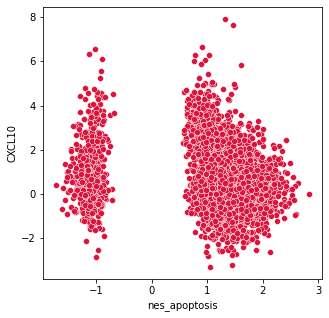

In [482]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='nes_apoptosis',
                y='CXCL10',
                color='crimson',
                data=icd_rs_ctrp)

<AxesSubplot:xlabel='nes_apoptosis', ylabel='shift_ability'>

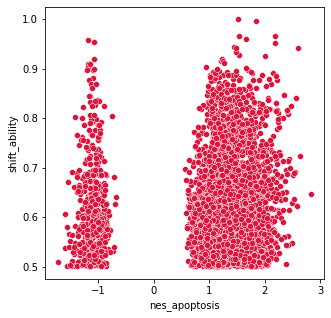

In [483]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='nes_apoptosis',
                y='shift_ability',
                color='crimson',
                data=icd_rs_ctrp)

<AxesSubplot:xlabel='nes_apoptosis', ylabel='NREC_score'>

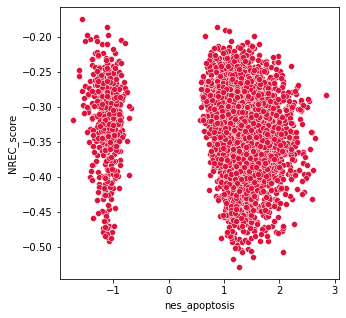

In [484]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='nes_apoptosis',
                y='NREC_score',
                color='crimson',
                data=icd_rs_ctrp)

<AxesSubplot:xlabel='nes_apoptosis', ylabel='REC_score'>

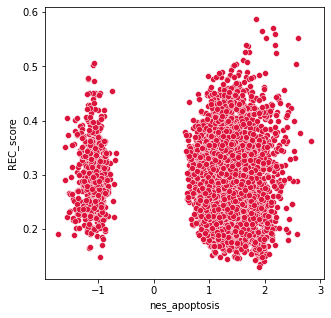

In [485]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='nes_apoptosis',
                y='REC_score',
                color='crimson',
                data=icd_rs_ctrp)

<AxesSubplot:xlabel='nes_apoptosis', ylabel='tas'>

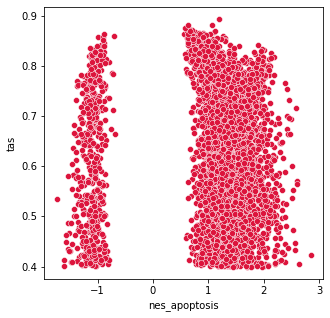

In [495]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='nes_apoptosis',
                y='tas',
                color='crimson',
                data=icd_rs_ctrp)

## 2. Dose-dependence of apoptosis

In [498]:
# dosage-dependence in each cell line (R-shifting): gene level, 24h treatment only
dose_dep_apop_rs_g24 = df(columns=['apop_r', 'apop_p'])
for ct in apop_nes_merge['cancer'].unique():
    tmp_rs = apop_nes_merge[apop_nes_merge['cancer'] == ct]
    for cl in tmp_rs['cell_line'].unique():
        tmp_rs_cl = tmp_rs[tmp_rs['cell_line'] == cl]
        for d in tmp_rs_cl['cmap_name'].unique():
            tmp_rs_cl_d = tmp_rs_cl[tmp_rs_cl['cmap_name'] == d]
            if tmp_rs_cl_d.shape[0] >= 5:
                tmp_a_r, tmp_a_p = stats.spearmanr(tmp_rs_cl_d['HALLMARK_APOPTOSIS'], tmp_rs_cl_d['nearest_dose'])

                dose_dep_apop_rs_g24.at[cl + '_' + d, 'apop_r'] = tmp_a_r
                dose_dep_apop_rs_g24.at[cl + '_' + d, 'apop_p'] = tmp_a_p


/home/dyang-server/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [499]:
dose_dep_apop_rs_g24

apop_r      apop_p
SKBR3_mitoxantrone  -0.909241  0.00174408
SKBR3_afatinib      -0.179322     0.59779
SKBR3_neratinib      0.447886    0.194263
SKBR3_AT-7519       -0.196946    0.585505
SKBR3_AZD-7762      -0.111803    0.857945
...                       ...         ...
SKMEL5_selumetinib        0.7     0.18812
SKMEL5_MLN-4924           0.8    0.104088
SKMEL5_bortezomib   -0.886147  0.00146442
SKMEL5_dinaciclib   -0.771429   0.0723965
SKMEL5_tanespimycin      -0.2     0.74706

[1507 rows x 2 columns]

In [500]:
dose_dep_apop_rs_g24.to_csv(poseidon_home + 'apoptosis/dose_dep_apoptosis_24h.csv', sep=',')

In [502]:
# merge with dose-dep ICDs
dose_dep_res['apop_r'] = dose_dep_apop_rs_g24['apop_r']
dose_dep_res['apop_p'] = dose_dep_apop_rs_g24['apop_p']

<ipython-input-502-274a8a2fd42a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dose_dep_res['apop_r'] = dose_dep_apop_rs_g24['apop_r']
<ipython-input-502-274a8a2fd42a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dose_dep_res['apop_p'] = dose_dep_apop_rs_g24['apop_p']


In [503]:
dose_dep_res

shift_r   shift_p     rec_r     rec_p    nrec_r  \
SKBR3_afatinib       0.085714  0.871743 -0.257143  0.622787 -0.085714   
SKBR3_neratinib     -0.175734  0.651084  0.435150  0.241757  0.661094   
SKBR3_NVP-BEZ235    -0.600000  0.284757 -0.600000  0.284757  0.700000   
SKBR3_alvocidib     -0.600000  0.284757 -0.700000  0.188120 -0.600000   
MCF7_RITA           -0.223607  0.717686  0.111803  0.857945  0.447214   
...                       ...       ...       ...       ...       ...   
SKMEL5_sirolimus     0.782624  0.117614 -0.111803  0.857945 -0.894427   
SKMEL5_vorinostat   -0.881917  0.003760 -0.793725  0.018688  0.352767   
SKMEL5_selumetinib   0.900000  0.037386  0.600000  0.284757 -0.900000   
SKMEL5_bortezomib    0.126592  0.745527  0.126592  0.745527  0.253185   
SKMEL5_tanespimycin -0.300000  0.623838 -0.300000  0.623838  0.000000   

                       nrec_p  icd_ave_r  icd_ave_p   ANXA1_r   ANXA1_p  ...  \
SKBR3_afatinib       0.871743   0.371429   0.468478 -0.485714  0.328723  ...   
SKBR3_neratinib      0.052523   0.217575   0.573875 -0.460255  0.212522  ...   
SKBR3_NVP-BEZ235     0.188120  -0.600000   0.284757  0.100000  0.872889  ...   
SKBR3_alvocidib      0.284757   0.100000   0.872889  0.800000  0.104088  ...   
MCF7_RITA            0.450185  -0.223607   0.717686  0.335410  0.581091  ...   
...                       ...        ...        ...       ...       ...  ...   
SKMEL5_sirolimus     0.040519  -0.335410   0.581091 -0.223607  0.717686  ...   
SKMEL5_vorinostat    0.391388   0.881917   0.003760  0.655138  0.077844  ...   
SKMEL5_selumetinib   0.037386   0.200000   0.747060  0.200000  0.747060  ...   
SKMEL5_bortezomib    0.510980   0.970542   0.000014  0.903026  0.000849  ...   
SKMEL5_tanespimycin  1.000000   0.300000   0.623838 -0.100000  0.872889  ...   

                     cancer_type  cell_line     cmap_name  #experiments  \
SKBR3_afatinib              BRCA      SKBR3      afatinib           6.0   
SKBR3_neratinib             BRCA      SKBR3     neratinib           9.0   
SKBR3_NVP-BEZ235            BRCA      SKBR3    NVP-BEZ235           5.0   
SKBR3_alvocidib             BRCA      SKBR3     alvocidib           5.0   
MCF7_RITA                   BRCA       MCF7          RITA           5.0   
...                          ...        ...           ...           ...   
SKMEL5_sirolimus            SKCM     SKMEL5     sirolimus           5.0   
SKMEL5_vorinostat           SKCM     SKMEL5    vorinostat           8.0   
SKMEL5_selumetinib          SKCM     SKMEL5   selumetinib           5.0   
SKMEL5_bortezomib           SKCM     SKMEL5    bortezomib           9.0   
SKMEL5_tanespimycin         SKCM     SKMEL5  tanespimycin           5.0   

                                      moa    target  cat_response  CTRP_auc  \
SKBR3_afatinib             EGFR inhibitor      EGFR     sensitive    4.8166   
SKBR3_neratinib            EGFR inhibitor      EGFR     sensitive    5.6581   
SKBR3_NVP-BEZ235           MTOR inhibitor      MTOR     sensitive    7.8046   
SKBR3_alvocidib             CDK inhibitor      CDK2   insensitive    7.1397   
MCF7_RITA                   MDM inhibitor      MDM2   insensitive   13.8840   
...                                   ...       ...           ...       ...   
SKMEL5_sirolimus           MTOR inhibitor    FKBP1A     resistant   14.2840   
SKMEL5_vorinostat          HDAC inhibitor     HDAC6   insensitive   11.5240   
SKMEL5_selumetinib          MEK inhibitor    MAP2K1   insensitive   10.7210   
SKMEL5_bortezomib    Proteasome inhibitor     PSMB1   insensitive   11.3800   
SKMEL5_tanespimycin         HSP inhibitor  HSP90AA1     resistant   15.5220   

                       apop_r      apop_p  
SKBR3_afatinib      -0.179322     0.59779  
SKBR3_neratinib      0.447886    0.194263  
SKBR3_NVP-BEZ235     0.684712   0.0896665  
SKBR3_alvocidib      0.136891    0.655638  
MCF7_RITA           -0.138801    0.651105  
...                       ...         ...  
SKMEL5_sirolimus     0.447

In [ ]:
# description of dose-dependence of apoptosis and CXCL10 induction

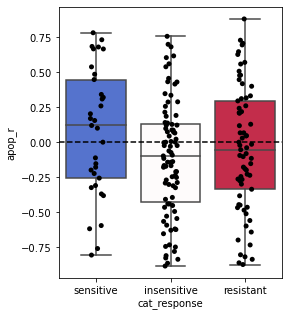

In [531]:
plt.figure(figsize=(4, 5))
sns.boxplot(y='apop_r',
            x='cat_response',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=dose_dep_res)
sns.stripplot(x='cat_response', y='apop_r', color='k', data=dose_dep_res)
plt.axhline(y=0., ls='--', c='k')

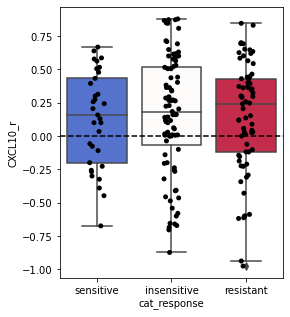

In [533]:
plt.figure(figsize=(4, 5))
sns.boxplot(y='CXCL10_r',
            x='cat_response',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=dose_dep_res)
sns.stripplot(x='cat_response', y='CXCL10_r', color='k', data=dose_dep_res)
plt.axhline(y=0., ls='--', c='k')

In [ ]:
# distribution of dose-dependence of apoptosis and CXCL10 induction

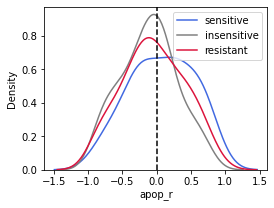

In [520]:
plt.figure(figsize=(4, 3))
for res in dose_dep_res['cat_response'].unique():
    tmp_res = dose_dep_res[dose_dep_res['cat_response'] == res]['apop_r']
    sns.kdeplot(tmp_res.astype(float), label=res, c=response_pal[res])

plt.axvline(x=0., ls='--', c='k')
plt.legend()

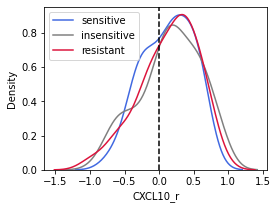

In [535]:
plt.figure(figsize=(4, 3))
for res in dose_dep_res['cat_response'].unique():
    tmp_res = dose_dep_res[dose_dep_res['cat_response'] == res]['CXCL10_r']
    sns.kdeplot(tmp_res.astype(float), label=res, c=response_pal[res])

plt.axvline(x=0., ls='--', c='k')
plt.legend()

In [ ]:
# cumulative distribution of dose-dependence of apoptosis and CXCL10 induction

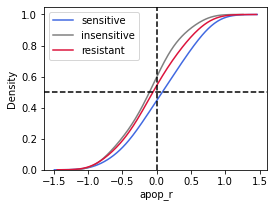

In [522]:
plt.figure(figsize=(4, 3))
for res in dose_dep_res['cat_response'].unique():
    tmp_res = dose_dep_res[dose_dep_res['cat_response'] == res]['apop_r']
    sns.kdeplot(tmp_res.astype(float), label=res, c=response_pal[res], cumulative=True)

plt.axvline(x=0., ls='--', c='k')
plt.axhline(y=0.5, ls='--', c='k')
plt.legend()

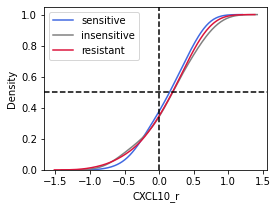

In [534]:
plt.figure(figsize=(4, 3))
for res in dose_dep_res['cat_response'].unique():
    tmp_res = dose_dep_res[dose_dep_res['cat_response'] == res]['CXCL10_r']
    sns.kdeplot(tmp_res.astype(float), label=res, c=response_pal[res], cumulative=True)

plt.axvline(x=0., ls='--', c='k')
plt.axhline(y=0.5, ls='--', c='k')
plt.legend()

## 3. Dose-dependency: apoptosis vs. CXCL10 induction

<AxesSubplot:xlabel='apop_r', ylabel='shift_r'>

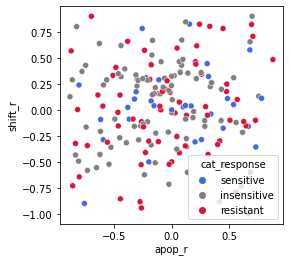

In [537]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='apop_r',
                y='shift_r',
                hue='cat_response',
                palette=response_pal,
                data=dose_dep_res)

<AxesSubplot:xlabel='apop_r', ylabel='rec_r'>

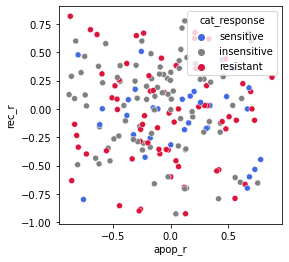

In [539]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='apop_r',
                y='rec_r',
                hue='cat_response',
                palette=response_pal,
                data=dose_dep_res)

<AxesSubplot:xlabel='apop_r', ylabel='nrec_r'>

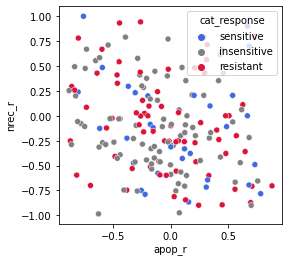

In [540]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='apop_r',
                y='nrec_r',
                hue='cat_response',
                palette=response_pal,
                data=dose_dep_res)

In [605]:
apop_nrec = pd.concat([apop_nes_merge['HALLMARK_APOPTOSIS'], icd_rs_expr_24h['NREC_score']], axis=1).dropna(axis=0, how='any')

In [606]:
apop_nrec

HALLMARK_APOPTOSIS  NREC_score
ABY001_SKBR3_XH:BRD-K19687926:0.625:24           -1.378937   -0.416129
ABY001_SKBR3_XH:BRD-K19687926:10:24              -1.393415   -0.361039
ABY001_SKBR3_XH:BRD-K19687926:2.5:24              0.730299   -0.358472
ABY001_SKBR3_XH:BRD-K21680192:2.5:24              1.244129   -0.263938
ABY001_SKBR3_XH:BRD-K66175015:0.625:24           -1.043744   -0.341525
...                                                    ...         ...
REP.B028_A375_24H:K20                             2.138946   -0.407992
REP.B028_A375_24H:K21                             1.844679   -0.407876
REP.B028_A375_24H:L07                             2.092309   -0.406314
REP.B028_A375_24H:L08                             2.025482   -0.386062
REP.B028_A375_24H:O05                             0.815508   -0.330530

[15699 rows x 2 columns]

(0.0, 3.0)

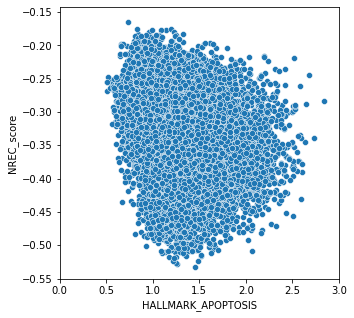

In [610]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='HALLMARK_APOPTOSIS', y='NREC_score', data=apop_nrec)
plt.xlim(0, 3)

<AxesSubplot:xlabel='CXCL10_r', ylabel='nrec_r'>

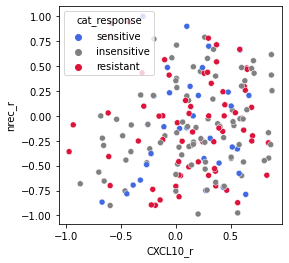

In [545]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='CXCL10_r',
                y='nrec_r',
                hue='cat_response',
                palette=response_pal,
                data=dose_dep_res)

In [541]:
stats.pearsonr(dose_dep_res['apop_r'].fillna(0).astype(float), dose_dep_res['nrec_r'].fillna(0).astype(float))

(-0.21291901049862044, 0.0030258192510969357)

In [542]:
stats.pearsonr(dose_dep_res['apop_r'].fillna(0).astype(float), dose_dep_res['rec_r'].fillna(0).astype(float))

(-0.08134060586014409, 0.26203757705941166)

In [543]:
stats.pearsonr(dose_dep_res['apop_r'].fillna(0).astype(float), dose_dep_res['shift_r'].fillna(0).astype(float))

(0.08455574951660536, 0.24358308865325753)

In [544]:
stats.pearsonr(dose_dep_res['nrec_r'].fillna(0).astype(float), dose_dep_res['CXCL10_r'].fillna(0).astype(float))

(0.11754923948200315, 0.10441668411160766)

<AxesSubplot:xlabel='apop_r', ylabel='CXCL10_r'>

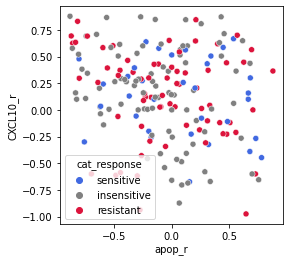

In [524]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='apop_r',
                y='CXCL10_r',
                hue='cat_response',
                palette=response_pal,
                data=dose_dep_res)

In [527]:
stats.spearmanr(dose_dep_res['apop_r'].astype(float), dose_dep_res['CXCL10_r'].astype(float), nan_policy='omit')

SpearmanrResult(correlation=-0.18759145918073328, pvalue=0.009742531612033643)

In [529]:
stats.pearsonr(dose_dep_res['apop_r'].fillna(0).astype(float), dose_dep_res['CXCL10_r'].fillna(0).astype(float))

(-0.21062044067386299, 0.003364063408229779)

In [549]:
dose_dep_res[dose_dep_res['cmap_name'] == 'bortezomib'].dropna(axis=0, how='any')['CXCL10_r']

MCF7_bortezomib      0.057340
HT29_bortezomib     -0.254942
A549_bortezomib     -0.292770
PC3_bortezomib       0.161340
A375_bortezomib      0.088272
SKMEL5_bortezomib    0.877707
Name: CXCL10_r, dtype: float64

In [582]:
dose_dep_cxcl10_pos = dose_dep_res[dose_dep_res['CXCL10_r'] > 0.]
dose_dep_cxcl10_pos_apop_neg = dose_dep_cxcl10_pos[dose_dep_cxcl10_pos['apop_r'] < 0.]
dose_dep_ca_shift_pos = dose_dep_cxcl10_pos_apop_neg[dose_dep_cxcl10_pos_apop_neg['shift_r'] > 0.]

In [572]:
dose_dep_cxcl10_pos_apop_neg['cat_response'].value_counts()

insensitive    43
resistant      28
sensitive      10
Name: cat_response, dtype: int64

In [583]:
dose_dep_ca_shift_pos['cat_response'].value_counts()

insensitive    22
resistant      14
sensitive       7
Name: cat_response, dtype: int64

In [573]:
dose_dep_cxcl10_pos_apop_neg['cmap_name'].value_counts()

vorinostat       6
doxorubicin      6
triptolide       5
panobinostat     4
dasatinib        4
apicidin         4
bortezomib       4
BMS-387032       4
topotecan        3
gemcitabine      3
PHA-793887       3
tanespimycin     3
PLX-4720         2
entinostat       2
YM-155           2
sirolimus        2
nutlin-3         2
clofarabine      2
MK-1775          2
selumetinib      1
alisertib        1
fulvestrant      1
RITA             1
ciclopirox       1
paclitaxel       1
MG-132           1
foretinib        1
staurosporine    1
dinaciclib       1
BMS-536924       1
vemurafenib      1
SN-38            1
tacedinaline     1
PF-03758309      1
CYT-387          1
crizotinib       1
NVP-TAE684       1
Name: cmap_name, dtype: int64

In [584]:
dose_dep_ca_shift_pos['cmap_name'].value_counts()

BMS-387032      4
dasatinib       4
gemcitabine     3
bortezomib      3
triptolide      2
tanespimycin    2
topotecan       2
apicidin        2
YM-155          2
paclitaxel      1
crizotinib      1
dinaciclib      1
nutlin-3        1
sirolimus       1
fulvestrant     1
selumetinib     1
MG-132          1
NVP-TAE684      1
entinostat      1
BMS-536924      1
doxorubicin     1
SN-38           1
vorinostat      1
clofarabine     1
tacedinaline    1
CYT-387         1
MK-1775         1
PLX-4720        1
Name: cmap_name, dtype: int64

In [574]:
dose_dep_cxcl10_pos_apop_neg['moa'].value_counts()

HDAC inhibitor                        16
Topoisomerase inhibitor               10
CDK inhibitor                          8
Proteasome inhibitor                   5
KIT inhibitor                          4
MDM inhibitor                          3
RAF inhibitor                          3
HSP inhibitor                          3
Ribonucleotide reductase inhibitor     3
WEE1 kinase inhibitor                  2
MTOR inhibitor                         2
Ribonucleoside reductase inhibitor     2
ALK inhibitor                          2
Survivin inhibitor                     2
Tubulin inhibitor                      1
IGF-1 inhibitor                        1
Estrogen receptor antagonist           1
Membrane integrity inhibitor           1
PKC inhibitor                          1
Aurora kinase inhibitor                1
P21 activated kinase inhibitor         1
MEK inhibitor                          1
VEGFR inhibitor                        1
Name: moa, dtype: int64

In [585]:
dose_dep_ca_shift_pos['moa'].value_counts()

CDK inhibitor                         5
Proteasome inhibitor                  4
Topoisomerase inhibitor               4
KIT inhibitor                         4
HDAC inhibitor                        4
Ribonucleotide reductase inhibitor    3
ALK inhibitor                         2
HSP inhibitor                         2
Survivin inhibitor                    2
MEK inhibitor                         1
Ribonucleoside reductase inhibitor    1
MDM inhibitor                         1
Estrogen receptor antagonist          1
WEE1 kinase inhibitor                 1
MTOR inhibitor                        1
IGF-1 inhibitor                       1
RAF inhibitor                         1
Tubulin inhibitor                     1
Name: moa, dtype: int64

In [586]:
# dose-dep: CXCL10+, apoptosis-, shift+
dose_dep_ca_shift_pos

shift_r   shift_p     rec_r     rec_p    nrec_r  \
MCF7_entinostat       0.782717  0.000027  0.508007  0.018715 -0.748896   
MCF7_YM-155           0.331444  0.422556  0.098206  0.817045 -0.024551   
MCF7_bortezomib       0.169480  0.062010 -0.036581  0.689137 -0.254223   
MCF7_gemcitabine      0.157711  0.519037  0.190310  0.435156  0.155949   
MCF7_paclitaxel       0.433461  0.331270  0.157622  0.735724 -0.512272   
MCF7_fulvestrant      0.040192  0.813289  0.009838  0.953915 -0.119138   
MCF7_clofarabine      0.319685  0.311088  0.244254  0.444226 -0.391524   
MCF7_BMS-387032       0.617914  0.191094  0.382518  0.454207 -0.029424   
HS578T_dasatinib      0.239046  0.648261  0.478091  0.337502  0.239046   
MDAMB231_dasatinib    0.024135  0.906838 -0.057578  0.779949 -0.224797   
MDAMB231_BMS-387032   0.228932  0.585514  0.385570  0.345511 -0.096393   
MDAMB231_gemcitabine  0.369697  0.293050  0.321212  0.365468 -0.078788   
MDAMB231_triptolide   0.428571  0.337368  0.464286  0.293934 -0.107143   
HT29_triptolide       0.036474  0.920318  0.310032  0.383320  0.668696   
HT29_dasatinib        0.658699  0.038340  0.401493  0.250141 -0.746525   
HT29_apicidin         0.142857  0.787172  0.257143  0.622787  0.542857   
HEPG2_tanespimycin    0.308341  0.329518 -0.426658  0.166607 -0.788779   
HEPG2_topotecan       0.800000  0.104088  0.600000  0.284757  0.200000   
HEPG2_nutlin-3        0.288675  0.637618  0.000000  1.000000 -0.577350   
A549_topotecan        0.348155  0.358535  0.278524  0.468007 -0.426490   
A549_tanespimycin     0.668153  0.100897  0.267261  0.562312 -0.534522   
YAPC_YM-155           0.142857  0.787172  0.657143  0.156175  0.428571   
PC3_bortezomib        0.187336  0.253456  0.129842  0.430798 -0.262711   
PC3_doxorubicin       0.002746  0.991098 -0.234323  0.334254 -0.595875   
PC3_gemcitabine       0.153849  0.569437  0.162725  0.547084 -0.155328   
PC3_NVP-TAE684        0.278887  0.544742 -0.358569  0.429641 -0.597614   
PC3_tacedinaline      0.233550  0.516077  0.253012  0.480626 -0.493049   
PC3_BMS-387032        0.566947  0.142800  0.818923  0.012900 -0.251976   
PC3_dinaciclib        0.572823  0.065488  0.669833  0.024141 -0.161684   
PC3_MG-132            0.177459  0.429486  0.448867  0.036129  0.093949   
PC3_SN-38             0.393939  0.259998  0.030303  0.933773 -0.745455   
A375_vorinostat       0.217686  0.107035  0.142860  0.293555 -0.109023   
A375_PLX-4720         0.104101  0.723221 -0.228135  0.432777 -0.473990   
A375_BMS-536924       0.637748  0.173071  0.376851  0.461483 -0.985611   
A375_MK-1775          0.213745  0.580801 -0.008550  0.982584 -0.307794   
A375_selumetinib      0.145956  0.576189 -0.216460  0.404018 -0.483632   
A375_sirolimus        0.034570  0.884955 -0.357225  0.122049 -0.459400   
A375_dasatinib        0.336144  0.093158  0.245604  0.226518 -0.463802   
A375_CYT-387          0.462910  0.355232  0.370328  0.469902 -0.462910   
A375_BMS-387032       0.288675  0.637618  0.577350  0.308068 -0.288675   
A375_crizotinib       0.288675  0.637618  0.288675  0.637618 -0.288675   
A375_apicidin         0.300000  0.623838  0.600000  0.284757  0.300000   
SKMEL5_bortezomib     0.126592  0.745527  0.126592  0.745527  0.253185   

                        nrec_p  icd_ave_r  icd_ave_p   ANXA1_r   ANXA1_p  ...  \
MCF7_entinostat       0.000094  -0.212590   0.354866  0.095251  0.681289  ...   
MCF7_YM-155           0.953985   0.527856   0.178749  0.220963  0.598983  ...   
MCF7_bortezomib       0.004718  -0.027889   0.760422 -0.181428  0.045507  ...   
MCF7_gemcitabine      0.523776   0.059912   0.807509  0.706615  0.000719  ...   
MCF7_paclitaxel       0.239805  -0.472866   0.283891  0.453163  0.307181  ...   
MCF7_fulvestrant      0.482479  -0.168208   0.319654 -0.378169  0.021010  ...   
MCF7_clofarabine      0.208170  -0.423852   0.169716 -0.373565  0.231641  ...   
MCF7_BMS-387032       0.955876   0.147122   0.780909  0.205971  0.695412  ...   
HS578T_dasatinib      0.648261   0.11

In [587]:
dose_dep_ca_shift_pos.to_csv(poseidon_home + 'apoptosis/CXCL10+_apoptosis-_shift+_candidate.csv', sep=',')

## 4. CXCL10 inducer with low apoptosis activation

In [551]:
cxcl10_induce['apop_nes'] = apop_nes_merge['HALLMARK_APOPTOSIS']
cxcl10_induce['apop_fdr'] = apop_fdr_merge['HALLMARK_APOPTOSIS']

<ipython-input-551-6d1a0bdaa4a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cxcl10_induce['apop_nes'] = apop_nes_merge['HALLMARK_APOPTOSIS']
<ipython-input-551-6d1a0bdaa4a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cxcl10_induce['apop_fdr'] = apop_fdr_merge['HALLMARK_APOPTOSIS']


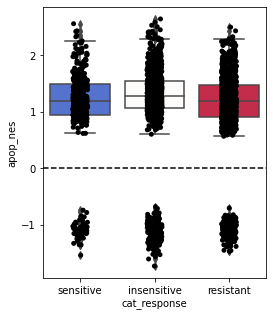

In [555]:
plt.figure(figsize=(4, 5))
sns.boxplot(y='apop_nes',
            x='cat_response',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=cxcl10_induce)
sns.stripplot(x='cat_response', y='apop_nes', color='k', data=cxcl10_induce)
plt.axhline(y=0., ls='--', c='k')

In [557]:
cxcl10_induce['signed_apop'] = -np.sign(cxcl10_induce['apop_nes']) * np.log10(cxcl10_induce['apop_fdr'])

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-557-ef849233cab9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cxcl10_induce['signed_apop'] = -np.sign(cxcl10_induce['apop_nes']) * np.log10(cxcl10_induce['apop_fdr'])


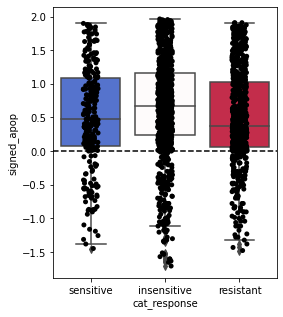

In [566]:
plt.figure(figsize=(4, 5))
sns.boxplot(y='signed_apop',
            x='cat_response',
            palette={'sensitive': 'royalblue',
                     'insensitive': 'snow',
                     'resistant': 'crimson'},
            data=cxcl10_induce.replace([np.inf, -np.inf], np.nan))
sns.stripplot(x='cat_response', y='signed_apop', color='k', data=cxcl10_induce.replace([np.inf, -np.inf], np.nan))
plt.axhline(y=0., ls='--', c='k')

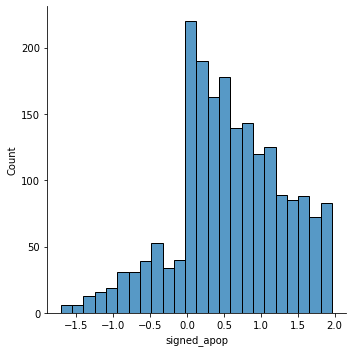

In [563]:
sns.displot(cxcl10_induce['signed_apop'].replace([np.inf, -np.inf], np.nan).dropna(axis=0, how='any'))

## 5. case visualization

### 5.1 bortezomib

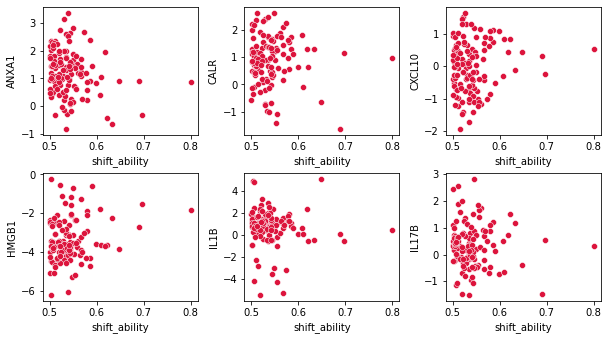

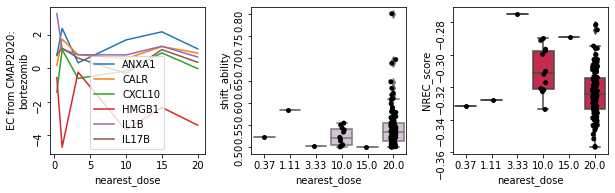

In [588]:
visual_ICD_scatterplot(case='MCF7_bortezomib',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='MCF7_bortezomib',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

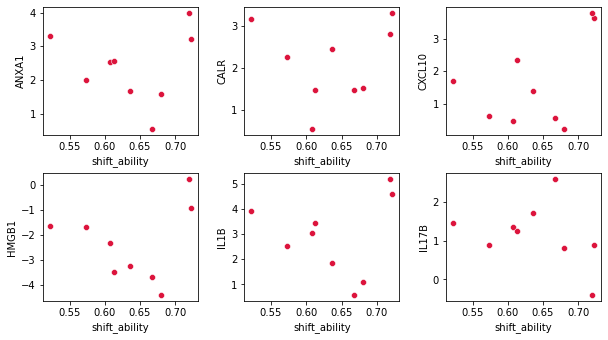

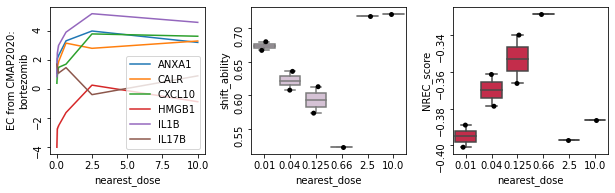

In [589]:
visual_ICD_scatterplot(case='SKMEL5_bortezomib',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='SKMEL5_bortezomib',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

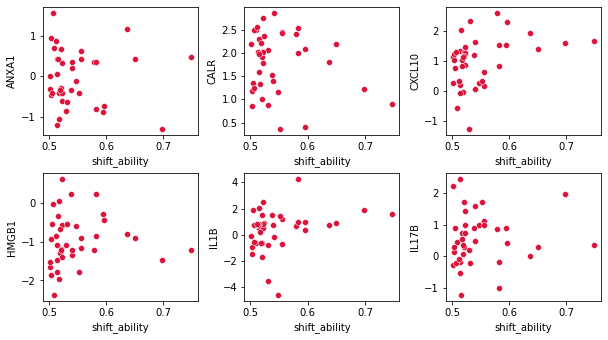

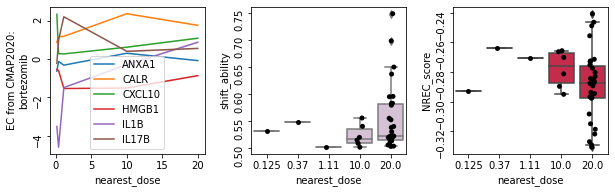

In [590]:
visual_ICD_scatterplot(case='PC3_bortezomib',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='PC3_bortezomib',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

### 5.2 Doxorubicin

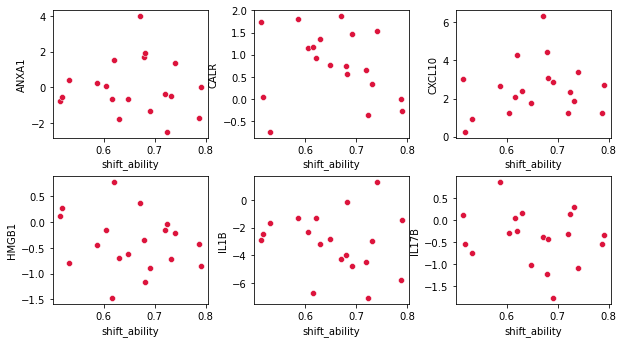

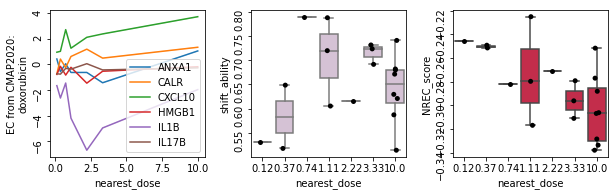

In [591]:
visual_ICD_scatterplot(case='PC3_doxorubicin',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='PC3_doxorubicin',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

### 5.3 apicidin

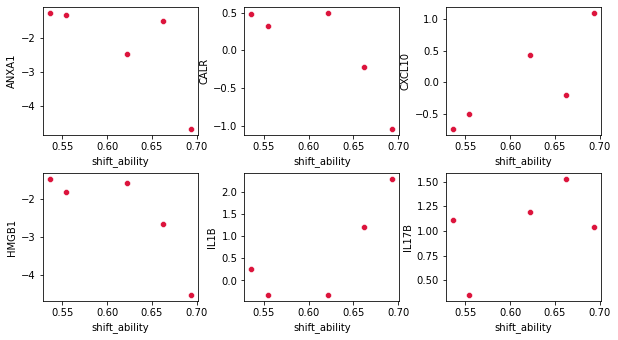

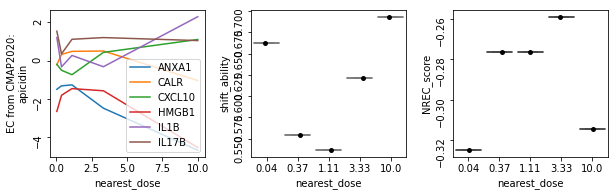

In [592]:
visual_ICD_scatterplot(case='A375_apicidin',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='A375_apicidin',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

### 5.4 Gemcitabine

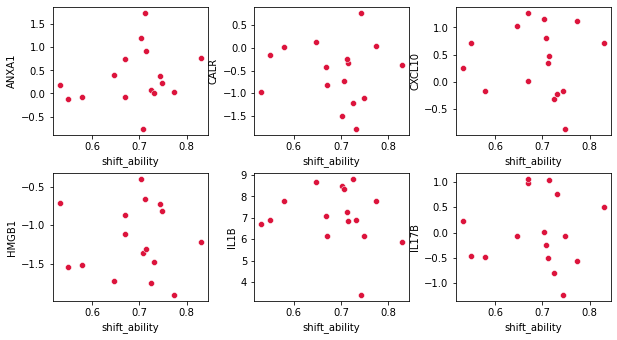

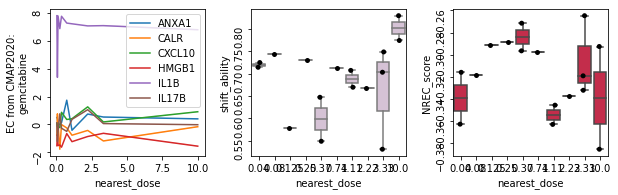

In [593]:
visual_ICD_scatterplot(case='PC3_gemcitabine',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='PC3_gemcitabine',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

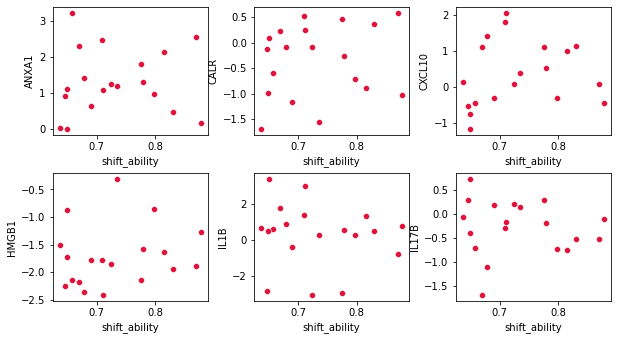

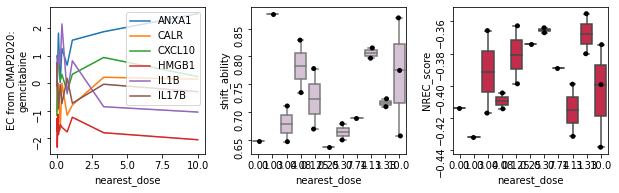

In [594]:
visual_ICD_scatterplot(case='MCF7_gemcitabine',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='MCF7_gemcitabine',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

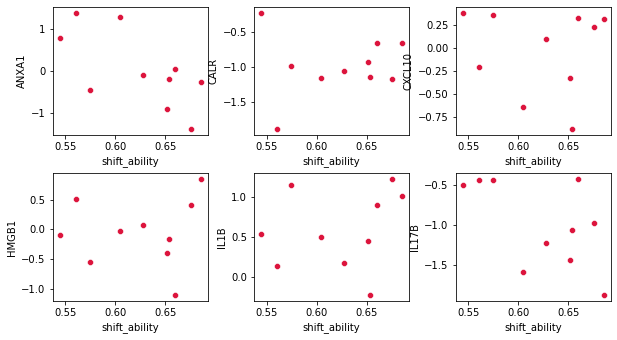

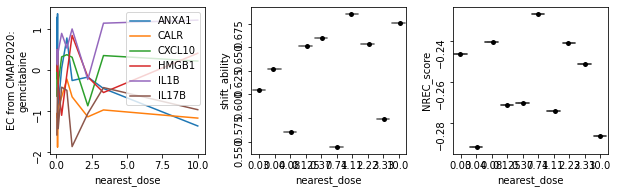

In [598]:
visual_ICD_scatterplot(case='MDAMB231_gemcitabine',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='MDAMB231_gemcitabine',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

### 5.5 Topotecan

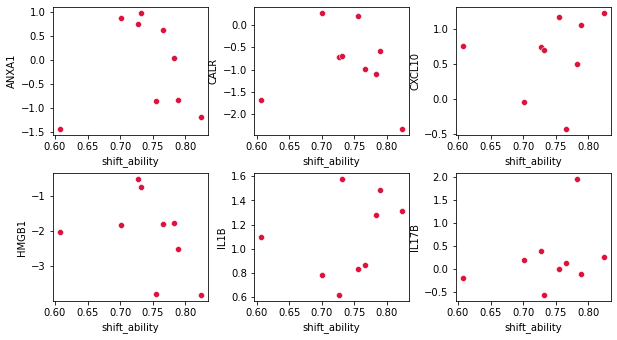

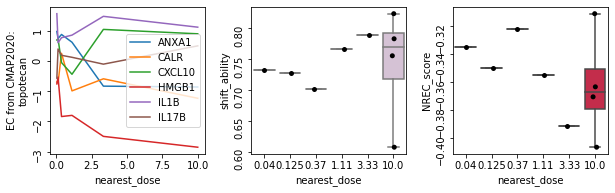

In [595]:
visual_ICD_scatterplot(case='A549_topotecan',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='A549_topotecan',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

### 5.6 SAHA

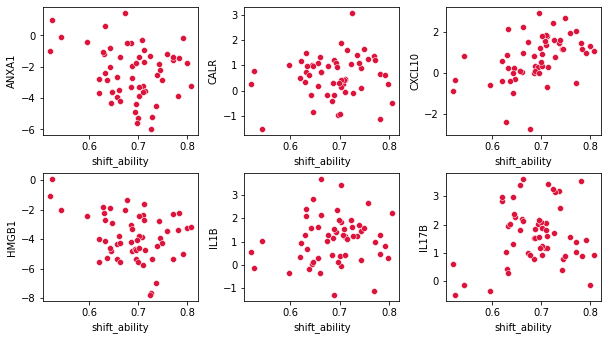

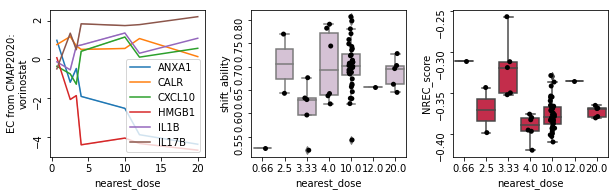

In [596]:
visual_ICD_scatterplot(case='A375_vorinostat',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='A375_vorinostat',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)

### 5.7 dinaciclib

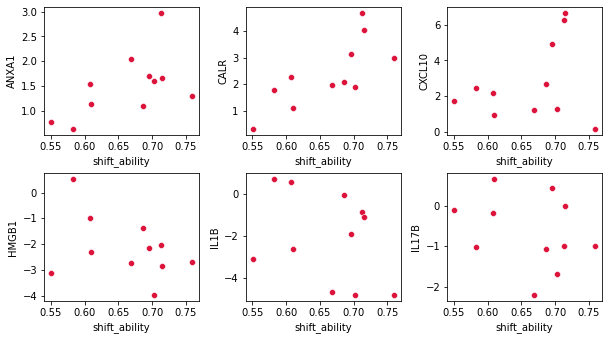

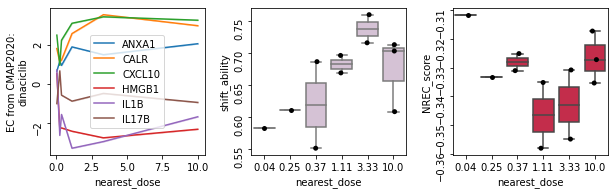

In [597]:
visual_ICD_scatterplot(case='PC3_dinaciclib',
                       merge_24h=icd_rs_expr_24h,
                       icd_glist=icd_selected,
                       save_path=None)

visual_ICD_lineplot(case='PC3_dinaciclib',
                    merge_24h=icd_rs_expr_24h,
                    icd_glist=icd_selected,
                    save_path=None)